<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [25]</a>'.</span>

# Classical Transformer


In [1]:
import os
import math
import random
from typing import Callable, Iterable
from copy import deepcopy
import numpy as np
from time import time

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch import Tensor, device
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from torchtext.vocab import Vocab
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import build_vocab_from_iterator

/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IM

## Setting up environment


In [2]:
dev = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(dev)

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

1
0
Tesla V100-PCIE-32GB


## Helper functions


### Binary Accuracy


In [4]:
def binary_accuracy(preds: Tensor, y: Tensor):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # round predictions to the closest integer
    rounded_preds = preds.sigmoid().round()
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

### Clone Model


In [5]:
def get_clones(module: nn.Module, N: int):
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

### Data Loader


In [6]:
def yield_tokens(data: list[tuple[int, str]], tokenizer: Callable[[str], list[str]]):
    for label, text in data:
        yield tokenizer(text.lower())


def text_transform(text: str, vocab: Vocab, tokenizer: Callable[[str], list[str]]):
    return vocab([token for token in tokenizer(text.lower())])


def label_transform(label: int):
    return torch.tensor(1.0 if label == 2 else 0.0, dtype=torch.float)


def collate_batch(
    batch: Iterable[tuple[int, str]],
    vocab: Vocab,
    tokenizer: Callable[[str], list[str]],
):
    pad_idx = vocab["<pad>"]
    label_list, text_list = [], []

    for label, text in batch:
        label_list.append(label_transform(label))
        processed_text = torch.tensor(text_transform(text, vocab, tokenizer))
        text_list.append(processed_text)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=pad_idx)


def batch_sampler(data: list, batch_size: int, tokenizer: Callable[[str], list[str]]):
    indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(data)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths
    for i in range(0, len(indices), batch_size * 100):
        pooled_indices.extend(
            sorted(indices[i : i + batch_size * 100], key=lambda x: x[1])
        )

    pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), batch_size):
        yield pooled_indices[i : i + batch_size]

### Parameter Count


In [7]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Epoch Time


In [8]:
def epoch_time(start_time: float, end_time: float):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train


In [9]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optimizer,
    criterion: _Loss,
    max_seq_len: int,
    progress_bar,
):
    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.train()
    for i, (lab, text) in enumerate(dataloader):

        optimizer.zero_grad()
        inputs = torch.LongTensor(text.T).to(dev)
        if inputs.size(1) > max_seq_len:
            inputs = inputs[:, :max_seq_len]
        model.to(dev)
        predictions = model(inputs).squeeze(1)

        label = lab.to(dev)
        # label = label.unsqueeze(1)
        loss = criterion(predictions, label)
        # loss = F.nll_loss(predictions, label)
        acc = binary_accuracy(predictions, label)

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
        epoch_true.extend(label.tolist())
        epoch_pred.extend(predictions.sigmoid().tolist())

        progress_bar.update(dataloader.batch_size)

    # print(epoch_loss, epoch_acc, len(dataloader.dataset))

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")
    # divide the total loss by the total number of batches per epoch
    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

### Evaluate


In [10]:
def evaluate(
    model: nn.Module, dataloader: DataLoader, criterion: _Loss, max_seq_len: int
):

    epoch_loss = []
    epoch_acc = []
    epoch_true = []
    epoch_pred = []

    model.eval()

    with torch.no_grad():
        for i, (lab, text) in enumerate(dataloader):
            inputs = torch.LongTensor(text.T).to(dev)
            if inputs.size(1) > max_seq_len:
                inputs = inputs[:, :max_seq_len]

            predictions = model(inputs).squeeze(1)
            label = lab.to(dev)

            # label = label.unsqueeze(1)

            loss = criterion(predictions, label)
            # loss = F.nll_loss(predictions, label)

            acc = binary_accuracy(predictions, label)

            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_true.extend(label.tolist())
            epoch_pred.extend(predictions.sigmoid().tolist())

    epoch_auc = 100.0 * roc_auc_score(epoch_true, epoch_pred, multi_class="ovr")

    # divide the total loss by the total number of batches per epoch

    return np.mean(epoch_loss), np.mean(epoch_acc), epoch_auc

## Model


### Positional Encoding


In [11]:
class PositionalEncoder(nn.Module):

    def __init__(self, d_model: int, dropout=0.1, max_len=512, device=device("cpu")):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, 1, d_model, device=device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        seq_len = x.size(1)
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

### Attention


In [12]:
def attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    mask: Tensor | None = None,
    dropout: nn.Dropout | None = None,
):
    """Scaled Dot Product Attention"""
    dim_k = query.size(-1)
    # scaled = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_k)
    scaled = (query @ key.transpose(-2, -1)) / math.sqrt(dim_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scaled = scaled.masked_fill(mask == 0, -1e9)
    scores = scaled.softmax(-1)
    if dropout is not None:
        scores: Tensor = dropout(scores)
    # attn = torch.matmul(scores, value)
    attn = scores @ value
    return attn, scores

### Quantum Multi-Head Attention


In [13]:
import pennylane as qml
import pennylane.templates as qmlt
import pennylane.qnn.torch as qml_qnn_torch

In [14]:
class QuantumLayer(torch.nn.Module):
    def __init__(self, n_qubits, n_qlayers=1, q_device="default.qubit"):
        super().__init__()

        dev = qml.device(q_device, wires=n_qubits, torch_device="cuda")

        @qml.qnode(dev, interface="torch")
        def qlayer(inputs, weights):
            # qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="X")
            qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Z")
            qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits), rotation=qml.RZ)
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        self.linear = qml_qnn_torch.TorchLayer(qlayer, weight_shapes)

    def forward(self, inputs):
        return self.linear(inputs)

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout=0.1,
        mask: Tensor | None = None,
        use_bias=False,
        n_qubits=4,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(MultiHeadedAttention, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mask = mask
        # We assume dim_v always equals dim_k
        self.dim_k = embed_dim // num_heads  # projection dimensions

        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        # The quantum layers for the query, key, and value projections
        self.k_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.q_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.v_linear = QuantumLayer(n_qubits, n_qlayers, q_device)
        # The quantum layer to combine the heads
        self.combine_heads = QuantumLayer(n_qubits, n_qlayers, q_device)

        self.attn_weights: Tensor | None = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor | None = None
    ):
        batch_size, seq_len, embed_dim = query.size()
        assert (
            embed_dim == self.embed_dim
        ), f"Input embedding ({embed_dim}) does not match layer embedding size ({self.embed_dim})"

        K = [self.k_linear(key[:, t, :]) for t in range(seq_len)]
        Q = [self.q_linear(query[:, t, :]) for t in range(seq_len)]
        V = [self.v_linear(value[:, t, :]) for t in range(seq_len)]

        K = torch.Tensor(pad_sequence(K))
        Q = torch.Tensor(pad_sequence(Q))
        V = torch.Tensor(pad_sequence(V))

        x: Tensor
        x, self.attn_weights = attention(Q, K, V, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, embed_dim)

        output = [self.combine_heads(x[:, t, :]) for t in range(seq_len)]
        output = torch.Tensor(pad_sequence(output))
        return output

### Quantum Feed-Forward Network


In [16]:
class FeedForward(nn.Module):
    """
    The x that is passed to the forward method is a tensor of shape (batch_size, sequence_length, embedding_dimension),
    rather than a flattened version of it (with shape (batch_size, sequence_length * embedding_dimension)).
    The (same) feed-forward layer applies to the last dimension only (the embedding dimension) for each batch and
    for each position in the sequence, hence position-wise.
    """

    def __init__(
        self,
        embed_dim: int,
        n_qubits: int,
        n_qlayers=1,
        dropout=0.1,
        q_device="default.qubit",
    ):
        super(FeedForward, self).__init__()
        self.ffn_dim = n_qubits

        self.linear_1 = nn.Linear(embed_dim, self.ffn_dim)
        self.linear_2 = nn.Linear(self.ffn_dim, embed_dim)
        self.vqc = QuantumLayer(n_qubits, n_qlayers, q_device)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        batch_size, seq_len, embed_dim = x.size()
        x = self.linear_1(x)
        X = [self.vqc(x[:, t, :]) for t in range(seq_len)]
        x = torch.Tensor(pad_sequence(X))
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

### Quantum Encoder


In [17]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ffn_dim: int,
        dropout: float = 0.1,
        mask: Tensor | None = None,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(Encoder, self).__init__()

        self.n_qubits_transformer = n_qubits_transformer
        self.n_qubits_ffn = n_qubits_ffn
        self.n_qlayers = n_qlayers

        self.attn = MultiHeadedAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            mask=mask,
            n_qubits=n_qubits_transformer,
            n_qlayers=n_qlayers,
            q_device=q_device,
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = FeedForward(
            embed_dim, n_qubits_ffn, n_qlayers, q_device=q_device, dropout=dropout
        )

        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        attn_output = self.attn(x, x, x)
        x = self.norm1(attn_output + x)
        x = self.dropout1(x)

        ff_output: Tensor = self.ffn(x)
        x = self.norm2(ff_output + x)
        x = self.dropout2(x)

        return x

### Text Classifier


In [18]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        num_blocks: int,
        num_classes: int,
        vocab_size: int,
        max_seq_len: int,
        ffn_dim=32,
        dropout=0.1,
        n_qubits_transformer=0,
        n_qubits_ffn=0,
        n_qlayers=1,
        q_device="default.qubit",
    ):
        super(TextClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.vocab_size = vocab_size

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = PositionalEncoder(embed_dim, max_len=max_seq_len)

        print(f"++ There will be {num_blocks} transformer blocks")

        print(
            f"++ Transformer will use {n_qubits_transformer} qubits and {n_qlayers} q layers"
        )

        print(f"The feed-forward head will use {n_qubits_ffn} qubits")

        print(f"Using quantum device {q_device}")

        self.transformers = get_clones(
            Encoder(
                embed_dim,
                num_heads,
                ffn_dim,
                n_qubits_transformer=n_qubits_transformer,
                n_qubits_ffn=n_qubits_ffn,
                n_qlayers=n_qlayers,
                q_device=q_device,
            ),
            num_blocks,
        )

        self.class_logits = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor):
        tokens = self.token_embedding(x)
        x = self.pos_embedding(tokens)

        # # Normalise the data to range [0, 2*pi]
        # min_val = x.min()
        # max_val = x.max()

        # x = (x - min_val) / (max_val - min_val) * (2 * torch.pi)

        # print(f"Minimum value: {x.min()}, Maximum value: {x.max()}")

        for transformer in self.transformers:
            x = transformer(x)

        x = x.mean(dim=1)  # global average pooling, works in 1D
        x = self.dropout(x)
        x = self.class_logits(x)
        return x

### Main Function


In [19]:
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split




def main(
    max_seq_len=128,
    batch_size=32,
    total_size=3200,
    n_epochs=30,
    lr=0.001,
    embed_dim=8,
    num_heads=2,
    num_blocks=2,
    num_classes=2,
    vocab_size=50000,
    ffn_dim=16,
    n_qubits_transformer=0,
    n_qubits_ffn=0,
    n_qlayers=0,
    q_device="default.qubit",
    dropout_rate=0.1,
):
  
    save_dir = f".models_{n_epochs}_{n_qubits_transformer}_{n_qubits_ffn}_{n_qlayers}"
    save_path = os.path.join(save_dir, "model_and_metrics_epoch_{}.pt")
    os.makedirs(save_dir, exist_ok=True)

    # train_iter = IMDB(root="./.datatext", split="train")
    # test_iter = IMDB(root="./.datatext", split="test")

    # train_data = to_map_style_dataset(train_iter)
    # test_data = to_map_style_dataset(test_iter)

    size = total_size

    # test_data = np.array(test_data)[
    #     np.random.choice(len(test_data), size=size, replace=False)
    # ].tolist()

    train_iter = IMDB(root="./.datatext", split="train")

    train_data = to_map_style_dataset(train_iter)
    train_data = np.array(train_data)[
        np.random.choice(len(train_data), size=size, replace=False)
    ].tolist()

    train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

    train_data = [(int(label), text) for label, text in train_data]
    test_data = [(int(label), text) for label, text in test_data]

    print("pos: ", len([label for label, text in train_data if label == 1]))
    print("neg: ", len([label for label, text in train_data if label == 2]))

    tokenizer = get_tokenizer("basic_english")
    vocab = build_vocab_from_iterator(
        yield_tokens(train_data, tokenizer),
        specials=["<unk>", "<pad>"],
        max_tokens=vocab_size,
    )
    vocab.set_default_index(vocab["<unk>"])

    train_loader = DataLoader(
        train_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )
    test_loader = DataLoader(
        test_data,  # type: ignore
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_batch(batch, vocab, tokenizer),
    )

    model = TextClassifier(
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_blocks=num_blocks,
        num_classes=num_classes,
        vocab_size=vocab_size,
        ffn_dim=ffn_dim,
        n_qubits_transformer=n_qubits_transformer,
        n_qubits_ffn=n_qubits_ffn,
        n_qlayers=n_qlayers,
        dropout=dropout_rate,
        q_device=q_device,
        max_seq_len=max_seq_len,
    )

    print(f"The model has {count_parameters(model):,} trainable parameters")
    start_time = time()

    model.to(dev)

    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    criterion = torch.nn.BCEWithLogitsLoss()  # logits -> sigmoid -> loss
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # training loop
    best_test_loss = float("inf")
    best_test_acc, best_epoch_acc = 0.0, 0
    best_test_auc, best_epoch_auc = 0.0, 0
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = [], [], [], []
    train_auc_list, test_auc_list = [], []
    for iepoch in range(n_epochs):
        with tqdm(
            total=len(train_loader.dataset),
            desc=f"Epoch {iepoch+1:3}/{n_epochs}",
            unit="batch",
            bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}",
            # position=0,
            # leave=True,
        ) as progress_bar:
            operation_start_time = time()

            train_loss, train_acc, train_auc = train(
                model, train_loader, optimizer, criterion, max_seq_len, progress_bar
            )

            # scheduler.step()

            test_loss, test_acc, test_auc = evaluate(
                model, test_loader, criterion, max_seq_len
            )

            end_time = time()

            epoch_mins, epoch_secs = epoch_time(operation_start_time, end_time)

            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            train_auc_list.append(train_auc)
            test_auc_list.append(test_auc)

            progress_bar.set_postfix_str(
                f"Epoch = {epoch_mins}m {epoch_secs}s, Loss = {train_loss:.4f}|{test_loss:.4f}, Acc = {train_acc:.3f}|{test_acc:.3f}, AUC = {train_auc:.3f}|{test_auc:.3f}"
            )
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_epoch_acc = iepoch + 1
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                best_epoch_auc = iepoch + 1
                
            torch.save(
                {
                    "epoch": iepoch + 1,
                    "model_state_dict": model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    "train_loss": train_loss_list,
                    "train_acc": train_acc_list,
                    "train_auc": train_auc_list,
                    "test_loss": test_loss_list,
                    "test_acc": test_acc_list,
                    "test_auc": test_auc_list,
                },
                save_path.format(iepoch + 1),
            )

            # if test_loss < best_test_loss:
            #     best_test_loss = test_loss
            #     torch.save(model.state_dict(), "model.pt")

    print(f"TOTAL TIME = {time()-start_time:.2f}s")
    print(f"BEST ACC = {best_test_acc:.2f}% AT EPOCH {best_epoch_acc}")
    print(f"BEST AUC = {best_test_auc:.2f} AT EPOCH {best_epoch_auc}")

    return (
        train_loss_list,
        train_acc_list,
        test_loss_list,
        test_acc_list,
        train_auc_list,
        test_auc_list,
    )

## Training


In [20]:
qml.about()

Name: PennyLane
Version: 0.37.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/nchoong/.conda/envs/quant/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, packaging, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane_Lightning

Platform info:           Linux-4.18.0-348.12.2.el8_5.x86_64-x86_64-with-glibc2.28
Python version:          3.11.8
Numpy version:           1.26.3
Scipy version:           1.14.0
Installed devices:
- default.clifford (PennyLane-0.37.0)
- default.gaussian (PennyLane-0.37.0)
- default.mixed (PennyLane-0.37.0)
- default.qubit (PennyLane-0.37.0)
- default.qubit.autograd (PennyLane-0.37.0)
- default.qubit.ja

In [21]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()

In [22]:
train_loss, train_acc, test_loss, test_acc, train_auc, test_auc = main(
    n_epochs=16,
    embed_dim=8,
    n_qubits_transformer=8,
    n_qubits_ffn=8,
    n_qlayers=6,
    num_blocks=3,
    num_heads=3,
    q_device="default.qubit.torch",
    total_size=5000,
)

/home/nchoong/.conda/envs/quant/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


pos:  1999
neg:  2001


++ There will be 3 transformer blocks
++ Transformer will use 8 qubits and 6 q layers
The feed-forward head will use 8 qubits
Using quantum device default.qubit.torch
weight_shapes = (n_qlayers, n_qubits) = (6, 8)
The model has 401,257 trainable parameters


Epoch   1/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   1/16:   1%|          | 32/4000 [01:45<3:38:33,  3.30s/batch]

Epoch   1/16:   2%|▏         | 64/4000 [03:37<3:43:54,  3.41s/batch]

Epoch   1/16:   2%|▏         | 96/4000 [05:28<3:44:00,  3.44s/batch]

Epoch   1/16:   3%|▎         | 128/4000 [07:22<3:44:42,  3.48s/batch]

Epoch   1/16:   4%|▍         | 160/4000 [09:15<3:44:01,  3.50s/batch]

Epoch   1/16:   5%|▍         | 192/4000 [11:08<3:43:17,  3.52s/batch]

Epoch   1/16:   6%|▌         | 224/4000 [13:03<3:42:30,  3.54s/batch]

Epoch   1/16:   6%|▋         | 256/4000 [14:58<3:41:46,  3.55s/batch]

Epoch   1/16:   7%|▋         | 288/4000 [16:52<3:40:31,  3.56s/batch]

Epoch   1/16:   8%|▊         | 320/4000 [18:48<3:39:41,  3.58s/batch]

Epoch   1/16:   9%|▉         | 352/4000 [20:44<3:38:24,  3.59s/batch]

Epoch   1/16:  10%|▉         | 384/4000 [22:43<3:38:39,  3.63s/batch]

Epoch   1/16:  10%|█         | 416/4000 [24:36<3:35:15,  3.60s/batch]

Epoch   1/16:  11%|█         | 448/4000 [26:30<3:32:17,  3.59s/batch]

Epoch   1/16:  12%|█▏        | 480/4000 [28:23<3:29:38,  3.57s/batch]

Epoch   1/16:  13%|█▎        | 512/4000 [30:17<3:27:20,  3.57s/batch]

Epoch   1/16:  14%|█▎        | 544/4000 [32:11<3:25:19,  3.56s/batch]

Epoch   1/16:  14%|█▍        | 576/4000 [34:05<3:23:34,  3.57s/batch]

Epoch   1/16:  15%|█▌        | 608/4000 [35:59<3:21:24,  3.56s/batch]

Epoch   1/16:  16%|█▌        | 640/4000 [37:52<3:19:23,  3.56s/batch]

Epoch   1/16:  17%|█▋        | 672/4000 [39:46<3:17:31,  3.56s/batch]

Epoch   1/16:  18%|█▊        | 704/4000 [41:40<3:15:19,  3.56s/batch]

Epoch   1/16:  18%|█▊        | 736/4000 [43:33<3:12:54,  3.55s/batch]

Epoch   1/16:  19%|█▉        | 768/4000 [45:26<3:10:49,  3.54s/batch]

Epoch   1/16:  20%|██        | 800/4000 [47:19<3:08:43,  3.54s/batch]

Epoch   1/16:  21%|██        | 832/4000 [49:12<3:06:42,  3.54s/batch]

Epoch   1/16:  22%|██▏       | 864/4000 [51:05<3:04:59,  3.54s/batch]

Epoch   1/16:  22%|██▏       | 896/4000 [52:58<3:03:08,  3.54s/batch]

Epoch   1/16:  23%|██▎       | 928/4000 [54:52<3:01:15,  3.54s/batch]

Epoch   1/16:  24%|██▍       | 960/4000 [56:45<2:59:12,  3.54s/batch]

Epoch   1/16:  25%|██▍       | 992/4000 [58:38<2:57:13,  3.54s/batch]

Epoch   1/16:  26%|██▌       | 1024/4000 [1:00:30<2:54:51,  3.53s/batch]

Epoch   1/16:  26%|██▋       | 1056/4000 [1:02:23<2:53:07,  3.53s/batch]

Epoch   1/16:  27%|██▋       | 1088/4000 [1:04:16<2:51:16,  3.53s/batch]

Epoch   1/16:  28%|██▊       | 1120/4000 [1:06:08<2:48:58,  3.52s/batch]

Epoch   1/16:  29%|██▉       | 1152/4000 [1:08:01<2:47:26,  3.53s/batch]

Epoch   1/16:  30%|██▉       | 1184/4000 [1:09:54<2:45:34,  3.53s/batch]

Epoch   1/16:  30%|███       | 1216/4000 [1:11:47<2:43:44,  3.53s/batch]

Epoch   1/16:  31%|███       | 1248/4000 [1:13:40<2:41:56,  3.53s/batch]

Epoch   1/16:  32%|███▏      | 1280/4000 [1:15:33<2:39:45,  3.52s/batch]

Epoch   1/16:  33%|███▎      | 1312/4000 [1:17:26<2:38:09,  3.53s/batch]

Epoch   1/16:  34%|███▎      | 1344/4000 [1:19:19<2:36:19,  3.53s/batch]

Epoch   1/16:  34%|███▍      | 1376/4000 [1:21:11<2:34:10,  3.53s/batch]

Epoch   1/16:  35%|███▌      | 1408/4000 [1:23:05<2:32:24,  3.53s/batch]

Epoch   1/16:  36%|███▌      | 1440/4000 [1:24:58<2:30:33,  3.53s/batch]

Epoch   1/16:  37%|███▋      | 1472/4000 [1:26:50<2:28:31,  3.53s/batch]

Epoch   1/16:  38%|███▊      | 1504/4000 [1:28:43<2:26:37,  3.52s/batch]

Epoch   1/16:  38%|███▊      | 1536/4000 [1:30:36<2:24:47,  3.53s/batch]

Epoch   1/16:  39%|███▉      | 1568/4000 [1:32:29<2:23:03,  3.53s/batch]

Epoch   1/16:  40%|████      | 1600/4000 [1:34:21<2:20:54,  3.52s/batch]

Epoch   1/16:  41%|████      | 1632/4000 [1:36:14<2:19:06,  3.52s/batch]

Epoch   1/16:  42%|████▏     | 1664/4000 [1:38:07<2:17:21,  3.53s/batch]

Epoch   1/16:  42%|████▏     | 1696/4000 [1:40:00<2:15:18,  3.52s/batch]

Epoch   1/16:  43%|████▎     | 1728/4000 [1:41:52<2:13:25,  3.52s/batch]

Epoch   1/16:  44%|████▍     | 1760/4000 [1:43:45<2:11:36,  3.53s/batch]

Epoch   1/16:  45%|████▍     | 1792/4000 [1:45:38<2:09:47,  3.53s/batch]

Epoch   1/16:  46%|████▌     | 1824/4000 [1:47:30<2:07:40,  3.52s/batch]

Epoch   1/16:  46%|████▋     | 1856/4000 [1:49:23<2:05:51,  3.52s/batch]

Epoch   1/16:  47%|████▋     | 1888/4000 [1:51:16<2:03:59,  3.52s/batch]

Epoch   1/16:  48%|████▊     | 1920/4000 [1:53:09<2:02:13,  3.53s/batch]

Epoch   1/16:  49%|████▉     | 1952/4000 [1:55:01<2:00:05,  3.52s/batch]

Epoch   1/16:  50%|████▉     | 1984/4000 [1:56:54<1:58:18,  3.52s/batch]

Epoch   1/16:  50%|█████     | 2016/4000 [1:58:47<1:56:34,  3.53s/batch]

Epoch   1/16:  51%|█████     | 2048/4000 [2:00:40<1:54:35,  3.52s/batch]

Epoch   1/16:  52%|█████▏    | 2080/4000 [2:02:33<1:52:47,  3.52s/batch]

Epoch   1/16:  53%|█████▎    | 2112/4000 [2:04:26<1:51:07,  3.53s/batch]

Epoch   1/16:  54%|█████▎    | 2144/4000 [2:06:19<1:49:10,  3.53s/batch]

Epoch   1/16:  54%|█████▍    | 2176/4000 [2:08:12<1:47:24,  3.53s/batch]

Epoch   1/16:  55%|█████▌    | 2208/4000 [2:10:05<1:45:23,  3.53s/batch]

Epoch   1/16:  56%|█████▌    | 2240/4000 [2:11:59<1:43:47,  3.54s/batch]

Epoch   1/16:  57%|█████▋    | 2272/4000 [2:13:52<1:41:52,  3.54s/batch]

Epoch   1/16:  58%|█████▊    | 2304/4000 [2:15:46<1:40:11,  3.54s/batch]

Epoch   1/16:  58%|█████▊    | 2336/4000 [2:17:39<1:38:17,  3.54s/batch]

Epoch   1/16:  59%|█████▉    | 2368/4000 [2:19:33<1:36:35,  3.55s/batch]

Epoch   1/16:  60%|██████    | 2400/4000 [2:21:27<1:34:41,  3.55s/batch]

Epoch   1/16:  61%|██████    | 2432/4000 [2:23:21<1:32:52,  3.55s/batch]

Epoch   1/16:  62%|██████▏   | 2464/4000 [2:25:15<1:31:03,  3.56s/batch]

Epoch   1/16:  62%|██████▏   | 2496/4000 [2:27:09<1:29:11,  3.56s/batch]

Epoch   1/16:  63%|██████▎   | 2528/4000 [2:29:03<1:27:13,  3.56s/batch]

Epoch   1/16:  64%|██████▍   | 2560/4000 [2:30:56<1:25:17,  3.55s/batch]

Epoch   1/16:  65%|██████▍   | 2592/4000 [2:32:49<1:23:17,  3.55s/batch]

Epoch   1/16:  66%|██████▌   | 2624/4000 [2:34:43<1:21:24,  3.55s/batch]

Epoch   1/16:  66%|██████▋   | 2656/4000 [2:36:37<1:19:29,  3.55s/batch]

Epoch   1/16:  67%|██████▋   | 2688/4000 [2:38:30<1:17:34,  3.55s/batch]

Epoch   1/16:  68%|██████▊   | 2720/4000 [2:40:24<1:15:44,  3.55s/batch]

Epoch   1/16:  69%|██████▉   | 2752/4000 [2:42:18<1:13:53,  3.55s/batch]

Epoch   1/16:  70%|██████▉   | 2784/4000 [2:44:11<1:11:56,  3.55s/batch]

Epoch   1/16:  70%|███████   | 2816/4000 [2:46:05<1:10:08,  3.55s/batch]

Epoch   1/16:  71%|███████   | 2848/4000 [2:47:58<1:08:09,  3.55s/batch]

Epoch   1/16:  72%|███████▏  | 2880/4000 [2:49:52<1:06:20,  3.55s/batch]

Epoch   1/16:  73%|███████▎  | 2912/4000 [2:51:45<1:04:19,  3.55s/batch]

Epoch   1/16:  74%|███████▎  | 2944/4000 [2:53:39<1:02:30,  3.55s/batch]

Epoch   1/16:  74%|███████▍  | 2976/4000 [2:55:33<1:00:35,  3.55s/batch]

Epoch   1/16:  75%|███████▌  | 3008/4000 [2:57:27<58:45,  3.55s/batch]  

Epoch   1/16:  76%|███████▌  | 3040/4000 [2:59:21<56:57,  3.56s/batch]

Epoch   1/16:  77%|███████▋  | 3072/4000 [3:01:15<54:59,  3.56s/batch]

Epoch   1/16:  78%|███████▊  | 3104/4000 [3:03:08<53:02,  3.55s/batch]

Epoch   1/16:  78%|███████▊  | 3136/4000 [3:05:01<51:05,  3.55s/batch]

Epoch   1/16:  79%|███████▉  | 3168/4000 [3:06:55<49:13,  3.55s/batch]

Epoch   1/16:  80%|████████  | 3200/4000 [3:08:48<47:13,  3.54s/batch]

Epoch   1/16:  81%|████████  | 3232/4000 [3:10:41<45:21,  3.54s/batch]

Epoch   1/16:  82%|████████▏ | 3264/4000 [3:12:35<43:29,  3.55s/batch]

Epoch   1/16:  82%|████████▏ | 3296/4000 [3:14:27<41:29,  3.54s/batch]

Epoch   1/16:  83%|████████▎ | 3328/4000 [3:16:21<39:38,  3.54s/batch]

Epoch   1/16:  84%|████████▍ | 3360/4000 [3:18:14<37:46,  3.54s/batch]

Epoch   1/16:  85%|████████▍ | 3392/4000 [3:20:07<35:50,  3.54s/batch]

Epoch   1/16:  86%|████████▌ | 3424/4000 [3:22:01<33:59,  3.54s/batch]

Epoch   1/16:  86%|████████▋ | 3456/4000 [3:23:54<32:06,  3.54s/batch]

Epoch   1/16:  87%|████████▋ | 3488/4000 [3:25:48<30:15,  3.55s/batch]

Epoch   1/16:  88%|████████▊ | 3520/4000 [3:27:41<28:20,  3.54s/batch]

Epoch   1/16:  89%|████████▉ | 3552/4000 [3:29:34<26:26,  3.54s/batch]

Epoch   1/16:  90%|████████▉ | 3584/4000 [3:31:28<24:33,  3.54s/batch]

Epoch   1/16:  90%|█████████ | 3616/4000 [3:33:20<22:37,  3.54s/batch]

Epoch   1/16:  91%|█████████ | 3648/4000 [3:35:14<20:46,  3.54s/batch]

Epoch   1/16:  92%|█████████▏| 3680/4000 [3:37:07<18:51,  3.54s/batch]

Epoch   1/16:  93%|█████████▎| 3712/4000 [3:39:00<16:58,  3.54s/batch]

Epoch   1/16:  94%|█████████▎| 3744/4000 [3:40:54<15:06,  3.54s/batch]

Epoch   1/16:  94%|█████████▍| 3776/4000 [3:42:46<13:11,  3.53s/batch]

Epoch   1/16:  95%|█████████▌| 3808/4000 [3:44:39<11:18,  3.53s/batch]

Epoch   1/16:  96%|█████████▌| 3840/4000 [3:46:32<09:25,  3.53s/batch]

Epoch   1/16:  97%|█████████▋| 3872/4000 [3:48:25<07:32,  3.53s/batch]

Epoch   1/16:  98%|█████████▊| 3904/4000 [3:50:18<05:38,  3.53s/batch]

Epoch   1/16:  98%|█████████▊| 3936/4000 [3:52:11<03:45,  3.53s/batch]

Epoch   1/16:  99%|█████████▉| 3968/4000 [3:54:04<01:53,  3.53s/batch]

Epoch   1/16: 100%|██████████| 4000/4000 [3:55:57<00:00,  3.53s/batch]

Epoch   1/16: 100%|██████████| 4000/4000 [4:12:47<00:00,  3.53s/batch, Epoch = 252m 47s, Loss = 0.7029|0.6945, Acc = 0.504|0.485, AUC = 49.903|48.287]

Epoch   1/16: 100%|██████████| 4000/4000 [4:12:47<00:00,  3.79s/batch, Epoch = 252m 47s, Loss = 0.7029|0.6945, Acc = 0.504|0.485, AUC = 49.903|48.287]

Epoch   2/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   2/16:   1%|          | 32/4000 [01:41<3:29:37,  3.17s/batch]

Epoch   2/16:   2%|▏         | 64/4000 [03:27<3:32:57,  3.25s/batch]

Epoch   2/16:   2%|▏         | 96/4000 [05:12<3:32:38,  3.27s/batch]

Epoch   2/16:   3%|▎         | 128/4000 [06:59<3:32:50,  3.30s/batch]

Epoch   2/16:   4%|▍         | 160/4000 [08:48<3:33:18,  3.33s/batch]

Epoch   2/16:   5%|▍         | 192/4000 [10:36<3:32:54,  3.35s/batch]

Epoch   2/16:   6%|▌         | 224/4000 [12:26<3:32:52,  3.38s/batch]

Epoch   2/16:   6%|▋         | 256/4000 [14:17<3:32:26,  3.40s/batch]

Epoch   2/16:   7%|▋         | 288/4000 [16:08<3:31:49,  3.42s/batch]

Epoch   2/16:   8%|▊         | 320/4000 [17:59<3:30:54,  3.44s/batch]

Epoch   2/16:   9%|▉         | 352/4000 [19:51<3:30:07,  3.46s/batch]

Epoch   2/16:  10%|▉         | 384/4000 [21:42<3:28:52,  3.47s/batch]

Epoch   2/16:  10%|█         | 416/4000 [23:35<3:28:09,  3.48s/batch]

Epoch   2/16:  11%|█         | 448/4000 [25:28<3:27:02,  3.50s/batch]

Epoch   2/16:  12%|█▏        | 480/4000 [27:20<3:25:13,  3.50s/batch]

Epoch   2/16:  13%|█▎        | 512/4000 [29:13<3:23:49,  3.51s/batch]

Epoch   2/16:  14%|█▎        | 544/4000 [31:05<3:21:59,  3.51s/batch]

Epoch   2/16:  14%|█▍        | 576/4000 [32:58<3:20:20,  3.51s/batch]

Epoch   2/16:  15%|█▌        | 608/4000 [34:50<3:18:27,  3.51s/batch]

Epoch   2/16:  16%|█▌        | 640/4000 [36:43<3:16:39,  3.51s/batch]

Epoch   2/16:  17%|█▋        | 672/4000 [38:35<3:14:52,  3.51s/batch]

Epoch   2/16:  18%|█▊        | 704/4000 [40:28<3:13:08,  3.52s/batch]

Epoch   2/16:  18%|█▊        | 736/4000 [42:20<3:11:19,  3.52s/batch]

Epoch   2/16:  19%|█▉        | 768/4000 [44:13<3:09:31,  3.52s/batch]

Epoch   2/16:  20%|██        | 800/4000 [46:06<3:08:01,  3.53s/batch]

Epoch   2/16:  21%|██        | 832/4000 [47:59<3:05:47,  3.52s/batch]

Epoch   2/16:  22%|██▏       | 864/4000 [49:52<3:04:14,  3.53s/batch]

Epoch   2/16:  22%|██▏       | 896/4000 [51:44<3:02:01,  3.52s/batch]

Epoch   2/16:  23%|██▎       | 928/4000 [53:37<3:00:10,  3.52s/batch]

Epoch   2/16:  24%|██▍       | 960/4000 [55:29<2:58:23,  3.52s/batch]

Epoch   2/16:  25%|██▍       | 992/4000 [57:22<2:56:22,  3.52s/batch]

Epoch   2/16:  26%|██▌       | 1024/4000 [59:15<2:54:41,  3.52s/batch]

Epoch   2/16:  26%|██▋       | 1056/4000 [1:01:07<2:52:32,  3.52s/batch]

Epoch   2/16:  27%|██▋       | 1088/4000 [1:03:00<2:50:44,  3.52s/batch]

Epoch   2/16:  28%|██▊       | 1120/4000 [1:04:52<2:48:57,  3.52s/batch]

Epoch   2/16:  29%|██▉       | 1152/4000 [1:06:44<2:46:46,  3.51s/batch]

Epoch   2/16:  30%|██▉       | 1184/4000 [1:08:37<2:45:01,  3.52s/batch]

Epoch   2/16:  30%|███       | 1216/4000 [1:10:30<2:43:19,  3.52s/batch]

Epoch   2/16:  31%|███       | 1248/4000 [1:12:22<2:41:09,  3.51s/batch]

Epoch   2/16:  32%|███▏      | 1280/4000 [1:14:15<2:39:22,  3.52s/batch]

Epoch   2/16:  33%|███▎      | 1312/4000 [1:16:07<2:37:38,  3.52s/batch]

Epoch   2/16:  34%|███▎      | 1344/4000 [1:18:00<2:35:41,  3.52s/batch]

Epoch   2/16:  34%|███▍      | 1376/4000 [1:19:53<2:33:55,  3.52s/batch]

Epoch   2/16:  35%|███▌      | 1408/4000 [1:21:45<2:31:55,  3.52s/batch]

Epoch   2/16:  36%|███▌      | 1440/4000 [1:23:37<2:30:02,  3.52s/batch]

Epoch   2/16:  37%|███▋      | 1472/4000 [1:25:30<2:28:20,  3.52s/batch]

Epoch   2/16:  38%|███▊      | 1504/4000 [1:27:23<2:26:20,  3.52s/batch]

Epoch   2/16:  38%|███▊      | 1536/4000 [1:29:15<2:24:24,  3.52s/batch]

Epoch   2/16:  39%|███▉      | 1568/4000 [1:31:08<2:22:33,  3.52s/batch]

Epoch   2/16:  40%|████      | 1600/4000 [1:33:00<2:20:39,  3.52s/batch]

Epoch   2/16:  41%|████      | 1632/4000 [1:34:53<2:18:53,  3.52s/batch]

Epoch   2/16:  42%|████▏     | 1664/4000 [1:36:45<2:16:46,  3.51s/batch]

Epoch   2/16:  42%|████▏     | 1696/4000 [1:38:38<2:14:58,  3.51s/batch]

Epoch   2/16:  43%|████▎     | 1728/4000 [1:40:31<2:13:14,  3.52s/batch]

Epoch   2/16:  44%|████▍     | 1760/4000 [1:42:22<2:11:05,  3.51s/batch]

Epoch   2/16:  45%|████▍     | 1792/4000 [1:44:15<2:09:20,  3.51s/batch]

Epoch   2/16:  46%|████▌     | 1824/4000 [1:46:08<2:07:31,  3.52s/batch]

Epoch   2/16:  46%|████▋     | 1856/4000 [1:47:59<2:05:22,  3.51s/batch]

Epoch   2/16:  47%|████▋     | 1888/4000 [1:49:52<2:03:35,  3.51s/batch]

Epoch   2/16:  48%|████▊     | 1920/4000 [1:51:45<2:01:53,  3.52s/batch]

Epoch   2/16:  49%|████▉     | 1952/4000 [1:53:37<2:00:01,  3.52s/batch]

Epoch   2/16:  50%|████▉     | 1984/4000 [1:55:30<1:58:19,  3.52s/batch]

Epoch   2/16:  50%|█████     | 2016/4000 [1:57:24<1:56:34,  3.53s/batch]

Epoch   2/16:  51%|█████     | 2048/4000 [1:59:16<1:54:40,  3.52s/batch]

Epoch   2/16:  52%|█████▏    | 2080/4000 [2:01:10<1:52:59,  3.53s/batch]

Epoch   2/16:  53%|█████▎    | 2112/4000 [2:03:02<1:50:49,  3.52s/batch]

Epoch   2/16:  54%|█████▎    | 2144/4000 [2:04:54<1:48:55,  3.52s/batch]

Epoch   2/16:  54%|█████▍    | 2176/4000 [2:06:48<1:47:11,  3.53s/batch]

Epoch   2/16:  55%|█████▌    | 2208/4000 [2:08:40<1:45:15,  3.52s/batch]

Epoch   2/16:  56%|█████▌    | 2240/4000 [2:10:33<1:43:25,  3.53s/batch]

Epoch   2/16:  57%|█████▋    | 2272/4000 [2:12:26<1:41:24,  3.52s/batch]

Epoch   2/16:  58%|█████▊    | 2304/4000 [2:14:18<1:39:21,  3.51s/batch]

Epoch   2/16:  58%|█████▊    | 2336/4000 [2:16:10<1:37:34,  3.52s/batch]

Epoch   2/16:  59%|█████▉    | 2368/4000 [2:18:03<1:35:40,  3.52s/batch]

Epoch   2/16:  60%|██████    | 2400/4000 [2:19:55<1:33:39,  3.51s/batch]

Epoch   2/16:  61%|██████    | 2432/4000 [2:21:48<1:31:50,  3.51s/batch]

Epoch   2/16:  62%|██████▏   | 2464/4000 [2:23:40<1:30:00,  3.52s/batch]

Epoch   2/16:  62%|██████▏   | 2496/4000 [2:25:33<1:28:11,  3.52s/batch]

Epoch   2/16:  63%|██████▎   | 2528/4000 [2:27:26<1:26:21,  3.52s/batch]

Epoch   2/16:  64%|██████▍   | 2560/4000 [2:29:19<1:24:43,  3.53s/batch]

Epoch   2/16:  65%|██████▍   | 2592/4000 [2:31:12<1:22:41,  3.52s/batch]

Epoch   2/16:  66%|██████▌   | 2624/4000 [2:33:05<1:20:54,  3.53s/batch]

Epoch   2/16:  66%|██████▋   | 2656/4000 [2:34:57<1:18:51,  3.52s/batch]

Epoch   2/16:  67%|██████▋   | 2688/4000 [2:36:50<1:16:58,  3.52s/batch]

Epoch   2/16:  68%|██████▊   | 2720/4000 [2:38:42<1:15:05,  3.52s/batch]

Epoch   2/16:  69%|██████▉   | 2752/4000 [2:40:34<1:13:06,  3.51s/batch]

Epoch   2/16:  70%|██████▉   | 2784/4000 [2:42:27<1:11:17,  3.52s/batch]

Epoch   2/16:  70%|███████   | 2816/4000 [2:44:20<1:09:27,  3.52s/batch]

Epoch   2/16:  71%|███████   | 2848/4000 [2:46:12<1:07:32,  3.52s/batch]

Epoch   2/16:  72%|███████▏  | 2880/4000 [2:48:05<1:05:41,  3.52s/batch]

Epoch   2/16:  73%|███████▎  | 2912/4000 [2:49:57<1:03:42,  3.51s/batch]

Epoch   2/16:  74%|███████▎  | 2944/4000 [2:51:50<1:01:56,  3.52s/batch]

Epoch   2/16:  74%|███████▍  | 2976/4000 [2:53:43<1:00:10,  3.53s/batch]

Epoch   2/16:  75%|███████▌  | 3008/4000 [2:55:36<58:15,  3.52s/batch]  

Epoch   2/16:  76%|███████▌  | 3040/4000 [2:57:29<56:25,  3.53s/batch]

Epoch   2/16:  77%|███████▋  | 3072/4000 [2:59:23<54:40,  3.53s/batch]

Epoch   2/16:  78%|███████▊  | 3104/4000 [3:01:15<52:41,  3.53s/batch]

Epoch   2/16:  78%|███████▊  | 3136/4000 [3:03:08<50:47,  3.53s/batch]

Epoch   2/16:  79%|███████▉  | 3168/4000 [3:05:01<48:56,  3.53s/batch]

Epoch   2/16:  80%|████████  | 3200/4000 [3:06:54<47:02,  3.53s/batch]

Epoch   2/16:  81%|████████  | 3232/4000 [3:08:47<45:10,  3.53s/batch]

Epoch   2/16:  82%|████████▏ | 3264/4000 [3:10:40<43:20,  3.53s/batch]

Epoch   2/16:  82%|████████▏ | 3296/4000 [3:12:33<41:25,  3.53s/batch]

Epoch   2/16:  83%|████████▎ | 3328/4000 [3:14:27<39:35,  3.53s/batch]

Epoch   2/16:  84%|████████▍ | 3360/4000 [3:16:20<37:44,  3.54s/batch]

Epoch   2/16:  85%|████████▍ | 3392/4000 [3:18:13<35:50,  3.54s/batch]

Epoch   2/16:  86%|████████▌ | 3424/4000 [3:20:07<34:00,  3.54s/batch]

Epoch   2/16:  86%|████████▋ | 3456/4000 [3:22:00<32:04,  3.54s/batch]

Epoch   2/16:  87%|████████▋ | 3488/4000 [3:23:53<30:11,  3.54s/batch]

Epoch   2/16:  88%|████████▊ | 3520/4000 [3:25:46<28:19,  3.54s/batch]

Epoch   2/16:  89%|████████▉ | 3552/4000 [3:27:39<26:24,  3.54s/batch]

Epoch   2/16:  90%|████████▉ | 3584/4000 [3:29:32<24:30,  3.54s/batch]

Epoch   2/16:  90%|█████████ | 3616/4000 [3:31:25<22:37,  3.53s/batch]

Epoch   2/16:  91%|█████████ | 3648/4000 [3:33:18<20:43,  3.53s/batch]

Epoch   2/16:  92%|█████████▏| 3680/4000 [3:35:11<18:49,  3.53s/batch]

Epoch   2/16:  93%|█████████▎| 3712/4000 [3:37:04<16:57,  3.53s/batch]

Epoch   2/16:  94%|█████████▎| 3744/4000 [3:38:58<15:04,  3.53s/batch]

Epoch   2/16:  94%|█████████▍| 3776/4000 [3:40:50<13:10,  3.53s/batch]

Epoch   2/16:  95%|█████████▌| 3808/4000 [3:42:43<11:18,  3.53s/batch]

Epoch   2/16:  96%|█████████▌| 3840/4000 [3:44:37<09:25,  3.53s/batch]

Epoch   2/16:  97%|█████████▋| 3872/4000 [3:46:29<07:31,  3.53s/batch]

Epoch   2/16:  98%|█████████▊| 3904/4000 [3:48:22<05:38,  3.53s/batch]

Epoch   2/16:  98%|█████████▊| 3936/4000 [3:50:16<03:46,  3.53s/batch]

Epoch   2/16:  99%|█████████▉| 3968/4000 [3:52:08<01:52,  3.53s/batch]

Epoch   2/16: 100%|██████████| 4000/4000 [3:54:01<00:00,  3.53s/batch]

Epoch   2/16: 100%|██████████| 4000/4000 [4:10:55<00:00,  3.53s/batch, Epoch = 250m 55s, Loss = 0.6946|0.6925, Acc = 0.496|0.517, AUC = 50.442|51.360]

Epoch   2/16: 100%|██████████| 4000/4000 [4:10:55<00:00,  3.76s/batch, Epoch = 250m 55s, Loss = 0.6946|0.6925, Acc = 0.496|0.517, AUC = 50.442|51.360]

Epoch   3/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   3/16:   1%|          | 32/4000 [01:41<3:30:08,  3.18s/batch]

Epoch   3/16:   2%|▏         | 64/4000 [03:27<3:33:18,  3.25s/batch]

Epoch   3/16:   2%|▏         | 96/4000 [05:13<3:33:54,  3.29s/batch]

Epoch   3/16:   3%|▎         | 128/4000 [07:01<3:33:52,  3.31s/batch]

Epoch   3/16:   4%|▍         | 160/4000 [08:49<3:33:47,  3.34s/batch]

Epoch   3/16:   5%|▍         | 192/4000 [10:38<3:33:18,  3.36s/batch]

Epoch   3/16:   6%|▌         | 224/4000 [12:27<3:32:44,  3.38s/batch]

Epoch   3/16:   6%|▋         | 256/4000 [14:18<3:32:06,  3.40s/batch]

Epoch   3/16:   7%|▋         | 288/4000 [16:08<3:31:22,  3.42s/batch]

Epoch   3/16:   8%|▊         | 320/4000 [17:59<3:30:22,  3.43s/batch]

Epoch   3/16:   9%|▉         | 352/4000 [19:50<3:29:17,  3.44s/batch]

Epoch   3/16:  10%|▉         | 384/4000 [21:41<3:28:07,  3.45s/batch]

Epoch   3/16:  10%|█         | 416/4000 [23:33<3:26:51,  3.46s/batch]

Epoch   3/16:  11%|█         | 448/4000 [25:25<3:25:40,  3.47s/batch]

Epoch   3/16:  12%|█▏        | 480/4000 [27:17<3:24:25,  3.48s/batch]

Epoch   3/16:  13%|█▎        | 512/4000 [29:10<3:23:07,  3.49s/batch]

Epoch   3/16:  14%|█▎        | 544/4000 [31:02<3:21:39,  3.50s/batch]

Epoch   3/16:  14%|█▍        | 576/4000 [32:54<3:19:29,  3.50s/batch]

Epoch   3/16:  15%|█▌        | 608/4000 [34:46<3:17:46,  3.50s/batch]

Epoch   3/16:  16%|█▌        | 640/4000 [36:37<3:15:49,  3.50s/batch]

Epoch   3/16:  17%|█▋        | 672/4000 [38:30<3:14:12,  3.50s/batch]

Epoch   3/16:  18%|█▊        | 704/4000 [40:21<3:11:55,  3.49s/batch]

Epoch   3/16:  18%|█▊        | 736/4000 [42:13<3:10:03,  3.49s/batch]

Epoch   3/16:  19%|█▉        | 768/4000 [44:05<3:08:27,  3.50s/batch]

Epoch   3/16:  20%|██        | 800/4000 [45:57<3:06:21,  3.49s/batch]

Epoch   3/16:  21%|██        | 832/4000 [47:49<3:04:35,  3.50s/batch]

Epoch   3/16:  22%|██▏       | 864/4000 [49:41<3:02:55,  3.50s/batch]

Epoch   3/16:  22%|██▏       | 896/4000 [51:33<3:01:08,  3.50s/batch]

Epoch   3/16:  23%|██▎       | 928/4000 [53:25<2:59:20,  3.50s/batch]

Epoch   3/16:  24%|██▍       | 960/4000 [55:17<2:57:17,  3.50s/batch]

Epoch   3/16:  25%|██▍       | 992/4000 [57:09<2:55:30,  3.50s/batch]

Epoch   3/16:  26%|██▌       | 1024/4000 [59:01<2:53:31,  3.50s/batch]

Epoch   3/16:  26%|██▋       | 1056/4000 [1:00:53<2:51:48,  3.50s/batch]

Epoch   3/16:  27%|██▋       | 1088/4000 [1:02:46<2:50:10,  3.51s/batch]

Epoch   3/16:  28%|██▊       | 1120/4000 [1:04:38<2:48:09,  3.50s/batch]

Epoch   3/16:  29%|██▉       | 1152/4000 [1:06:30<2:46:17,  3.50s/batch]

Epoch   3/16:  30%|██▉       | 1184/4000 [1:08:21<2:44:06,  3.50s/batch]

Epoch   3/16:  30%|███       | 1216/4000 [1:10:13<2:42:11,  3.50s/batch]

Epoch   3/16:  31%|███       | 1248/4000 [1:12:04<2:40:05,  3.49s/batch]

Epoch   3/16:  32%|███▏      | 1280/4000 [1:13:56<2:38:05,  3.49s/batch]

Epoch   3/16:  33%|███▎      | 1312/4000 [1:15:47<2:36:06,  3.48s/batch]

Epoch   3/16:  34%|███▎      | 1344/4000 [1:17:38<2:34:13,  3.48s/batch]

Epoch   3/16:  34%|███▍      | 1376/4000 [1:19:30<2:32:26,  3.49s/batch]

Epoch   3/16:  35%|███▌      | 1408/4000 [1:21:22<2:30:41,  3.49s/batch]

Epoch   3/16:  36%|███▌      | 1440/4000 [1:23:13<2:28:48,  3.49s/batch]

Epoch   3/16:  37%|███▋      | 1472/4000 [1:25:05<2:27:02,  3.49s/batch]

Epoch   3/16:  38%|███▊      | 1504/4000 [1:26:57<2:25:15,  3.49s/batch]

Epoch   3/16:  38%|███▊      | 1536/4000 [1:28:49<2:23:20,  3.49s/batch]

Epoch   3/16:  39%|███▉      | 1568/4000 [1:30:41<2:21:33,  3.49s/batch]

Epoch   3/16:  40%|████      | 1600/4000 [1:32:32<2:19:40,  3.49s/batch]

Epoch   3/16:  41%|████      | 1632/4000 [1:34:24<2:17:44,  3.49s/batch]

Epoch   3/16:  42%|████▏     | 1664/4000 [1:36:15<2:15:50,  3.49s/batch]

Epoch   3/16:  42%|████▏     | 1696/4000 [1:38:07<2:13:56,  3.49s/batch]

Epoch   3/16:  43%|████▎     | 1728/4000 [1:39:59<2:12:06,  3.49s/batch]

Epoch   3/16:  44%|████▍     | 1760/4000 [1:41:50<2:10:02,  3.48s/batch]

Epoch   3/16:  45%|████▍     | 1792/4000 [1:43:41<2:08:15,  3.49s/batch]

Epoch   3/16:  46%|████▌     | 1824/4000 [1:45:33<2:06:28,  3.49s/batch]

Epoch   3/16:  46%|████▋     | 1856/4000 [1:47:25<2:04:38,  3.49s/batch]

Epoch   3/16:  47%|████▋     | 1888/4000 [1:49:16<2:02:42,  3.49s/batch]

Epoch   3/16:  48%|████▊     | 1920/4000 [1:51:08<2:00:52,  3.49s/batch]

Epoch   3/16:  49%|████▉     | 1952/4000 [1:53:00<1:59:02,  3.49s/batch]

Epoch   3/16:  50%|████▉     | 1984/4000 [1:54:51<1:57:17,  3.49s/batch]

Epoch   3/16:  50%|█████     | 2016/4000 [1:56:43<1:55:22,  3.49s/batch]

Epoch   3/16:  51%|█████     | 2048/4000 [1:58:35<1:53:30,  3.49s/batch]

Epoch   3/16:  52%|█████▏    | 2080/4000 [2:00:26<1:51:38,  3.49s/batch]

Epoch   3/16:  53%|█████▎    | 2112/4000 [2:02:18<1:49:47,  3.49s/batch]

Epoch   3/16:  54%|█████▎    | 2144/4000 [2:04:10<1:48:10,  3.50s/batch]

Epoch   3/16:  54%|█████▍    | 2176/4000 [2:06:03<1:46:23,  3.50s/batch]

Epoch   3/16:  55%|█████▌    | 2208/4000 [2:07:54<1:44:21,  3.49s/batch]

Epoch   3/16:  56%|█████▌    | 2240/4000 [2:09:46<1:42:33,  3.50s/batch]

Epoch   3/16:  57%|█████▋    | 2272/4000 [2:11:38<1:40:38,  3.49s/batch]

Epoch   3/16:  58%|█████▊    | 2304/4000 [2:13:29<1:38:43,  3.49s/batch]

Epoch   3/16:  58%|█████▊    | 2336/4000 [2:15:21<1:36:50,  3.49s/batch]

Epoch   3/16:  59%|█████▉    | 2368/4000 [2:17:13<1:35:01,  3.49s/batch]

Epoch   3/16:  60%|██████    | 2400/4000 [2:19:05<1:33:06,  3.49s/batch]

Epoch   3/16:  61%|██████    | 2432/4000 [2:20:56<1:31:14,  3.49s/batch]

Epoch   3/16:  62%|██████▏   | 2464/4000 [2:22:48<1:29:29,  3.50s/batch]

Epoch   3/16:  62%|██████▏   | 2496/4000 [2:24:41<1:27:41,  3.50s/batch]

Epoch   3/16:  63%|██████▎   | 2528/4000 [2:26:32<1:25:44,  3.49s/batch]

Epoch   3/16:  64%|██████▍   | 2560/4000 [2:28:24<1:23:50,  3.49s/batch]

Epoch   3/16:  65%|██████▍   | 2592/4000 [2:30:15<1:21:55,  3.49s/batch]

Epoch   3/16:  66%|██████▌   | 2624/4000 [2:32:07<1:20:00,  3.49s/batch]

Epoch   3/16:  66%|██████▋   | 2656/4000 [2:33:58<1:18:03,  3.48s/batch]

Epoch   3/16:  67%|██████▋   | 2688/4000 [2:35:50<1:16:11,  3.48s/batch]

Epoch   3/16:  68%|██████▊   | 2720/4000 [2:37:41<1:14:21,  3.49s/batch]

Epoch   3/16:  69%|██████▉   | 2752/4000 [2:39:33<1:12:30,  3.49s/batch]

Epoch   3/16:  70%|██████▉   | 2784/4000 [2:41:24<1:10:36,  3.48s/batch]

Epoch   3/16:  70%|███████   | 2816/4000 [2:43:16<1:08:43,  3.48s/batch]

Epoch   3/16:  71%|███████   | 2848/4000 [2:45:07<1:06:49,  3.48s/batch]

Epoch   3/16:  72%|███████▏  | 2880/4000 [2:46:58<1:05:00,  3.48s/batch]

Epoch   3/16:  73%|███████▎  | 2912/4000 [2:48:50<1:03:07,  3.48s/batch]

Epoch   3/16:  74%|███████▎  | 2944/4000 [2:50:41<1:01:13,  3.48s/batch]

Epoch   3/16:  74%|███████▍  | 2976/4000 [2:52:33<59:28,  3.48s/batch]  

Epoch   3/16:  75%|███████▌  | 3008/4000 [2:54:24<57:34,  3.48s/batch]

Epoch   3/16:  76%|███████▌  | 3040/4000 [2:56:15<55:39,  3.48s/batch]

Epoch   3/16:  77%|███████▋  | 3072/4000 [2:58:07<53:50,  3.48s/batch]

Epoch   3/16:  78%|███████▊  | 3104/4000 [2:59:58<51:58,  3.48s/batch]

Epoch   3/16:  78%|███████▊  | 3136/4000 [3:01:49<50:07,  3.48s/batch]

Epoch   3/16:  79%|███████▉  | 3168/4000 [3:03:41<48:17,  3.48s/batch]

Epoch   3/16:  80%|████████  | 3200/4000 [3:05:33<46:27,  3.48s/batch]

Epoch   3/16:  81%|████████  | 3232/4000 [3:07:24<44:37,  3.49s/batch]

Epoch   3/16:  82%|████████▏ | 3264/4000 [3:09:16<42:46,  3.49s/batch]

Epoch   3/16:  82%|████████▏ | 3296/4000 [3:11:08<40:56,  3.49s/batch]

Epoch   3/16:  83%|████████▎ | 3328/4000 [3:13:00<39:06,  3.49s/batch]

Epoch   3/16:  84%|████████▍ | 3360/4000 [3:14:51<37:13,  3.49s/batch]

Epoch   3/16:  85%|████████▍ | 3392/4000 [3:16:43<35:21,  3.49s/batch]

Epoch   3/16:  86%|████████▌ | 3424/4000 [3:18:35<33:31,  3.49s/batch]

Epoch   3/16:  86%|████████▋ | 3456/4000 [3:20:27<31:40,  3.49s/batch]

Epoch   3/16:  87%|████████▋ | 3488/4000 [3:22:18<29:45,  3.49s/batch]

Epoch   3/16:  88%|████████▊ | 3520/4000 [3:24:09<27:52,  3.48s/batch]

Epoch   3/16:  89%|████████▉ | 3552/4000 [3:26:00<26:00,  3.48s/batch]

Epoch   3/16:  90%|████████▉ | 3584/4000 [3:27:52<24:09,  3.48s/batch]

Epoch   3/16:  90%|█████████ | 3616/4000 [3:29:44<22:18,  3.48s/batch]

Epoch   3/16:  91%|█████████ | 3648/4000 [3:31:35<20:26,  3.48s/batch]

Epoch   3/16:  92%|█████████▏| 3680/4000 [3:33:26<18:34,  3.48s/batch]

Epoch   3/16:  93%|█████████▎| 3712/4000 [3:35:17<16:41,  3.48s/batch]

Epoch   3/16:  94%|█████████▎| 3744/4000 [3:37:08<14:50,  3.48s/batch]

Epoch   3/16:  94%|█████████▍| 3776/4000 [3:38:59<12:58,  3.47s/batch]

Epoch   3/16:  95%|█████████▌| 3808/4000 [3:40:50<11:06,  3.47s/batch]

Epoch   3/16:  96%|█████████▌| 3840/4000 [3:42:42<09:15,  3.47s/batch]

Epoch   3/16:  97%|█████████▋| 3872/4000 [3:44:32<07:24,  3.47s/batch]

Epoch   3/16:  98%|█████████▊| 3904/4000 [3:46:24<05:33,  3.47s/batch]

Epoch   3/16:  98%|█████████▊| 3936/4000 [3:48:15<03:42,  3.47s/batch]

Epoch   3/16:  99%|█████████▉| 3968/4000 [3:50:06<01:51,  3.47s/batch]

Epoch   3/16: 100%|██████████| 4000/4000 [3:51:57<00:00,  3.47s/batch]

Epoch   3/16: 100%|██████████| 4000/4000 [4:08:46<00:00,  3.47s/batch, Epoch = 248m 46s, Loss = 0.6940|0.6969, Acc = 0.501|0.479, AUC = 50.814|47.982]

Epoch   3/16: 100%|██████████| 4000/4000 [4:08:46<00:00,  3.73s/batch, Epoch = 248m 46s, Loss = 0.6940|0.6969, Acc = 0.501|0.479, AUC = 50.814|47.982]

Epoch   4/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   4/16:   1%|          | 32/4000 [01:40<3:27:39,  3.14s/batch]

Epoch   4/16:   2%|▏         | 64/4000 [03:24<3:30:46,  3.21s/batch]

Epoch   4/16:   2%|▏         | 96/4000 [05:10<3:31:21,  3.25s/batch]

Epoch   4/16:   3%|▎         | 128/4000 [06:56<3:31:27,  3.28s/batch]

Epoch   4/16:   4%|▍         | 160/4000 [08:43<3:31:25,  3.30s/batch]

Epoch   4/16:   5%|▍         | 192/4000 [10:31<3:31:08,  3.33s/batch]

Epoch   4/16:   6%|▌         | 224/4000 [12:19<3:30:27,  3.34s/batch]

Epoch   4/16:   6%|▋         | 256/4000 [14:08<3:29:35,  3.36s/batch]

Epoch   4/16:   7%|▋         | 288/4000 [15:57<3:28:38,  3.37s/batch]

Epoch   4/16:   8%|▊         | 320/4000 [17:46<3:27:26,  3.38s/batch]

Epoch   4/16:   9%|▉         | 352/4000 [19:35<3:26:13,  3.39s/batch]

Epoch   4/16:  10%|▉         | 384/4000 [21:25<3:25:10,  3.40s/batch]

Epoch   4/16:  10%|█         | 416/4000 [23:15<3:23:53,  3.41s/batch]

Epoch   4/16:  11%|█         | 448/4000 [25:05<3:22:29,  3.42s/batch]

Epoch   4/16:  12%|█▏        | 480/4000 [26:55<3:21:02,  3.43s/batch]

Epoch   4/16:  13%|█▎        | 512/4000 [28:45<3:19:25,  3.43s/batch]

Epoch   4/16:  14%|█▎        | 544/4000 [30:35<3:17:40,  3.43s/batch]

Epoch   4/16:  14%|█▍        | 576/4000 [32:25<3:16:04,  3.44s/batch]

Epoch   4/16:  15%|█▌        | 608/4000 [34:15<3:14:21,  3.44s/batch]

Epoch   4/16:  16%|█▌        | 640/4000 [36:06<3:12:49,  3.44s/batch]

Epoch   4/16:  17%|█▋        | 672/4000 [37:56<3:11:01,  3.44s/batch]

Epoch   4/16:  18%|█▊        | 704/4000 [39:46<3:09:13,  3.44s/batch]

Epoch   4/16:  18%|█▊        | 736/4000 [41:37<3:07:37,  3.45s/batch]

Epoch   4/16:  19%|█▉        | 768/4000 [43:27<3:05:46,  3.45s/batch]

Epoch   4/16:  20%|██        | 800/4000 [45:18<3:04:02,  3.45s/batch]

Epoch   4/16:  21%|██        | 832/4000 [47:08<3:02:05,  3.45s/batch]

Epoch   4/16:  22%|██▏       | 864/4000 [48:58<3:00:05,  3.45s/batch]

Epoch   4/16:  22%|██▏       | 896/4000 [50:49<2:58:30,  3.45s/batch]

Epoch   4/16:  23%|██▎       | 928/4000 [52:39<2:56:35,  3.45s/batch]

Epoch   4/16:  24%|██▍       | 960/4000 [54:29<2:54:31,  3.44s/batch]

Epoch   4/16:  25%|██▍       | 992/4000 [56:19<2:52:47,  3.45s/batch]

Epoch   4/16:  26%|██▌       | 1024/4000 [58:10<2:50:54,  3.45s/batch]

Epoch   4/16:  26%|██▋       | 1056/4000 [1:00:00<2:49:09,  3.45s/batch]

Epoch   4/16:  27%|██▋       | 1088/4000 [1:01:50<2:47:19,  3.45s/batch]

Epoch   4/16:  28%|██▊       | 1120/4000 [1:03:41<2:45:35,  3.45s/batch]

Epoch   4/16:  29%|██▉       | 1152/4000 [1:05:31<2:43:41,  3.45s/batch]

Epoch   4/16:  30%|██▉       | 1184/4000 [1:07:22<2:41:59,  3.45s/batch]

Epoch   4/16:  30%|███       | 1216/4000 [1:09:12<2:40:02,  3.45s/batch]

Epoch   4/16:  31%|███       | 1248/4000 [1:11:03<2:38:18,  3.45s/batch]

Epoch   4/16:  32%|███▏      | 1280/4000 [1:12:53<2:36:31,  3.45s/batch]

Epoch   4/16:  33%|███▎      | 1312/4000 [1:14:44<2:34:40,  3.45s/batch]

Epoch   4/16:  34%|███▎      | 1344/4000 [1:16:34<2:32:43,  3.45s/batch]

Epoch   4/16:  34%|███▍      | 1376/4000 [1:18:24<2:30:47,  3.45s/batch]

Epoch   4/16:  35%|███▌      | 1408/4000 [1:20:14<2:28:56,  3.45s/batch]

Epoch   4/16:  36%|███▌      | 1440/4000 [1:22:04<2:26:57,  3.44s/batch]

Epoch   4/16:  37%|███▋      | 1472/4000 [1:23:54<2:25:00,  3.44s/batch]

Epoch   4/16:  38%|███▊      | 1504/4000 [1:25:44<2:23:03,  3.44s/batch]

Epoch   4/16:  38%|███▊      | 1536/4000 [1:27:34<2:21:10,  3.44s/batch]

Epoch   4/16:  39%|███▉      | 1568/4000 [1:29:24<2:19:20,  3.44s/batch]

Epoch   4/16:  40%|████      | 1600/4000 [1:31:14<2:17:31,  3.44s/batch]

Epoch   4/16:  41%|████      | 1632/4000 [1:33:04<2:15:35,  3.44s/batch]

Epoch   4/16:  42%|████▏     | 1664/4000 [1:34:54<2:13:48,  3.44s/batch]

Epoch   4/16:  42%|████▏     | 1696/4000 [1:36:44<2:11:57,  3.44s/batch]

Epoch   4/16:  43%|████▎     | 1728/4000 [1:38:34<2:10:02,  3.43s/batch]

Epoch   4/16:  44%|████▍     | 1760/4000 [1:40:23<2:08:08,  3.43s/batch]

Epoch   4/16:  45%|████▍     | 1792/4000 [1:42:13<2:06:11,  3.43s/batch]

Epoch   4/16:  46%|████▌     | 1824/4000 [1:44:03<2:04:25,  3.43s/batch]

Epoch   4/16:  46%|████▋     | 1856/4000 [1:45:53<2:02:35,  3.43s/batch]

Epoch   4/16:  47%|████▋     | 1888/4000 [1:47:42<2:00:44,  3.43s/batch]

Epoch   4/16:  48%|████▊     | 1920/4000 [1:49:32<1:58:58,  3.43s/batch]

Epoch   4/16:  49%|████▉     | 1952/4000 [1:51:22<1:57:03,  3.43s/batch]

Epoch   4/16:  50%|████▉     | 1984/4000 [1:53:11<1:55:10,  3.43s/batch]

Epoch   4/16:  50%|█████     | 2016/4000 [1:55:01<1:53:22,  3.43s/batch]

Epoch   4/16:  51%|█████     | 2048/4000 [1:56:51<1:51:36,  3.43s/batch]

Epoch   4/16:  52%|█████▏    | 2080/4000 [1:58:41<1:49:41,  3.43s/batch]

Epoch   4/16:  53%|█████▎    | 2112/4000 [2:00:30<1:47:54,  3.43s/batch]

Epoch   4/16:  54%|█████▎    | 2144/4000 [2:02:20<1:46:03,  3.43s/batch]

Epoch   4/16:  54%|█████▍    | 2176/4000 [2:04:10<1:44:17,  3.43s/batch]

Epoch   4/16:  55%|█████▌    | 2208/4000 [2:05:59<1:42:20,  3.43s/batch]

Epoch   4/16:  56%|█████▌    | 2240/4000 [2:07:49<1:40:32,  3.43s/batch]

Epoch   4/16:  57%|█████▋    | 2272/4000 [2:09:39<1:38:39,  3.43s/batch]

Epoch   4/16:  58%|█████▊    | 2304/4000 [2:11:28<1:36:51,  3.43s/batch]

Epoch   4/16:  58%|█████▊    | 2336/4000 [2:13:18<1:34:55,  3.42s/batch]

Epoch   4/16:  59%|█████▉    | 2368/4000 [2:15:07<1:33:00,  3.42s/batch]

Epoch   4/16:  60%|██████    | 2400/4000 [2:16:56<1:31:13,  3.42s/batch]

Epoch   4/16:  61%|██████    | 2432/4000 [2:18:46<1:29:20,  3.42s/batch]

Epoch   4/16:  62%|██████▏   | 2464/4000 [2:20:35<1:27:31,  3.42s/batch]

Epoch   4/16:  62%|██████▏   | 2496/4000 [2:22:25<1:25:45,  3.42s/batch]

Epoch   4/16:  63%|██████▎   | 2528/4000 [2:24:14<1:23:54,  3.42s/batch]

Epoch   4/16:  64%|██████▍   | 2560/4000 [2:26:04<1:22:10,  3.42s/batch]

Epoch   4/16:  65%|██████▍   | 2592/4000 [2:27:53<1:20:19,  3.42s/batch]

Epoch   4/16:  66%|██████▌   | 2624/4000 [2:29:43<1:18:28,  3.42s/batch]

Epoch   4/16:  66%|██████▋   | 2656/4000 [2:31:32<1:16:36,  3.42s/batch]

Epoch   4/16:  67%|██████▋   | 2688/4000 [2:33:22<1:14:48,  3.42s/batch]

Epoch   4/16:  68%|██████▊   | 2720/4000 [2:35:11<1:12:57,  3.42s/batch]

Epoch   4/16:  69%|██████▉   | 2752/4000 [2:37:00<1:11:07,  3.42s/batch]

Epoch   4/16:  70%|██████▉   | 2784/4000 [2:38:49<1:09:14,  3.42s/batch]

Epoch   4/16:  70%|███████   | 2816/4000 [2:40:39<1:07:28,  3.42s/batch]

Epoch   4/16:  71%|███████   | 2848/4000 [2:42:28<1:05:38,  3.42s/batch]

Epoch   4/16:  72%|███████▏  | 2880/4000 [2:44:18<1:03:49,  3.42s/batch]

Epoch   4/16:  73%|███████▎  | 2912/4000 [2:46:07<1:01:57,  3.42s/batch]

Epoch   4/16:  74%|███████▎  | 2944/4000 [2:47:56<1:00:04,  3.41s/batch]

Epoch   4/16:  74%|███████▍  | 2976/4000 [2:49:45<58:13,  3.41s/batch]  

Epoch   4/16:  75%|███████▌  | 3008/4000 [2:51:34<56:22,  3.41s/batch]

Epoch   4/16:  76%|███████▌  | 3040/4000 [2:53:23<54:36,  3.41s/batch]

Epoch   4/16:  77%|███████▋  | 3072/4000 [2:55:12<52:44,  3.41s/batch]

Epoch   4/16:  78%|███████▊  | 3104/4000 [2:57:01<50:54,  3.41s/batch]

Epoch   4/16:  78%|███████▊  | 3136/4000 [2:58:50<49:05,  3.41s/batch]

Epoch   4/16:  79%|███████▉  | 3168/4000 [3:00:40<47:17,  3.41s/batch]

Epoch   4/16:  80%|████████  | 3200/4000 [3:02:29<45:30,  3.41s/batch]

Epoch   4/16:  81%|████████  | 3232/4000 [3:04:19<43:43,  3.42s/batch]

Epoch   4/16:  82%|████████▏ | 3264/4000 [3:06:08<41:52,  3.41s/batch]

Epoch   4/16:  82%|████████▏ | 3296/4000 [3:07:57<40:06,  3.42s/batch]

Epoch   4/16:  83%|████████▎ | 3328/4000 [3:09:46<38:14,  3.41s/batch]

Epoch   4/16:  84%|████████▍ | 3360/4000 [3:11:36<36:25,  3.41s/batch]

Epoch   4/16:  85%|████████▍ | 3392/4000 [3:13:25<34:35,  3.41s/batch]

Epoch   4/16:  86%|████████▌ | 3424/4000 [3:15:14<32:46,  3.41s/batch]

Epoch   4/16:  86%|████████▋ | 3456/4000 [3:17:03<30:57,  3.41s/batch]

Epoch   4/16:  87%|████████▋ | 3488/4000 [3:18:52<29:07,  3.41s/batch]

Epoch   4/16:  88%|████████▊ | 3520/4000 [3:20:42<27:19,  3.42s/batch]

Epoch   4/16:  89%|████████▉ | 3552/4000 [3:22:31<25:29,  3.41s/batch]

Epoch   4/16:  90%|████████▉ | 3584/4000 [3:24:20<23:40,  3.41s/batch]

Epoch   4/16:  90%|█████████ | 3616/4000 [3:26:10<21:50,  3.41s/batch]

Epoch   4/16:  91%|█████████ | 3648/4000 [3:27:59<20:00,  3.41s/batch]

Epoch   4/16:  92%|█████████▏| 3680/4000 [3:29:47<18:10,  3.41s/batch]

Epoch   4/16:  93%|█████████▎| 3712/4000 [3:31:36<16:21,  3.41s/batch]

Epoch   4/16:  94%|█████████▎| 3744/4000 [3:33:25<14:32,  3.41s/batch]

Epoch   4/16:  94%|█████████▍| 3776/4000 [3:35:14<12:42,  3.41s/batch]

Epoch   4/16:  95%|█████████▌| 3808/4000 [3:37:03<10:53,  3.41s/batch]

Epoch   4/16:  96%|█████████▌| 3840/4000 [3:38:52<09:04,  3.40s/batch]

Epoch   4/16:  97%|█████████▋| 3872/4000 [3:40:41<07:15,  3.40s/batch]

Epoch   4/16:  98%|█████████▊| 3904/4000 [3:42:30<05:26,  3.40s/batch]

Epoch   4/16:  98%|█████████▊| 3936/4000 [3:44:19<03:37,  3.40s/batch]

Epoch   4/16:  99%|█████████▉| 3968/4000 [3:46:08<01:48,  3.40s/batch]

Epoch   4/16: 100%|██████████| 4000/4000 [3:47:57<00:00,  3.40s/batch]

Epoch   4/16: 100%|██████████| 4000/4000 [4:04:23<00:00,  3.40s/batch, Epoch = 244m 23s, Loss = 0.6956|0.6924, Acc = 0.493|0.513, AUC = 49.760|52.701]

Epoch   4/16: 100%|██████████| 4000/4000 [4:04:23<00:00,  3.67s/batch, Epoch = 244m 23s, Loss = 0.6956|0.6924, Acc = 0.493|0.513, AUC = 49.760|52.701]

Epoch   5/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   5/16:   1%|          | 32/4000 [01:38<3:24:23,  3.09s/batch]

Epoch   5/16:   2%|▏         | 64/4000 [03:21<3:27:22,  3.16s/batch]

Epoch   5/16:   2%|▏         | 96/4000 [05:05<3:27:56,  3.20s/batch]

Epoch   5/16:   3%|▎         | 128/4000 [06:49<3:27:46,  3.22s/batch]

Epoch   5/16:   4%|▍         | 160/4000 [08:34<3:27:31,  3.24s/batch]

Epoch   5/16:   5%|▍         | 192/4000 [10:20<3:27:08,  3.26s/batch]

Epoch   5/16:   6%|▌         | 224/4000 [12:06<3:26:38,  3.28s/batch]

Epoch   5/16:   6%|▋         | 256/4000 [13:53<3:25:53,  3.30s/batch]

Epoch   5/16:   7%|▋         | 288/4000 [15:40<3:25:02,  3.31s/batch]

Epoch   5/16:   8%|▊         | 320/4000 [17:27<3:24:05,  3.33s/batch]

Epoch   5/16:   9%|▉         | 352/4000 [19:15<3:23:10,  3.34s/batch]

Epoch   5/16:  10%|▉         | 384/4000 [21:03<3:21:42,  3.35s/batch]

Epoch   5/16:  10%|█         | 416/4000 [22:51<3:20:18,  3.35s/batch]

Epoch   5/16:  11%|█         | 448/4000 [24:39<3:18:54,  3.36s/batch]

Epoch   5/16:  12%|█▏        | 480/4000 [26:27<3:17:30,  3.37s/batch]

Epoch   5/16:  13%|█▎        | 512/4000 [28:15<3:16:01,  3.37s/batch]

Epoch   5/16:  14%|█▎        | 544/4000 [30:03<3:14:12,  3.37s/batch]

Epoch   5/16:  14%|█▍        | 576/4000 [31:51<3:12:35,  3.37s/batch]

Epoch   5/16:  15%|█▌        | 608/4000 [33:40<3:11:00,  3.38s/batch]

Epoch   5/16:  16%|█▌        | 640/4000 [35:27<3:09:01,  3.38s/batch]

Epoch   5/16:  17%|█▋        | 672/4000 [37:15<3:07:16,  3.38s/batch]

Epoch   5/16:  18%|█▊        | 704/4000 [39:04<3:05:40,  3.38s/batch]

Epoch   5/16:  18%|█▊        | 736/4000 [40:52<3:03:56,  3.38s/batch]

Epoch   5/16:  19%|█▉        | 768/4000 [42:41<3:02:14,  3.38s/batch]

Epoch   5/16:  20%|██        | 800/4000 [44:29<3:00:31,  3.38s/batch]

Epoch   5/16:  21%|██        | 832/4000 [46:18<2:58:49,  3.39s/batch]

Epoch   5/16:  22%|██▏       | 864/4000 [48:06<2:57:11,  3.39s/batch]

Epoch   5/16:  22%|██▏       | 896/4000 [49:55<2:55:23,  3.39s/batch]

Epoch   5/16:  23%|██▎       | 928/4000 [51:43<2:53:35,  3.39s/batch]

Epoch   5/16:  24%|██▍       | 960/4000 [53:32<2:51:50,  3.39s/batch]

Epoch   5/16:  25%|██▍       | 992/4000 [55:21<2:50:18,  3.40s/batch]

Epoch   5/16:  26%|██▌       | 1024/4000 [57:10<2:48:24,  3.40s/batch]

Epoch   5/16:  26%|██▋       | 1056/4000 [58:58<2:46:30,  3.39s/batch]

Epoch   5/16:  27%|██▋       | 1088/4000 [1:00:47<2:44:40,  3.39s/batch]

Epoch   5/16:  28%|██▊       | 1120/4000 [1:02:35<2:42:50,  3.39s/batch]

Epoch   5/16:  29%|██▉       | 1152/4000 [1:04:24<2:41:01,  3.39s/batch]

Epoch   5/16:  30%|██▉       | 1184/4000 [1:06:12<2:39:04,  3.39s/batch]

Epoch   5/16:  30%|███       | 1216/4000 [1:08:00<2:37:12,  3.39s/batch]

Epoch   5/16:  31%|███       | 1248/4000 [1:09:48<2:35:21,  3.39s/batch]

Epoch   5/16:  32%|███▏      | 1280/4000 [1:11:37<2:33:33,  3.39s/batch]

Epoch   5/16:  33%|███▎      | 1312/4000 [1:13:25<2:31:43,  3.39s/batch]

Epoch   5/16:  34%|███▎      | 1344/4000 [1:15:14<2:30:01,  3.39s/batch]

Epoch   5/16:  34%|███▍      | 1376/4000 [1:17:02<2:28:07,  3.39s/batch]

Epoch   5/16:  35%|███▌      | 1408/4000 [1:18:51<2:26:20,  3.39s/batch]

Epoch   5/16:  36%|███▌      | 1440/4000 [1:20:39<2:24:26,  3.39s/batch]

Epoch   5/16:  37%|███▋      | 1472/4000 [1:22:28<2:22:55,  3.39s/batch]

Epoch   5/16:  38%|███▊      | 1504/4000 [1:24:17<2:21:17,  3.40s/batch]

Epoch   5/16:  38%|███▊      | 1536/4000 [1:26:06<2:19:31,  3.40s/batch]

Epoch   5/16:  39%|███▉      | 1568/4000 [1:27:55<2:17:47,  3.40s/batch]

Epoch   5/16:  40%|████      | 1600/4000 [1:29:43<2:16:02,  3.40s/batch]

Epoch   5/16:  41%|████      | 1632/4000 [1:31:32<2:14:16,  3.40s/batch]

Epoch   5/16:  42%|████▏     | 1664/4000 [1:33:21<2:12:30,  3.40s/batch]

Epoch   5/16:  42%|████▏     | 1696/4000 [1:35:10<2:10:41,  3.40s/batch]

Epoch   5/16:  43%|████▎     | 1728/4000 [1:36:59<2:08:54,  3.40s/batch]

Epoch   5/16:  44%|████▍     | 1760/4000 [1:38:48<2:07:05,  3.40s/batch]

Epoch   5/16:  45%|████▍     | 1792/4000 [1:40:37<2:05:17,  3.40s/batch]

Epoch   5/16:  46%|████▌     | 1824/4000 [1:42:26<2:03:29,  3.40s/batch]

Epoch   5/16:  46%|████▋     | 1856/4000 [1:44:15<2:01:42,  3.41s/batch]

Epoch   5/16:  47%|████▋     | 1888/4000 [1:46:04<1:59:51,  3.40s/batch]

Epoch   5/16:  48%|████▊     | 1920/4000 [1:47:53<1:58:00,  3.40s/batch]

Epoch   5/16:  49%|████▉     | 1952/4000 [1:49:42<1:56:14,  3.41s/batch]

Epoch   5/16:  50%|████▉     | 1984/4000 [1:51:31<1:54:17,  3.40s/batch]

Epoch   5/16:  50%|█████     | 2016/4000 [1:53:19<1:52:26,  3.40s/batch]

Epoch   5/16:  51%|█████     | 2048/4000 [1:55:08<1:50:35,  3.40s/batch]

Epoch   5/16:  52%|█████▏    | 2080/4000 [1:56:57<1:48:46,  3.40s/batch]

Epoch   5/16:  53%|█████▎    | 2112/4000 [1:58:46<1:46:55,  3.40s/batch]

Epoch   5/16:  54%|█████▎    | 2144/4000 [2:00:34<1:45:01,  3.40s/batch]

Epoch   5/16:  54%|█████▍    | 2176/4000 [2:02:23<1:43:14,  3.40s/batch]

Epoch   5/16:  55%|█████▌    | 2208/4000 [2:04:12<1:41:29,  3.40s/batch]

Epoch   5/16:  56%|█████▌    | 2240/4000 [2:06:00<1:39:37,  3.40s/batch]

Epoch   5/16:  57%|█████▋    | 2272/4000 [2:07:49<1:37:48,  3.40s/batch]

Epoch   5/16:  58%|█████▊    | 2304/4000 [2:09:38<1:36:04,  3.40s/batch]

Epoch   5/16:  58%|█████▊    | 2336/4000 [2:11:26<1:34:15,  3.40s/batch]

Epoch   5/16:  59%|█████▉    | 2368/4000 [2:13:15<1:32:26,  3.40s/batch]

Epoch   5/16:  60%|██████    | 2400/4000 [2:15:04<1:30:38,  3.40s/batch]

Epoch   5/16:  61%|██████    | 2432/4000 [2:16:53<1:28:46,  3.40s/batch]

Epoch   5/16:  62%|██████▏   | 2464/4000 [2:18:42<1:27:01,  3.40s/batch]

Epoch   5/16:  62%|██████▏   | 2496/4000 [2:20:30<1:25:12,  3.40s/batch]

Epoch   5/16:  63%|██████▎   | 2528/4000 [2:22:19<1:23:25,  3.40s/batch]

Epoch   5/16:  64%|██████▍   | 2560/4000 [2:24:08<1:21:35,  3.40s/batch]

Epoch   5/16:  65%|██████▍   | 2592/4000 [2:25:57<1:19:47,  3.40s/batch]

Epoch   5/16:  66%|██████▌   | 2624/4000 [2:27:45<1:17:56,  3.40s/batch]

Epoch   5/16:  66%|██████▋   | 2656/4000 [2:29:35<1:16:12,  3.40s/batch]

Epoch   5/16:  67%|██████▋   | 2688/4000 [2:31:24<1:14:27,  3.41s/batch]

Epoch   5/16:  68%|██████▊   | 2720/4000 [2:33:13<1:12:39,  3.41s/batch]

Epoch   5/16:  69%|██████▉   | 2752/4000 [2:35:02<1:10:54,  3.41s/batch]

Epoch   5/16:  70%|██████▉   | 2784/4000 [2:36:51<1:09:05,  3.41s/batch]

Epoch   5/16:  70%|███████   | 2816/4000 [2:38:40<1:07:16,  3.41s/batch]

Epoch   5/16:  71%|███████   | 2848/4000 [2:40:29<1:05:22,  3.41s/batch]

Epoch   5/16:  72%|███████▏  | 2880/4000 [2:42:18<1:03:32,  3.40s/batch]

Epoch   5/16:  73%|███████▎  | 2912/4000 [2:44:07<1:01:42,  3.40s/batch]

Epoch   5/16:  74%|███████▎  | 2944/4000 [2:45:56<59:54,  3.40s/batch]  

Epoch   5/16:  74%|███████▍  | 2976/4000 [2:47:44<58:00,  3.40s/batch]

Epoch   5/16:  75%|███████▌  | 3008/4000 [2:49:33<56:09,  3.40s/batch]

Epoch   5/16:  76%|███████▌  | 3040/4000 [2:51:21<54:18,  3.39s/batch]

Epoch   5/16:  77%|███████▋  | 3072/4000 [2:53:10<52:31,  3.40s/batch]

Epoch   5/16:  78%|███████▊  | 3104/4000 [2:54:58<50:41,  3.39s/batch]

Epoch   5/16:  78%|███████▊  | 3136/4000 [2:56:47<48:51,  3.39s/batch]

Epoch   5/16:  79%|███████▉  | 3168/4000 [2:58:35<47:02,  3.39s/batch]

Epoch   5/16:  80%|████████  | 3200/4000 [3:00:24<45:13,  3.39s/batch]

Epoch   5/16:  81%|████████  | 3232/4000 [3:02:12<43:23,  3.39s/batch]

Epoch   5/16:  82%|████████▏ | 3264/4000 [3:04:01<41:35,  3.39s/batch]

Epoch   5/16:  82%|████████▏ | 3296/4000 [3:05:49<39:46,  3.39s/batch]

Epoch   5/16:  83%|████████▎ | 3328/4000 [3:07:37<37:57,  3.39s/batch]

Epoch   5/16:  84%|████████▍ | 3360/4000 [3:09:26<36:06,  3.39s/batch]

Epoch   5/16:  85%|████████▍ | 3392/4000 [3:11:14<34:17,  3.38s/batch]

Epoch   5/16:  86%|████████▌ | 3424/4000 [3:13:02<32:29,  3.38s/batch]

Epoch   5/16:  86%|████████▋ | 3456/4000 [3:14:50<30:40,  3.38s/batch]

Epoch   5/16:  87%|████████▋ | 3488/4000 [3:16:38<28:51,  3.38s/batch]

Epoch   5/16:  88%|████████▊ | 3520/4000 [3:18:27<27:02,  3.38s/batch]

Epoch   5/16:  89%|████████▉ | 3552/4000 [3:20:14<25:13,  3.38s/batch]

Epoch   5/16:  90%|████████▉ | 3584/4000 [3:22:03<23:25,  3.38s/batch]

Epoch   5/16:  90%|█████████ | 3616/4000 [3:23:50<21:36,  3.38s/batch]

Epoch   5/16:  91%|█████████ | 3648/4000 [3:25:38<19:47,  3.37s/batch]

Epoch   5/16:  92%|█████████▏| 3680/4000 [3:27:26<18:00,  3.38s/batch]

Epoch   5/16:  93%|█████████▎| 3712/4000 [3:29:14<16:11,  3.37s/batch]

Epoch   5/16:  94%|█████████▎| 3744/4000 [3:31:02<14:23,  3.37s/batch]

Epoch   5/16:  94%|█████████▍| 3776/4000 [3:32:50<12:35,  3.37s/batch]

Epoch   5/16:  95%|█████████▌| 3808/4000 [3:34:38<10:47,  3.37s/batch]

Epoch   5/16:  96%|█████████▌| 3840/4000 [3:36:26<08:59,  3.37s/batch]

Epoch   5/16:  97%|█████████▋| 3872/4000 [3:38:14<07:11,  3.37s/batch]

Epoch   5/16:  98%|█████████▊| 3904/4000 [3:40:01<05:22,  3.36s/batch]

Epoch   5/16:  98%|█████████▊| 3936/4000 [3:41:49<03:35,  3.36s/batch]

Epoch   5/16:  99%|█████████▉| 3968/4000 [3:43:36<01:47,  3.36s/batch]

Epoch   5/16: 100%|██████████| 4000/4000 [3:45:23<00:00,  3.36s/batch]

Epoch   5/16: 100%|██████████| 4000/4000 [4:01:39<00:00,  3.36s/batch, Epoch = 241m 39s, Loss = 0.6939|0.6937, Acc = 0.500|0.498, AUC = 50.699|54.731]

Epoch   5/16: 100%|██████████| 4000/4000 [4:01:40<00:00,  3.63s/batch, Epoch = 241m 39s, Loss = 0.6939|0.6937, Acc = 0.500|0.498, AUC = 50.699|54.731]

Epoch   6/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   6/16:   1%|          | 32/4000 [01:37<3:21:57,  3.05s/batch]

Epoch   6/16:   2%|▏         | 64/4000 [03:19<3:24:44,  3.12s/batch]

Epoch   6/16:   2%|▏         | 96/4000 [05:01<3:25:19,  3.16s/batch]

Epoch   6/16:   3%|▎         | 128/4000 [06:44<3:25:21,  3.18s/batch]

Epoch   6/16:   4%|▍         | 160/4000 [08:28<3:25:02,  3.20s/batch]

Epoch   6/16:   5%|▍         | 192/4000 [10:12<3:24:33,  3.22s/batch]

Epoch   6/16:   6%|▌         | 224/4000 [11:57<3:23:54,  3.24s/batch]

Epoch   6/16:   6%|▋         | 256/4000 [13:42<3:23:11,  3.26s/batch]

Epoch   6/16:   7%|▋         | 288/4000 [15:28<3:22:10,  3.27s/batch]

Epoch   6/16:   8%|▊         | 320/4000 [17:13<3:21:11,  3.28s/batch]

Epoch   6/16:   9%|▉         | 352/4000 [18:59<3:19:58,  3.29s/batch]

Epoch   6/16:  10%|▉         | 384/4000 [20:46<3:18:48,  3.30s/batch]

Epoch   6/16:  10%|█         | 416/4000 [22:33<3:17:56,  3.31s/batch]

Epoch   6/16:  11%|█         | 448/4000 [24:20<3:16:46,  3.32s/batch]

Epoch   6/16:  12%|█▏        | 480/4000 [26:07<3:15:30,  3.33s/batch]

Epoch   6/16:  13%|█▎        | 512/4000 [27:55<3:14:10,  3.34s/batch]

Epoch   6/16:  14%|█▎        | 544/4000 [29:42<3:12:43,  3.35s/batch]

Epoch   6/16:  14%|█▍        | 576/4000 [31:29<3:11:06,  3.35s/batch]

Epoch   6/16:  15%|█▌        | 608/4000 [33:17<3:09:30,  3.35s/batch]

Epoch   6/16:  16%|█▌        | 640/4000 [35:04<3:07:49,  3.35s/batch]

Epoch   6/16:  17%|█▋        | 672/4000 [36:52<3:06:08,  3.36s/batch]

Epoch   6/16:  18%|█▊        | 704/4000 [38:40<3:04:28,  3.36s/batch]

Epoch   6/16:  18%|█▊        | 736/4000 [40:27<3:02:52,  3.36s/batch]

Epoch   6/16:  19%|█▉        | 768/4000 [42:15<3:01:03,  3.36s/batch]

Epoch   6/16:  20%|██        | 800/4000 [44:03<2:59:17,  3.36s/batch]

Epoch   6/16:  21%|██        | 832/4000 [45:51<2:57:39,  3.36s/batch]

Epoch   6/16:  22%|██▏       | 864/4000 [47:38<2:55:53,  3.37s/batch]

Epoch   6/16:  22%|██▏       | 896/4000 [49:26<2:54:03,  3.36s/batch]

Epoch   6/16:  23%|██▎       | 928/4000 [51:14<2:52:16,  3.36s/batch]

Epoch   6/16:  24%|██▍       | 960/4000 [53:01<2:50:29,  3.36s/batch]

Epoch   6/16:  25%|██▍       | 992/4000 [54:49<2:48:48,  3.37s/batch]

Epoch   6/16:  26%|██▌       | 1024/4000 [56:37<2:46:57,  3.37s/batch]

Epoch   6/16:  26%|██▋       | 1056/4000 [58:24<2:45:09,  3.37s/batch]

Epoch   6/16:  27%|██▋       | 1088/4000 [1:00:12<2:43:24,  3.37s/batch]

Epoch   6/16:  28%|██▊       | 1120/4000 [1:02:00<2:41:39,  3.37s/batch]

Epoch   6/16:  29%|██▉       | 1152/4000 [1:03:48<2:39:50,  3.37s/batch]

Epoch   6/16:  30%|██▉       | 1184/4000 [1:05:36<2:38:02,  3.37s/batch]

Epoch   6/16:  30%|███       | 1216/4000 [1:07:23<2:36:12,  3.37s/batch]

Epoch   6/16:  31%|███       | 1248/4000 [1:09:11<2:34:18,  3.36s/batch]

Epoch   6/16:  32%|███▏      | 1280/4000 [1:10:59<2:32:33,  3.37s/batch]

Epoch   6/16:  33%|███▎      | 1312/4000 [1:12:46<2:30:44,  3.36s/batch]

Epoch   6/16:  34%|███▎      | 1344/4000 [1:14:34<2:28:53,  3.36s/batch]

Epoch   6/16:  34%|███▍      | 1376/4000 [1:16:21<2:27:05,  3.36s/batch]

Epoch   6/16:  35%|███▌      | 1408/4000 [1:18:09<2:25:16,  3.36s/batch]

Epoch   6/16:  36%|███▌      | 1440/4000 [1:19:57<2:23:33,  3.36s/batch]

Epoch   6/16:  37%|███▋      | 1472/4000 [1:21:44<2:21:42,  3.36s/batch]

Epoch   6/16:  38%|███▊      | 1504/4000 [1:23:32<2:19:53,  3.36s/batch]

Epoch   6/16:  38%|███▊      | 1536/4000 [1:25:19<2:18:06,  3.36s/batch]

Epoch   6/16:  39%|███▉      | 1568/4000 [1:27:07<2:16:22,  3.36s/batch]

Epoch   6/16:  40%|████      | 1600/4000 [1:28:55<2:14:32,  3.36s/batch]

Epoch   6/16:  41%|████      | 1632/4000 [1:30:42<2:12:41,  3.36s/batch]

Epoch   6/16:  42%|████▏     | 1664/4000 [1:32:30<2:10:57,  3.36s/batch]

Epoch   6/16:  42%|████▏     | 1696/4000 [1:34:18<2:09:11,  3.36s/batch]

Epoch   6/16:  43%|████▎     | 1728/4000 [1:36:05<2:07:23,  3.36s/batch]

Epoch   6/16:  44%|████▍     | 1760/4000 [1:37:53<2:05:34,  3.36s/batch]

Epoch   6/16:  45%|████▍     | 1792/4000 [1:39:40<2:03:42,  3.36s/batch]

Epoch   6/16:  46%|████▌     | 1824/4000 [1:41:28<2:01:59,  3.36s/batch]

Epoch   6/16:  46%|████▋     | 1856/4000 [1:43:16<2:00:10,  3.36s/batch]

Epoch   6/16:  47%|████▋     | 1888/4000 [1:45:03<1:58:17,  3.36s/batch]

Epoch   6/16:  48%|████▊     | 1920/4000 [1:46:51<1:56:31,  3.36s/batch]

Epoch   6/16:  49%|████▉     | 1952/4000 [1:48:38<1:54:46,  3.36s/batch]

Epoch   6/16:  50%|████▉     | 1984/4000 [1:50:26<1:52:57,  3.36s/batch]

Epoch   6/16:  50%|█████     | 2016/4000 [1:52:14<1:51:11,  3.36s/batch]

Epoch   6/16:  51%|█████     | 2048/4000 [1:54:01<1:49:25,  3.36s/batch]

Epoch   6/16:  52%|█████▏    | 2080/4000 [1:55:49<1:47:37,  3.36s/batch]

Epoch   6/16:  53%|█████▎    | 2112/4000 [1:57:37<1:45:52,  3.36s/batch]

Epoch   6/16:  54%|█████▎    | 2144/4000 [1:59:24<1:43:56,  3.36s/batch]

Epoch   6/16:  54%|█████▍    | 2176/4000 [2:01:11<1:42:04,  3.36s/batch]

Epoch   6/16:  55%|█████▌    | 2208/4000 [2:02:58<1:40:11,  3.35s/batch]

Epoch   6/16:  56%|█████▌    | 2240/4000 [2:04:46<1:38:32,  3.36s/batch]

Epoch   6/16:  57%|█████▋    | 2272/4000 [2:06:34<1:36:54,  3.37s/batch]

Epoch   6/16:  58%|█████▊    | 2304/4000 [2:08:22<1:35:14,  3.37s/batch]

Epoch   6/16:  58%|█████▊    | 2336/4000 [2:10:10<1:33:29,  3.37s/batch]

Epoch   6/16:  59%|█████▉    | 2368/4000 [2:11:58<1:31:41,  3.37s/batch]

Epoch   6/16:  60%|██████    | 2400/4000 [2:13:46<1:29:53,  3.37s/batch]

Epoch   6/16:  61%|██████    | 2432/4000 [2:15:34<1:28:06,  3.37s/batch]

Epoch   6/16:  62%|██████▏   | 2464/4000 [2:17:22<1:26:20,  3.37s/batch]

Epoch   6/16:  62%|██████▏   | 2496/4000 [2:19:10<1:24:33,  3.37s/batch]

Epoch   6/16:  63%|██████▎   | 2528/4000 [2:20:58<1:22:43,  3.37s/batch]

Epoch   6/16:  64%|██████▍   | 2560/4000 [2:22:46<1:20:59,  3.37s/batch]

Epoch   6/16:  65%|██████▍   | 2592/4000 [2:24:34<1:19:09,  3.37s/batch]

Epoch   6/16:  66%|██████▌   | 2624/4000 [2:26:22<1:17:20,  3.37s/batch]

Epoch   6/16:  66%|██████▋   | 2656/4000 [2:28:10<1:15:34,  3.37s/batch]

Epoch   6/16:  67%|██████▋   | 2688/4000 [2:29:58<1:13:48,  3.38s/batch]

Epoch   6/16:  68%|██████▊   | 2720/4000 [2:31:46<1:11:59,  3.37s/batch]

Epoch   6/16:  69%|██████▉   | 2752/4000 [2:33:34<1:10:12,  3.38s/batch]

Epoch   6/16:  70%|██████▉   | 2784/4000 [2:35:22<1:08:23,  3.37s/batch]

Epoch   6/16:  70%|███████   | 2816/4000 [2:37:10<1:06:34,  3.37s/batch]

Epoch   6/16:  71%|███████   | 2848/4000 [2:38:58<1:04:45,  3.37s/batch]

Epoch   6/16:  72%|███████▏  | 2880/4000 [2:40:45<1:02:55,  3.37s/batch]

Epoch   6/16:  73%|███████▎  | 2912/4000 [2:42:33<1:01:08,  3.37s/batch]

Epoch   6/16:  74%|███████▎  | 2944/4000 [2:44:21<59:19,  3.37s/batch]  

Epoch   6/16:  74%|███████▍  | 2976/4000 [2:46:09<57:33,  3.37s/batch]

Epoch   6/16:  75%|███████▌  | 3008/4000 [2:47:57<55:46,  3.37s/batch]

Epoch   6/16:  76%|███████▌  | 3040/4000 [2:49:45<53:59,  3.37s/batch]

Epoch   6/16:  77%|███████▋  | 3072/4000 [2:51:33<52:08,  3.37s/batch]

Epoch   6/16:  78%|███████▊  | 3104/4000 [2:53:21<50:20,  3.37s/batch]

Epoch   6/16:  78%|███████▊  | 3136/4000 [2:55:09<48:33,  3.37s/batch]

Epoch   6/16:  79%|███████▉  | 3168/4000 [2:56:57<46:45,  3.37s/batch]

Epoch   6/16:  80%|████████  | 3200/4000 [2:58:45<44:57,  3.37s/batch]

Epoch   6/16:  81%|████████  | 3232/4000 [3:00:32<43:10,  3.37s/batch]

Epoch   6/16:  82%|████████▏ | 3264/4000 [3:02:20<41:20,  3.37s/batch]

Epoch   6/16:  82%|████████▏ | 3296/4000 [3:04:08<39:33,  3.37s/batch]

Epoch   6/16:  83%|████████▎ | 3328/4000 [3:05:56<37:45,  3.37s/batch]

Epoch   6/16:  84%|████████▍ | 3360/4000 [3:07:44<35:56,  3.37s/batch]

Epoch   6/16:  85%|████████▍ | 3392/4000 [3:09:32<34:09,  3.37s/batch]

Epoch   6/16:  86%|████████▌ | 3424/4000 [3:11:20<32:21,  3.37s/batch]

Epoch   6/16:  86%|████████▋ | 3456/4000 [3:13:07<30:30,  3.36s/batch]

Epoch   6/16:  87%|████████▋ | 3488/4000 [3:14:54<28:41,  3.36s/batch]

Epoch   6/16:  88%|████████▊ | 3520/4000 [3:16:41<26:52,  3.36s/batch]

Epoch   6/16:  89%|████████▉ | 3552/4000 [3:18:29<25:04,  3.36s/batch]

Epoch   6/16:  90%|████████▉ | 3584/4000 [3:20:16<23:16,  3.36s/batch]

Epoch   6/16:  90%|█████████ | 3616/4000 [3:22:03<21:28,  3.36s/batch]

Epoch   6/16:  91%|█████████ | 3648/4000 [3:23:51<19:41,  3.36s/batch]

Epoch   6/16:  92%|█████████▏| 3680/4000 [3:25:38<17:54,  3.36s/batch]

Epoch   6/16:  93%|█████████▎| 3712/4000 [3:27:26<16:07,  3.36s/batch]

Epoch   6/16:  94%|█████████▎| 3744/4000 [3:29:14<14:20,  3.36s/batch]

Epoch   6/16:  94%|█████████▍| 3776/4000 [3:31:02<12:34,  3.37s/batch]

Epoch   6/16:  95%|█████████▌| 3808/4000 [3:32:50<10:46,  3.37s/batch]

Epoch   6/16:  96%|█████████▌| 3840/4000 [3:34:37<08:58,  3.37s/batch]

Epoch   6/16:  97%|█████████▋| 3872/4000 [3:36:25<07:10,  3.37s/batch]

Epoch   6/16:  98%|█████████▊| 3904/4000 [3:38:13<05:23,  3.37s/batch]

Epoch   6/16:  98%|█████████▊| 3936/4000 [3:40:01<03:35,  3.37s/batch]

Epoch   6/16:  99%|█████████▉| 3968/4000 [3:41:48<01:47,  3.37s/batch]

Epoch   6/16: 100%|██████████| 4000/4000 [3:43:36<00:00,  3.37s/batch]

Epoch   6/16: 100%|██████████| 4000/4000 [4:00:05<00:00,  3.37s/batch, Epoch = 240m 5s, Loss = 0.6938|0.6924, Acc = 0.505|0.517, AUC = 50.710|54.392]

Epoch   6/16: 100%|██████████| 4000/4000 [4:00:05<00:00,  3.60s/batch, Epoch = 240m 5s, Loss = 0.6938|0.6924, Acc = 0.505|0.517, AUC = 50.710|54.392]

Epoch   7/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   7/16:   1%|          | 32/4000 [01:38<3:23:22,  3.08s/batch]

Epoch   7/16:   2%|▏         | 64/4000 [03:20<3:25:44,  3.14s/batch]

Epoch   7/16:   2%|▏         | 96/4000 [05:02<3:26:07,  3.17s/batch]

Epoch   7/16:   3%|▎         | 128/4000 [06:46<3:26:09,  3.19s/batch]

Epoch   7/16:   4%|▍         | 160/4000 [08:30<3:25:51,  3.22s/batch]

Epoch   7/16:   5%|▍         | 192/4000 [10:15<3:25:29,  3.24s/batch]

Epoch   7/16:   6%|▌         | 224/4000 [12:00<3:24:54,  3.26s/batch]

Epoch   7/16:   6%|▋         | 256/4000 [13:46<3:24:06,  3.27s/batch]

Epoch   7/16:   7%|▋         | 288/4000 [15:32<3:23:07,  3.28s/batch]

Epoch   7/16:   8%|▊         | 320/4000 [17:18<3:22:03,  3.29s/batch]

Epoch   7/16:   9%|▉         | 352/4000 [19:05<3:21:06,  3.31s/batch]

Epoch   7/16:  10%|▉         | 384/4000 [20:52<3:19:50,  3.32s/batch]

Epoch   7/16:  10%|█         | 416/4000 [22:38<3:18:26,  3.32s/batch]

Epoch   7/16:  11%|█         | 448/4000 [24:25<3:17:04,  3.33s/batch]

Epoch   7/16:  12%|█▏        | 480/4000 [26:13<3:15:39,  3.34s/batch]

Epoch   7/16:  13%|█▎        | 512/4000 [28:00<3:14:07,  3.34s/batch]

Epoch   7/16:  14%|█▎        | 544/4000 [29:47<3:12:33,  3.34s/batch]

Epoch   7/16:  14%|█▍        | 576/4000 [31:35<3:11:04,  3.35s/batch]

Epoch   7/16:  15%|█▌        | 608/4000 [33:22<3:09:24,  3.35s/batch]

Epoch   7/16:  16%|█▌        | 640/4000 [35:09<3:07:38,  3.35s/batch]

Epoch   7/16:  17%|█▋        | 672/4000 [36:56<3:05:50,  3.35s/batch]

Epoch   7/16:  18%|█▊        | 704/4000 [38:44<3:04:10,  3.35s/batch]

Epoch   7/16:  18%|█▊        | 736/4000 [40:31<3:02:32,  3.36s/batch]

Epoch   7/16:  19%|█▉        | 768/4000 [42:19<3:00:46,  3.36s/batch]

Epoch   7/16:  20%|██        | 800/4000 [44:06<2:58:55,  3.35s/batch]

Epoch   7/16:  21%|██        | 832/4000 [45:54<2:57:10,  3.36s/batch]

Epoch   7/16:  22%|██▏       | 864/4000 [47:41<2:55:32,  3.36s/batch]

Epoch   7/16:  22%|██▏       | 896/4000 [49:29<2:53:50,  3.36s/batch]

Epoch   7/16:  23%|██▎       | 928/4000 [51:16<2:52:00,  3.36s/batch]

Epoch   7/16:  24%|██▍       | 960/4000 [53:04<2:50:09,  3.36s/batch]

Epoch   7/16:  25%|██▍       | 992/4000 [54:52<2:48:35,  3.36s/batch]

Epoch   7/16:  26%|██▌       | 1024/4000 [56:39<2:46:43,  3.36s/batch]

Epoch   7/16:  26%|██▋       | 1056/4000 [58:27<2:44:57,  3.36s/batch]

Epoch   7/16:  27%|██▋       | 1088/4000 [1:00:14<2:43:09,  3.36s/batch]

Epoch   7/16:  28%|██▊       | 1120/4000 [1:02:02<2:41:28,  3.36s/batch]

Epoch   7/16:  29%|██▉       | 1152/4000 [1:03:50<2:39:40,  3.36s/batch]

Epoch   7/16:  30%|██▉       | 1184/4000 [1:05:37<2:37:53,  3.36s/batch]

Epoch   7/16:  30%|███       | 1216/4000 [1:07:25<2:36:07,  3.36s/batch]

Epoch   7/16:  31%|███       | 1248/4000 [1:09:13<2:34:13,  3.36s/batch]

Epoch   7/16:  32%|███▏      | 1280/4000 [1:11:00<2:32:29,  3.36s/batch]

Epoch   7/16:  33%|███▎      | 1312/4000 [1:12:48<2:30:42,  3.36s/batch]

Epoch   7/16:  34%|███▎      | 1344/4000 [1:14:36<2:28:57,  3.37s/batch]

Epoch   7/16:  34%|███▍      | 1376/4000 [1:16:23<2:27:10,  3.37s/batch]

Epoch   7/16:  35%|███▌      | 1408/4000 [1:18:11<2:25:19,  3.36s/batch]

Epoch   7/16:  36%|███▌      | 1440/4000 [1:19:59<2:23:33,  3.36s/batch]

Epoch   7/16:  37%|███▋      | 1472/4000 [1:21:47<2:21:51,  3.37s/batch]

Epoch   7/16:  38%|███▊      | 1504/4000 [1:23:34<2:19:58,  3.36s/batch]

Epoch   7/16:  38%|███▊      | 1536/4000 [1:25:22<2:18:09,  3.36s/batch]

Epoch   7/16:  39%|███▉      | 1568/4000 [1:27:09<2:16:19,  3.36s/batch]

Epoch   7/16:  40%|████      | 1600/4000 [1:28:57<2:14:38,  3.37s/batch]

Epoch   7/16:  41%|████      | 1632/4000 [1:30:45<2:12:51,  3.37s/batch]

Epoch   7/16:  42%|████▏     | 1664/4000 [1:32:33<2:11:03,  3.37s/batch]

Epoch   7/16:  42%|████▏     | 1696/4000 [1:34:20<2:09:15,  3.37s/batch]

Epoch   7/16:  43%|████▎     | 1728/4000 [1:36:08<2:07:31,  3.37s/batch]

Epoch   7/16:  44%|████▍     | 1760/4000 [1:37:56<2:05:40,  3.37s/batch]

Epoch   7/16:  45%|████▍     | 1792/4000 [1:39:44<2:03:50,  3.37s/batch]

Epoch   7/16:  46%|████▌     | 1824/4000 [1:41:31<2:02:01,  3.36s/batch]

Epoch   7/16:  46%|████▋     | 1856/4000 [1:43:19<2:00:16,  3.37s/batch]

Epoch   7/16:  47%|████▋     | 1888/4000 [1:45:07<1:58:28,  3.37s/batch]

Epoch   7/16:  48%|████▊     | 1920/4000 [1:46:54<1:56:39,  3.37s/batch]

Epoch   7/16:  49%|████▉     | 1952/4000 [1:48:42<1:54:55,  3.37s/batch]

Epoch   7/16:  50%|████▉     | 1984/4000 [1:50:30<1:53:07,  3.37s/batch]

Epoch   7/16:  50%|█████     | 2016/4000 [1:52:18<1:51:19,  3.37s/batch]

Epoch   7/16:  51%|█████     | 2048/4000 [1:54:05<1:49:30,  3.37s/batch]

Epoch   7/16:  52%|█████▏    | 2080/4000 [1:55:53<1:47:43,  3.37s/batch]

Epoch   7/16:  53%|█████▎    | 2112/4000 [1:57:41<1:45:54,  3.37s/batch]

Epoch   7/16:  54%|█████▎    | 2144/4000 [1:59:28<1:44:05,  3.37s/batch]

Epoch   7/16:  54%|█████▍    | 2176/4000 [2:01:16<1:42:16,  3.36s/batch]

Epoch   7/16:  55%|█████▌    | 2208/4000 [2:03:04<1:40:34,  3.37s/batch]

Epoch   7/16:  56%|█████▌    | 2240/4000 [2:04:51<1:38:43,  3.37s/batch]

Epoch   7/16:  57%|█████▋    | 2272/4000 [2:06:39<1:36:54,  3.36s/batch]

Epoch   7/16:  58%|█████▊    | 2304/4000 [2:08:27<1:35:07,  3.37s/batch]

Epoch   7/16:  58%|█████▊    | 2336/4000 [2:10:15<1:33:21,  3.37s/batch]

Epoch   7/16:  59%|█████▉    | 2368/4000 [2:12:02<1:31:35,  3.37s/batch]

Epoch   7/16:  60%|██████    | 2400/4000 [2:13:50<1:29:44,  3.37s/batch]

Epoch   7/16:  61%|██████    | 2432/4000 [2:15:38<1:27:55,  3.36s/batch]

Epoch   7/16:  62%|██████▏   | 2464/4000 [2:17:25<1:26:11,  3.37s/batch]

Epoch   7/16:  62%|██████▏   | 2496/4000 [2:19:13<1:24:23,  3.37s/batch]

Epoch   7/16:  63%|██████▎   | 2528/4000 [2:21:01<1:22:34,  3.37s/batch]

Epoch   7/16:  64%|██████▍   | 2560/4000 [2:22:49<1:20:48,  3.37s/batch]

Epoch   7/16:  65%|██████▍   | 2592/4000 [2:24:36<1:19:00,  3.37s/batch]

Epoch   7/16:  66%|██████▌   | 2624/4000 [2:26:24<1:17:12,  3.37s/batch]

Epoch   7/16:  66%|██████▋   | 2656/4000 [2:28:12<1:15:25,  3.37s/batch]

Epoch   7/16:  67%|██████▋   | 2688/4000 [2:30:00<1:13:39,  3.37s/batch]

Epoch   7/16:  68%|██████▊   | 2720/4000 [2:31:48<1:11:51,  3.37s/batch]

Epoch   7/16:  69%|██████▉   | 2752/4000 [2:33:35<1:10:03,  3.37s/batch]

Epoch   7/16:  70%|██████▉   | 2784/4000 [2:35:23<1:08:15,  3.37s/batch]

Epoch   7/16:  70%|███████   | 2816/4000 [2:37:11<1:06:26,  3.37s/batch]

Epoch   7/16:  71%|███████   | 2848/4000 [2:38:58<1:04:38,  3.37s/batch]

Epoch   7/16:  72%|███████▏  | 2880/4000 [2:40:46<1:02:48,  3.37s/batch]

Epoch   7/16:  73%|███████▎  | 2912/4000 [2:42:34<1:01:01,  3.37s/batch]

Epoch   7/16:  74%|███████▎  | 2944/4000 [2:44:22<59:17,  3.37s/batch]  

Epoch   7/16:  74%|███████▍  | 2976/4000 [2:46:10<57:28,  3.37s/batch]

Epoch   7/16:  75%|███████▌  | 3008/4000 [2:47:57<55:38,  3.37s/batch]

Epoch   7/16:  76%|███████▌  | 3040/4000 [2:49:45<53:52,  3.37s/batch]

Epoch   7/16:  77%|███████▋  | 3072/4000 [2:51:33<52:04,  3.37s/batch]

Epoch   7/16:  78%|███████▊  | 3104/4000 [2:53:21<50:18,  3.37s/batch]

Epoch   7/16:  78%|███████▊  | 3136/4000 [2:55:08<48:30,  3.37s/batch]

Epoch   7/16:  79%|███████▉  | 3168/4000 [2:56:56<46:42,  3.37s/batch]

Epoch   7/16:  80%|████████  | 3200/4000 [2:58:44<44:55,  3.37s/batch]

Epoch   7/16:  81%|████████  | 3232/4000 [3:00:32<43:07,  3.37s/batch]

Epoch   7/16:  82%|████████▏ | 3264/4000 [3:02:20<41:18,  3.37s/batch]

Epoch   7/16:  82%|████████▏ | 3296/4000 [3:04:07<39:30,  3.37s/batch]

Epoch   7/16:  83%|████████▎ | 3328/4000 [3:05:55<37:42,  3.37s/batch]

Epoch   7/16:  84%|████████▍ | 3360/4000 [3:07:42<35:53,  3.36s/batch]

Epoch   7/16:  85%|████████▍ | 3392/4000 [3:09:30<34:05,  3.37s/batch]

Epoch   7/16:  86%|████████▌ | 3424/4000 [3:11:18<32:18,  3.36s/batch]

Epoch   7/16:  86%|████████▋ | 3456/4000 [3:13:05<30:29,  3.36s/batch]

Epoch   7/16:  87%|████████▋ | 3488/4000 [3:14:53<28:41,  3.36s/batch]

Epoch   7/16:  88%|████████▊ | 3520/4000 [3:16:40<26:53,  3.36s/batch]

Epoch   7/16:  89%|████████▉ | 3552/4000 [3:18:28<25:06,  3.36s/batch]

Epoch   7/16:  90%|████████▉ | 3584/4000 [3:20:16<23:18,  3.36s/batch]

Epoch   7/16:  90%|█████████ | 3616/4000 [3:22:03<21:30,  3.36s/batch]

Epoch   7/16:  91%|█████████ | 3648/4000 [3:23:51<19:43,  3.36s/batch]

Epoch   7/16:  92%|█████████▏| 3680/4000 [3:25:39<17:56,  3.36s/batch]

Epoch   7/16:  93%|█████████▎| 3712/4000 [3:27:26<16:08,  3.36s/batch]

Epoch   7/16:  94%|█████████▎| 3744/4000 [3:29:14<14:20,  3.36s/batch]

Epoch   7/16:  94%|█████████▍| 3776/4000 [3:31:01<12:33,  3.36s/batch]

Epoch   7/16:  95%|█████████▌| 3808/4000 [3:32:49<10:45,  3.36s/batch]

Epoch   7/16:  96%|█████████▌| 3840/4000 [3:34:37<08:58,  3.36s/batch]

Epoch   7/16:  97%|█████████▋| 3872/4000 [3:36:24<07:10,  3.36s/batch]

Epoch   7/16:  98%|█████████▊| 3904/4000 [3:38:12<05:22,  3.36s/batch]

Epoch   7/16:  98%|█████████▊| 3936/4000 [3:40:00<03:35,  3.36s/batch]

Epoch   7/16:  99%|█████████▉| 3968/4000 [3:41:47<01:47,  3.36s/batch]

Epoch   7/16: 100%|██████████| 4000/4000 [3:43:35<00:00,  3.36s/batch]

Epoch   7/16: 100%|██████████| 4000/4000 [4:00:02<00:00,  3.36s/batch, Epoch = 240m 2s, Loss = 0.6918|0.6921, Acc = 0.530|0.510, AUC = 53.435|54.224]

Epoch   7/16: 100%|██████████| 4000/4000 [4:00:02<00:00,  3.60s/batch, Epoch = 240m 2s, Loss = 0.6918|0.6921, Acc = 0.530|0.510, AUC = 53.435|54.224]

Epoch   8/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   8/16:   1%|          | 32/4000 [01:38<3:22:41,  3.06s/batch]

Epoch   8/16:   2%|▏         | 64/4000 [03:19<3:25:17,  3.13s/batch]

Epoch   8/16:   2%|▏         | 96/4000 [05:02<3:25:55,  3.16s/batch]

Epoch   8/16:   3%|▎         | 128/4000 [06:45<3:26:02,  3.19s/batch]

Epoch   8/16:   4%|▍         | 160/4000 [08:29<3:25:43,  3.21s/batch]

Epoch   8/16:   5%|▍         | 192/4000 [10:14<3:25:17,  3.23s/batch]

Epoch   8/16:   6%|▌         | 224/4000 [12:00<3:24:46,  3.25s/batch]

Epoch   8/16:   6%|▋         | 256/4000 [13:45<3:24:03,  3.27s/batch]

Epoch   8/16:   7%|▋         | 288/4000 [15:31<3:23:02,  3.28s/batch]

Epoch   8/16:   8%|▊         | 320/4000 [17:17<3:21:43,  3.29s/batch]

Epoch   8/16:   9%|▉         | 352/4000 [19:03<3:20:18,  3.29s/batch]

Epoch   8/16:  10%|▉         | 384/4000 [20:49<3:19:02,  3.30s/batch]

Epoch   8/16:  10%|█         | 416/4000 [22:36<3:17:44,  3.31s/batch]

Epoch   8/16:  11%|█         | 448/4000 [24:22<3:16:07,  3.31s/batch]

Epoch   8/16:  12%|█▏        | 480/4000 [26:08<3:14:40,  3.32s/batch]

Epoch   8/16:  13%|█▎        | 512/4000 [27:55<3:13:12,  3.32s/batch]

Epoch   8/16:  14%|█▎        | 544/4000 [29:42<3:11:35,  3.33s/batch]

Epoch   8/16:  14%|█▍        | 576/4000 [31:28<3:09:54,  3.33s/batch]

Epoch   8/16:  15%|█▌        | 608/4000 [33:15<3:08:12,  3.33s/batch]

Epoch   8/16:  16%|█▌        | 640/4000 [35:02<3:06:36,  3.33s/batch]

Epoch   8/16:  17%|█▋        | 672/4000 [36:48<3:04:50,  3.33s/batch]

Epoch   8/16:  18%|█▊        | 704/4000 [38:35<3:03:08,  3.33s/batch]

Epoch   8/16:  18%|█▊        | 736/4000 [40:22<3:01:31,  3.34s/batch]

Epoch   8/16:  19%|█▉        | 768/4000 [42:09<2:59:44,  3.34s/batch]

Epoch   8/16:  20%|██        | 800/4000 [43:56<2:57:53,  3.34s/batch]

Epoch   8/16:  21%|██        | 832/4000 [45:43<2:56:15,  3.34s/batch]

Epoch   8/16:  22%|██▏       | 864/4000 [47:30<2:54:32,  3.34s/batch]

Epoch   8/16:  22%|██▏       | 896/4000 [49:17<2:52:47,  3.34s/batch]

Epoch   8/16:  23%|██▎       | 928/4000 [51:04<2:51:02,  3.34s/batch]

Epoch   8/16:  24%|██▍       | 960/4000 [52:51<2:49:18,  3.34s/batch]

Epoch   8/16:  25%|██▍       | 992/4000 [54:38<2:47:34,  3.34s/batch]

Epoch   8/16:  26%|██▌       | 1024/4000 [56:24<2:45:44,  3.34s/batch]

Epoch   8/16:  26%|██▋       | 1056/4000 [58:11<2:43:58,  3.34s/batch]

Epoch   8/16:  27%|██▋       | 1088/4000 [59:58<2:42:15,  3.34s/batch]

Epoch   8/16:  28%|██▊       | 1120/4000 [1:01:46<2:40:34,  3.35s/batch]

Epoch   8/16:  29%|██▉       | 1152/4000 [1:03:33<2:38:45,  3.34s/batch]

Epoch   8/16:  30%|██▉       | 1184/4000 [1:05:20<2:36:59,  3.34s/batch]

Epoch   8/16:  30%|███       | 1216/4000 [1:07:07<2:35:12,  3.35s/batch]

Epoch   8/16:  31%|███       | 1248/4000 [1:08:54<2:33:20,  3.34s/batch]

Epoch   8/16:  32%|███▏      | 1280/4000 [1:10:40<2:31:30,  3.34s/batch]

Epoch   8/16:  33%|███▎      | 1312/4000 [1:12:27<2:29:44,  3.34s/batch]

Epoch   8/16:  34%|███▎      | 1344/4000 [1:14:14<2:27:54,  3.34s/batch]

Epoch   8/16:  34%|███▍      | 1376/4000 [1:16:01<2:26:11,  3.34s/batch]

Epoch   8/16:  35%|███▌      | 1408/4000 [1:17:48<2:24:25,  3.34s/batch]

Epoch   8/16:  36%|███▌      | 1440/4000 [1:19:35<2:22:41,  3.34s/batch]

Epoch   8/16:  37%|███▋      | 1472/4000 [1:21:22<2:20:51,  3.34s/batch]

Epoch   8/16:  38%|███▊      | 1504/4000 [1:23:09<2:19:04,  3.34s/batch]

Epoch   8/16:  38%|███▊      | 1536/4000 [1:24:56<2:17:16,  3.34s/batch]

Epoch   8/16:  39%|███▉      | 1568/4000 [1:26:43<2:15:34,  3.34s/batch]

Epoch   8/16:  40%|████      | 1600/4000 [1:28:30<2:13:44,  3.34s/batch]

Epoch   8/16:  41%|████      | 1632/4000 [1:30:17<2:11:58,  3.34s/batch]

Epoch   8/16:  42%|████▏     | 1664/4000 [1:32:04<2:10:12,  3.34s/batch]

Epoch   8/16:  42%|████▏     | 1696/4000 [1:33:52<2:08:28,  3.35s/batch]

Epoch   8/16:  43%|████▎     | 1728/4000 [1:35:39<2:06:40,  3.35s/batch]

Epoch   8/16:  44%|████▍     | 1760/4000 [1:37:26<2:04:50,  3.34s/batch]

Epoch   8/16:  45%|████▍     | 1792/4000 [1:39:13<2:03:02,  3.34s/batch]

Epoch   8/16:  46%|████▌     | 1824/4000 [1:40:59<2:01:13,  3.34s/batch]

Epoch   8/16:  46%|████▋     | 1856/4000 [1:42:46<1:59:23,  3.34s/batch]

Epoch   8/16:  47%|████▋     | 1888/4000 [1:44:33<1:57:32,  3.34s/batch]

Epoch   8/16:  48%|████▊     | 1920/4000 [1:46:20<1:55:43,  3.34s/batch]

Epoch   8/16:  49%|████▉     | 1952/4000 [1:48:07<1:54:06,  3.34s/batch]

Epoch   8/16:  50%|████▉     | 1984/4000 [1:49:54<1:52:24,  3.35s/batch]

Epoch   8/16:  50%|█████     | 2016/4000 [1:51:42<1:50:42,  3.35s/batch]

Epoch   8/16:  51%|█████     | 2048/4000 [1:53:29<1:49:01,  3.35s/batch]

Epoch   8/16:  52%|█████▏    | 2080/4000 [1:55:16<1:47:15,  3.35s/batch]

Epoch   8/16:  53%|█████▎    | 2112/4000 [1:57:04<1:45:32,  3.35s/batch]

Epoch   8/16:  54%|█████▎    | 2144/4000 [1:58:51<1:43:46,  3.36s/batch]

Epoch   8/16:  54%|█████▍    | 2176/4000 [2:00:39<1:42:03,  3.36s/batch]

Epoch   8/16:  55%|█████▌    | 2208/4000 [2:02:26<1:40:15,  3.36s/batch]

Epoch   8/16:  56%|█████▌    | 2240/4000 [2:04:14<1:38:25,  3.36s/batch]

Epoch   8/16:  57%|█████▋    | 2272/4000 [2:06:01<1:36:37,  3.36s/batch]

Epoch   8/16:  58%|█████▊    | 2304/4000 [2:07:48<1:34:50,  3.36s/batch]

Epoch   8/16:  58%|█████▊    | 2336/4000 [2:09:35<1:32:56,  3.35s/batch]

Epoch   8/16:  59%|█████▉    | 2368/4000 [2:11:22<1:31:03,  3.35s/batch]

Epoch   8/16:  60%|██████    | 2400/4000 [2:13:09<1:29:13,  3.35s/batch]

Epoch   8/16:  61%|██████    | 2432/4000 [2:14:56<1:27:27,  3.35s/batch]

Epoch   8/16:  62%|██████▏   | 2464/4000 [2:16:43<1:25:40,  3.35s/batch]

Epoch   8/16:  62%|██████▏   | 2496/4000 [2:18:30<1:23:52,  3.35s/batch]

Epoch   8/16:  63%|██████▎   | 2528/4000 [2:20:17<1:22:06,  3.35s/batch]

Epoch   8/16:  64%|██████▍   | 2560/4000 [2:22:05<1:20:22,  3.35s/batch]

Epoch   8/16:  65%|██████▍   | 2592/4000 [2:23:52<1:18:34,  3.35s/batch]

Epoch   8/16:  66%|██████▌   | 2624/4000 [2:25:39<1:16:47,  3.35s/batch]

Epoch   8/16:  66%|██████▋   | 2656/4000 [2:27:26<1:15:01,  3.35s/batch]

Epoch   8/16:  67%|██████▋   | 2688/4000 [2:29:13<1:13:14,  3.35s/batch]

Epoch   8/16:  68%|██████▊   | 2720/4000 [2:31:01<1:11:27,  3.35s/batch]

Epoch   8/16:  69%|██████▉   | 2752/4000 [2:32:48<1:09:41,  3.35s/batch]

Epoch   8/16:  70%|██████▉   | 2784/4000 [2:34:35<1:07:55,  3.35s/batch]

Epoch   8/16:  70%|███████   | 2816/4000 [2:36:22<1:06:06,  3.35s/batch]

Epoch   8/16:  71%|███████   | 2848/4000 [2:38:10<1:04:20,  3.35s/batch]

Epoch   8/16:  72%|███████▏  | 2880/4000 [2:39:57<1:02:32,  3.35s/batch]

Epoch   8/16:  73%|███████▎  | 2912/4000 [2:41:44<1:00:46,  3.35s/batch]

Epoch   8/16:  74%|███████▎  | 2944/4000 [2:43:31<58:54,  3.35s/batch]  

Epoch   8/16:  74%|███████▍  | 2976/4000 [2:45:18<57:05,  3.34s/batch]

Epoch   8/16:  75%|███████▌  | 3008/4000 [2:47:05<55:17,  3.34s/batch]

Epoch   8/16:  76%|███████▌  | 3040/4000 [2:48:52<53:31,  3.35s/batch]

Epoch   8/16:  77%|███████▋  | 3072/4000 [2:50:39<51:43,  3.34s/batch]

Epoch   8/16:  78%|███████▊  | 3104/4000 [2:52:26<49:53,  3.34s/batch]

Epoch   8/16:  78%|███████▊  | 3136/4000 [2:54:12<48:06,  3.34s/batch]

Epoch   8/16:  79%|███████▉  | 3168/4000 [2:55:59<46:19,  3.34s/batch]

Epoch   8/16:  80%|████████  | 3200/4000 [2:57:46<44:33,  3.34s/batch]

Epoch   8/16:  81%|████████  | 3232/4000 [2:59:33<42:46,  3.34s/batch]

Epoch   8/16:  82%|████████▏ | 3264/4000 [3:01:20<40:58,  3.34s/batch]

Epoch   8/16:  82%|████████▏ | 3296/4000 [3:03:07<39:09,  3.34s/batch]

Epoch   8/16:  83%|████████▎ | 3328/4000 [3:04:53<37:19,  3.33s/batch]

Epoch   8/16:  84%|████████▍ | 3360/4000 [3:06:39<35:31,  3.33s/batch]

Epoch   8/16:  85%|████████▍ | 3392/4000 [3:08:26<33:45,  3.33s/batch]

Epoch   8/16:  86%|████████▌ | 3424/4000 [3:10:12<31:58,  3.33s/batch]

Epoch   8/16:  86%|████████▋ | 3456/4000 [3:11:59<30:11,  3.33s/batch]

Epoch   8/16:  87%|████████▋ | 3488/4000 [3:13:45<28:24,  3.33s/batch]

Epoch   8/16:  88%|████████▊ | 3520/4000 [3:15:32<26:37,  3.33s/batch]

Epoch   8/16:  89%|████████▉ | 3552/4000 [3:17:18<24:49,  3.33s/batch]

Epoch   8/16:  90%|████████▉ | 3584/4000 [3:19:05<23:03,  3.33s/batch]

Epoch   8/16:  90%|█████████ | 3616/4000 [3:20:51<21:17,  3.33s/batch]

Epoch   8/16:  91%|█████████ | 3648/4000 [3:22:38<19:31,  3.33s/batch]

Epoch   8/16:  92%|█████████▏| 3680/4000 [3:24:24<17:44,  3.33s/batch]

Epoch   8/16:  93%|█████████▎| 3712/4000 [3:26:10<15:57,  3.32s/batch]

Epoch   8/16:  94%|█████████▎| 3744/4000 [3:27:57<14:11,  3.32s/batch]

Epoch   8/16:  94%|█████████▍| 3776/4000 [3:29:44<12:26,  3.33s/batch]

Epoch   8/16:  95%|█████████▌| 3808/4000 [3:31:30<10:39,  3.33s/batch]

Epoch   8/16:  96%|█████████▌| 3840/4000 [3:33:17<08:53,  3.33s/batch]

Epoch   8/16:  97%|█████████▋| 3872/4000 [3:35:04<07:07,  3.34s/batch]

Epoch   8/16:  98%|█████████▊| 3904/4000 [3:36:51<05:20,  3.34s/batch]

Epoch   8/16:  98%|█████████▊| 3936/4000 [3:38:38<03:33,  3.34s/batch]

Epoch   8/16:  99%|█████████▉| 3968/4000 [3:40:25<01:46,  3.34s/batch]

Epoch   8/16: 100%|██████████| 4000/4000 [3:42:12<00:00,  3.34s/batch]

Epoch   8/16: 100%|██████████| 4000/4000 [3:58:38<00:00,  3.34s/batch, Epoch = 238m 38s, Loss = 0.6921|0.6891, Acc = 0.517|0.556, AUC = 52.972|57.689]

Epoch   8/16: 100%|██████████| 4000/4000 [3:58:38<00:00,  3.58s/batch, Epoch = 238m 38s, Loss = 0.6921|0.6891, Acc = 0.517|0.556, AUC = 52.972|57.689]

Epoch   9/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch   9/16:   1%|          | 32/4000 [01:37<3:21:36,  3.05s/batch]

Epoch   9/16:   2%|▏         | 64/4000 [03:18<3:24:25,  3.12s/batch]

Epoch   9/16:   2%|▏         | 96/4000 [05:00<3:24:57,  3.15s/batch]

Epoch   9/16:   3%|▎         | 128/4000 [06:43<3:24:50,  3.17s/batch]

Epoch   9/16:   4%|▍         | 160/4000 [08:27<3:24:36,  3.20s/batch]

Epoch   9/16:   5%|▍         | 192/4000 [10:11<3:24:12,  3.22s/batch]

Epoch   9/16:   6%|▌         | 224/4000 [11:56<3:23:38,  3.24s/batch]

Epoch   9/16:   6%|▋         | 256/4000 [13:41<3:22:52,  3.25s/batch]

Epoch   9/16:   7%|▋         | 288/4000 [15:26<3:21:57,  3.26s/batch]

Epoch   9/16:   8%|▊         | 320/4000 [17:12<3:20:47,  3.27s/batch]

Epoch   9/16:   9%|▉         | 352/4000 [18:58<3:19:52,  3.29s/batch]

Epoch   9/16:  10%|▉         | 384/4000 [20:44<3:18:34,  3.29s/batch]

Epoch   9/16:  10%|█         | 416/4000 [22:30<3:17:08,  3.30s/batch]

Epoch   9/16:  11%|█         | 448/4000 [24:16<3:15:50,  3.31s/batch]

Epoch   9/16:  12%|█▏        | 480/4000 [26:03<3:14:29,  3.32s/batch]

Epoch   9/16:  13%|█▎        | 512/4000 [27:49<3:12:53,  3.32s/batch]

Epoch   9/16:  14%|█▎        | 544/4000 [29:36<3:11:19,  3.32s/batch]

Epoch   9/16:  14%|█▍        | 576/4000 [31:22<3:09:44,  3.32s/batch]

Epoch   9/16:  15%|█▌        | 608/4000 [33:09<3:08:09,  3.33s/batch]

Epoch   9/16:  16%|█▌        | 640/4000 [34:56<3:06:24,  3.33s/batch]

Epoch   9/16:  17%|█▋        | 672/4000 [36:42<3:04:38,  3.33s/batch]

Epoch   9/16:  18%|█▊        | 704/4000 [38:29<3:02:55,  3.33s/batch]

Epoch   9/16:  18%|█▊        | 736/4000 [40:16<3:01:21,  3.33s/batch]

Epoch   9/16:  19%|█▉        | 768/4000 [42:03<2:59:38,  3.33s/batch]

Epoch   9/16:  20%|██        | 800/4000 [43:49<2:57:50,  3.33s/batch]

Epoch   9/16:  21%|██        | 832/4000 [45:36<2:56:09,  3.34s/batch]

Epoch   9/16:  22%|██▏       | 864/4000 [47:23<2:54:27,  3.34s/batch]

Epoch   9/16:  22%|██▏       | 896/4000 [49:10<2:52:44,  3.34s/batch]

Epoch   9/16:  23%|██▎       | 928/4000 [50:57<2:50:56,  3.34s/batch]

Epoch   9/16:  24%|██▍       | 960/4000 [52:44<2:49:06,  3.34s/batch]

Epoch   9/16:  25%|██▍       | 992/4000 [54:31<2:47:24,  3.34s/batch]

Epoch   9/16:  26%|██▌       | 1024/4000 [56:18<2:45:37,  3.34s/batch]

Epoch   9/16:  26%|██▋       | 1056/4000 [58:04<2:43:46,  3.34s/batch]

Epoch   9/16:  27%|██▋       | 1088/4000 [59:51<2:42:00,  3.34s/batch]

Epoch   9/16:  28%|██▊       | 1120/4000 [1:01:38<2:40:15,  3.34s/batch]

Epoch   9/16:  29%|██▉       | 1152/4000 [1:03:25<2:38:28,  3.34s/batch]

Epoch   9/16:  30%|██▉       | 1184/4000 [1:05:12<2:36:42,  3.34s/batch]

Epoch   9/16:  30%|███       | 1216/4000 [1:06:59<2:34:58,  3.34s/batch]

Epoch   9/16:  31%|███       | 1248/4000 [1:08:45<2:33:06,  3.34s/batch]

Epoch   9/16:  32%|███▏      | 1280/4000 [1:10:32<2:31:20,  3.34s/batch]

Epoch   9/16:  33%|███▎      | 1312/4000 [1:12:19<2:29:35,  3.34s/batch]

Epoch   9/16:  34%|███▎      | 1344/4000 [1:14:06<2:27:53,  3.34s/batch]

Epoch   9/16:  34%|███▍      | 1376/4000 [1:15:53<2:26:04,  3.34s/batch]

Epoch   9/16:  35%|███▌      | 1408/4000 [1:17:40<2:24:12,  3.34s/batch]

Epoch   9/16:  36%|███▌      | 1440/4000 [1:19:27<2:22:28,  3.34s/batch]

Epoch   9/16:  37%|███▋      | 1472/4000 [1:21:13<2:20:42,  3.34s/batch]

Epoch   9/16:  38%|███▊      | 1504/4000 [1:23:00<2:18:55,  3.34s/batch]

Epoch   9/16:  38%|███▊      | 1536/4000 [1:24:47<2:17:08,  3.34s/batch]

Epoch   9/16:  39%|███▉      | 1568/4000 [1:26:34<2:15:20,  3.34s/batch]

Epoch   9/16:  40%|████      | 1600/4000 [1:28:21<2:13:35,  3.34s/batch]

Epoch   9/16:  41%|████      | 1632/4000 [1:30:08<2:11:50,  3.34s/batch]

Epoch   9/16:  42%|████▏     | 1664/4000 [1:31:55<2:10:05,  3.34s/batch]

Epoch   9/16:  42%|████▏     | 1696/4000 [1:33:42<2:08:14,  3.34s/batch]

Epoch   9/16:  43%|████▎     | 1728/4000 [1:35:29<2:06:31,  3.34s/batch]

Epoch   9/16:  44%|████▍     | 1760/4000 [1:37:16<2:04:44,  3.34s/batch]

Epoch   9/16:  45%|████▍     | 1792/4000 [1:39:02<2:02:56,  3.34s/batch]

Epoch   9/16:  46%|████▌     | 1824/4000 [1:40:49<2:01:12,  3.34s/batch]

Epoch   9/16:  46%|████▋     | 1856/4000 [1:42:36<1:59:24,  3.34s/batch]

Epoch   9/16:  47%|████▋     | 1888/4000 [1:44:23<1:57:38,  3.34s/batch]

Epoch   9/16:  48%|████▊     | 1920/4000 [1:46:10<1:55:52,  3.34s/batch]

Epoch   9/16:  49%|████▉     | 1952/4000 [1:47:57<1:54:08,  3.34s/batch]

Epoch   9/16:  50%|████▉     | 1984/4000 [1:49:44<1:52:18,  3.34s/batch]

Epoch   9/16:  50%|█████     | 2016/4000 [1:51:31<1:50:33,  3.34s/batch]

Epoch   9/16:  51%|█████     | 2048/4000 [1:53:18<1:48:48,  3.34s/batch]

Epoch   9/16:  52%|█████▏    | 2080/4000 [1:55:05<1:47:01,  3.34s/batch]

Epoch   9/16:  53%|█████▎    | 2112/4000 [1:56:52<1:45:10,  3.34s/batch]

Epoch   9/16:  54%|█████▎    | 2144/4000 [1:58:39<1:43:20,  3.34s/batch]

Epoch   9/16:  54%|█████▍    | 2176/4000 [2:00:26<1:41:34,  3.34s/batch]

Epoch   9/16:  55%|█████▌    | 2208/4000 [2:02:13<1:39:50,  3.34s/batch]

Epoch   9/16:  56%|█████▌    | 2240/4000 [2:04:00<1:38:02,  3.34s/batch]

Epoch   9/16:  57%|█████▋    | 2272/4000 [2:05:47<1:36:12,  3.34s/batch]

Epoch   9/16:  58%|█████▊    | 2304/4000 [2:07:34<1:34:28,  3.34s/batch]

Epoch   9/16:  58%|█████▊    | 2336/4000 [2:09:21<1:32:41,  3.34s/batch]

Epoch   9/16:  59%|█████▉    | 2368/4000 [2:11:08<1:30:55,  3.34s/batch]

Epoch   9/16:  60%|██████    | 2400/4000 [2:12:55<1:29:07,  3.34s/batch]

Epoch   9/16:  61%|██████    | 2432/4000 [2:14:42<1:27:19,  3.34s/batch]

Epoch   9/16:  62%|██████▏   | 2464/4000 [2:16:29<1:25:34,  3.34s/batch]

Epoch   9/16:  62%|██████▏   | 2496/4000 [2:18:16<1:23:46,  3.34s/batch]

Epoch   9/16:  63%|██████▎   | 2528/4000 [2:20:03<1:21:59,  3.34s/batch]

Epoch   9/16:  64%|██████▍   | 2560/4000 [2:21:49<1:20:12,  3.34s/batch]

Epoch   9/16:  65%|██████▍   | 2592/4000 [2:23:36<1:18:25,  3.34s/batch]

Epoch   9/16:  66%|██████▌   | 2624/4000 [2:25:23<1:16:38,  3.34s/batch]

Epoch   9/16:  66%|██████▋   | 2656/4000 [2:27:10<1:14:50,  3.34s/batch]

Epoch   9/16:  67%|██████▋   | 2688/4000 [2:28:57<1:13:05,  3.34s/batch]

Epoch   9/16:  68%|██████▊   | 2720/4000 [2:30:44<1:11:18,  3.34s/batch]

Epoch   9/16:  69%|██████▉   | 2752/4000 [2:32:31<1:09:32,  3.34s/batch]

Epoch   9/16:  70%|██████▉   | 2784/4000 [2:34:18<1:07:46,  3.34s/batch]

Epoch   9/16:  70%|███████   | 2816/4000 [2:36:06<1:06:02,  3.35s/batch]

Epoch   9/16:  71%|███████   | 2848/4000 [2:37:53<1:04:15,  3.35s/batch]

Epoch   9/16:  72%|███████▏  | 2880/4000 [2:39:40<1:02:27,  3.35s/batch]

Epoch   9/16:  73%|███████▎  | 2912/4000 [2:41:27<1:00:40,  3.35s/batch]

Epoch   9/16:  74%|███████▎  | 2944/4000 [2:43:14<58:56,  3.35s/batch]  

Epoch   9/16:  74%|███████▍  | 2976/4000 [2:45:01<57:08,  3.35s/batch]

Epoch   9/16:  75%|███████▌  | 3008/4000 [2:46:49<55:21,  3.35s/batch]

Epoch   9/16:  76%|███████▌  | 3040/4000 [2:48:36<53:34,  3.35s/batch]

Epoch   9/16:  77%|███████▋  | 3072/4000 [2:50:23<51:48,  3.35s/batch]

Epoch   9/16:  78%|███████▊  | 3104/4000 [2:52:10<50:02,  3.35s/batch]

Epoch   9/16:  78%|███████▊  | 3136/4000 [2:53:57<48:14,  3.35s/batch]

Epoch   9/16:  79%|███████▉  | 3168/4000 [2:55:45<46:27,  3.35s/batch]

Epoch   9/16:  80%|████████  | 3200/4000 [2:57:32<44:42,  3.35s/batch]

Epoch   9/16:  81%|████████  | 3232/4000 [2:59:19<42:53,  3.35s/batch]

Epoch   9/16:  82%|████████▏ | 3264/4000 [3:01:06<41:05,  3.35s/batch]

Epoch   9/16:  82%|████████▏ | 3296/4000 [3:02:53<39:17,  3.35s/batch]

Epoch   9/16:  83%|████████▎ | 3328/4000 [3:04:41<37:30,  3.35s/batch]

Epoch   9/16:  84%|████████▍ | 3360/4000 [3:06:28<35:42,  3.35s/batch]

Epoch   9/16:  85%|████████▍ | 3392/4000 [3:08:15<33:57,  3.35s/batch]

Epoch   9/16:  86%|████████▌ | 3424/4000 [3:10:02<32:09,  3.35s/batch]

Epoch   9/16:  86%|████████▋ | 3456/4000 [3:11:49<30:22,  3.35s/batch]

Epoch   9/16:  87%|████████▋ | 3488/4000 [3:13:36<28:34,  3.35s/batch]

Epoch   9/16:  88%|████████▊ | 3520/4000 [3:15:24<26:48,  3.35s/batch]

Epoch   9/16:  89%|████████▉ | 3552/4000 [3:17:11<25:01,  3.35s/batch]

Epoch   9/16:  90%|████████▉ | 3584/4000 [3:18:58<23:13,  3.35s/batch]

Epoch   9/16:  90%|█████████ | 3616/4000 [3:20:45<21:26,  3.35s/batch]

Epoch   9/16:  91%|█████████ | 3648/4000 [3:22:33<19:39,  3.35s/batch]

Epoch   9/16:  92%|█████████▏| 3680/4000 [3:24:20<17:52,  3.35s/batch]

Epoch   9/16:  93%|█████████▎| 3712/4000 [3:26:07<16:05,  3.35s/batch]

Epoch   9/16:  94%|█████████▎| 3744/4000 [3:27:54<14:17,  3.35s/batch]

Epoch   9/16:  94%|█████████▍| 3776/4000 [3:29:42<12:30,  3.35s/batch]

Epoch   9/16:  95%|█████████▌| 3808/4000 [3:31:29<10:43,  3.35s/batch]

Epoch   9/16:  96%|█████████▌| 3840/4000 [3:33:16<08:56,  3.35s/batch]

Epoch   9/16:  97%|█████████▋| 3872/4000 [3:35:03<07:08,  3.35s/batch]

Epoch   9/16:  98%|█████████▊| 3904/4000 [3:36:50<05:21,  3.35s/batch]

Epoch   9/16:  98%|█████████▊| 3936/4000 [3:38:38<03:34,  3.35s/batch]

Epoch   9/16:  99%|█████████▉| 3968/4000 [3:40:25<01:47,  3.35s/batch]

Epoch   9/16: 100%|██████████| 4000/4000 [3:42:12<00:00,  3.35s/batch]

Epoch   9/16: 100%|██████████| 4000/4000 [3:58:37<00:00,  3.35s/batch, Epoch = 238m 37s, Loss = 0.6894|0.6877, Acc = 0.535|0.535, AUC = 55.327|57.894]

Epoch   9/16: 100%|██████████| 4000/4000 [3:58:37<00:00,  3.58s/batch, Epoch = 238m 37s, Loss = 0.6894|0.6877, Acc = 0.535|0.535, AUC = 55.327|57.894]

Epoch  10/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  10/16:   1%|          | 32/4000 [01:37<3:22:20,  3.06s/batch]

Epoch  10/16:   2%|▏         | 64/4000 [03:19<3:24:35,  3.12s/batch]

Epoch  10/16:   2%|▏         | 96/4000 [05:01<3:25:09,  3.15s/batch]

Epoch  10/16:   3%|▎         | 128/4000 [06:44<3:25:17,  3.18s/batch]

Epoch  10/16:   4%|▍         | 160/4000 [08:28<3:24:58,  3.20s/batch]

Epoch  10/16:   5%|▍         | 192/4000 [10:12<3:24:34,  3.22s/batch]

Epoch  10/16:   6%|▌         | 224/4000 [11:57<3:24:00,  3.24s/batch]

Epoch  10/16:   6%|▋         | 256/4000 [13:42<3:23:15,  3.26s/batch]

Epoch  10/16:   7%|▋         | 288/4000 [15:28<3:22:16,  3.27s/batch]

Epoch  10/16:   8%|▊         | 320/4000 [17:14<3:21:18,  3.28s/batch]

Epoch  10/16:   9%|▉         | 352/4000 [19:00<3:20:04,  3.29s/batch]

Epoch  10/16:  10%|▉         | 384/4000 [20:46<3:18:50,  3.30s/batch]

Epoch  10/16:  10%|█         | 416/4000 [22:32<3:17:32,  3.31s/batch]

Epoch  10/16:  11%|█         | 448/4000 [24:19<3:16:11,  3.31s/batch]

Epoch  10/16:  12%|█▏        | 480/4000 [26:05<3:14:42,  3.32s/batch]

Epoch  10/16:  13%|█▎        | 512/4000 [27:52<3:13:16,  3.32s/batch]

Epoch  10/16:  14%|█▎        | 544/4000 [29:39<3:11:47,  3.33s/batch]

Epoch  10/16:  14%|█▍        | 576/4000 [31:26<3:09:59,  3.33s/batch]

Epoch  10/16:  15%|█▌        | 608/4000 [33:12<3:08:12,  3.33s/batch]

Epoch  10/16:  16%|█▌        | 640/4000 [34:59<3:06:37,  3.33s/batch]

Epoch  10/16:  17%|█▋        | 672/4000 [36:46<3:04:51,  3.33s/batch]

Epoch  10/16:  18%|█▊        | 704/4000 [38:33<3:03:11,  3.33s/batch]

Epoch  10/16:  18%|█▊        | 736/4000 [40:20<3:01:36,  3.34s/batch]

Epoch  10/16:  19%|█▉        | 768/4000 [42:07<2:59:50,  3.34s/batch]

Epoch  10/16:  20%|██        | 800/4000 [43:53<2:58:01,  3.34s/batch]

Epoch  10/16:  21%|██        | 832/4000 [45:40<2:56:20,  3.34s/batch]

Epoch  10/16:  22%|██▏       | 864/4000 [47:27<2:54:37,  3.34s/batch]

Epoch  10/16:  22%|██▏       | 896/4000 [49:14<2:52:58,  3.34s/batch]

Epoch  10/16:  23%|██▎       | 928/4000 [51:01<2:51:10,  3.34s/batch]

Epoch  10/16:  24%|██▍       | 960/4000 [52:48<2:49:21,  3.34s/batch]

Epoch  10/16:  25%|██▍       | 992/4000 [54:36<2:47:40,  3.34s/batch]

Epoch  10/16:  26%|██▌       | 1024/4000 [56:22<2:45:49,  3.34s/batch]

Epoch  10/16:  26%|██▋       | 1056/4000 [58:09<2:44:03,  3.34s/batch]

Epoch  10/16:  27%|██▋       | 1088/4000 [59:56<2:42:17,  3.34s/batch]

Epoch  10/16:  28%|██▊       | 1120/4000 [1:01:44<2:40:31,  3.34s/batch]

Epoch  10/16:  29%|██▉       | 1152/4000 [1:03:31<2:38:47,  3.35s/batch]

Epoch  10/16:  30%|██▉       | 1184/4000 [1:05:18<2:37:03,  3.35s/batch]

Epoch  10/16:  30%|███       | 1216/4000 [1:07:05<2:35:17,  3.35s/batch]

Epoch  10/16:  31%|███       | 1248/4000 [1:08:52<2:33:31,  3.35s/batch]

Epoch  10/16:  32%|███▏      | 1280/4000 [1:10:39<2:31:45,  3.35s/batch]

Epoch  10/16:  33%|███▎      | 1312/4000 [1:12:26<2:30:01,  3.35s/batch]

Epoch  10/16:  34%|███▎      | 1344/4000 [1:14:13<2:28:07,  3.35s/batch]

Epoch  10/16:  34%|███▍      | 1376/4000 [1:16:00<2:26:20,  3.35s/batch]

Epoch  10/16:  35%|███▌      | 1408/4000 [1:17:48<2:24:38,  3.35s/batch]

Epoch  10/16:  36%|███▌      | 1440/4000 [1:19:35<2:22:52,  3.35s/batch]

Epoch  10/16:  37%|███▋      | 1472/4000 [1:21:22<2:21:04,  3.35s/batch]

Epoch  10/16:  38%|███▊      | 1504/4000 [1:23:09<2:19:17,  3.35s/batch]

Epoch  10/16:  38%|███▊      | 1536/4000 [1:24:56<2:17:26,  3.35s/batch]

Epoch  10/16:  39%|███▉      | 1568/4000 [1:26:43<2:15:43,  3.35s/batch]

Epoch  10/16:  40%|████      | 1600/4000 [1:28:31<2:13:55,  3.35s/batch]

Epoch  10/16:  41%|████      | 1632/4000 [1:30:18<2:12:06,  3.35s/batch]

Epoch  10/16:  42%|████▏     | 1664/4000 [1:32:05<2:10:21,  3.35s/batch]

Epoch  10/16:  42%|████▏     | 1696/4000 [1:33:52<2:08:34,  3.35s/batch]

Epoch  10/16:  43%|████▎     | 1728/4000 [1:35:39<2:06:48,  3.35s/batch]

Epoch  10/16:  44%|████▍     | 1760/4000 [1:37:26<2:05:00,  3.35s/batch]

Epoch  10/16:  45%|████▍     | 1792/4000 [1:39:13<2:03:09,  3.35s/batch]

Epoch  10/16:  46%|████▌     | 1824/4000 [1:41:01<2:01:25,  3.35s/batch]

Epoch  10/16:  46%|████▋     | 1856/4000 [1:42:48<1:59:37,  3.35s/batch]

Epoch  10/16:  47%|████▋     | 1888/4000 [1:44:35<1:57:48,  3.35s/batch]

Epoch  10/16:  48%|████▊     | 1920/4000 [1:46:22<1:56:04,  3.35s/batch]

Epoch  10/16:  49%|████▉     | 1952/4000 [1:48:09<1:54:19,  3.35s/batch]

Epoch  10/16:  50%|████▉     | 1984/4000 [1:49:56<1:52:29,  3.35s/batch]

Epoch  10/16:  50%|█████     | 2016/4000 [1:51:43<1:50:39,  3.35s/batch]

Epoch  10/16:  51%|█████     | 2048/4000 [1:53:30<1:48:51,  3.35s/batch]

Epoch  10/16:  52%|█████▏    | 2080/4000 [1:55:17<1:47:06,  3.35s/batch]

Epoch  10/16:  53%|█████▎    | 2112/4000 [1:57:04<1:45:18,  3.35s/batch]

Epoch  10/16:  54%|█████▎    | 2144/4000 [1:58:52<1:43:34,  3.35s/batch]

Epoch  10/16:  54%|█████▍    | 2176/4000 [2:00:39<1:41:49,  3.35s/batch]

Epoch  10/16:  55%|█████▌    | 2208/4000 [2:02:26<1:40:02,  3.35s/batch]

Epoch  10/16:  56%|█████▌    | 2240/4000 [2:04:13<1:38:11,  3.35s/batch]

Epoch  10/16:  57%|█████▋    | 2272/4000 [2:06:00<1:36:25,  3.35s/batch]

Epoch  10/16:  58%|█████▊    | 2304/4000 [2:07:48<1:34:41,  3.35s/batch]

Epoch  10/16:  58%|█████▊    | 2336/4000 [2:09:35<1:32:52,  3.35s/batch]

Epoch  10/16:  59%|█████▉    | 2368/4000 [2:11:22<1:31:03,  3.35s/batch]

Epoch  10/16:  60%|██████    | 2400/4000 [2:13:09<1:29:16,  3.35s/batch]

Epoch  10/16:  61%|██████    | 2432/4000 [2:14:56<1:27:31,  3.35s/batch]

Epoch  10/16:  62%|██████▏   | 2464/4000 [2:16:43<1:25:45,  3.35s/batch]

Epoch  10/16:  62%|██████▏   | 2496/4000 [2:18:31<1:23:58,  3.35s/batch]

Epoch  10/16:  63%|██████▎   | 2528/4000 [2:20:18<1:22:10,  3.35s/batch]

Epoch  10/16:  64%|██████▍   | 2560/4000 [2:22:05<1:20:25,  3.35s/batch]

Epoch  10/16:  65%|██████▍   | 2592/4000 [2:23:52<1:18:35,  3.35s/batch]

Epoch  10/16:  66%|██████▌   | 2624/4000 [2:25:39<1:16:47,  3.35s/batch]

Epoch  10/16:  66%|██████▋   | 2656/4000 [2:27:26<1:15:01,  3.35s/batch]

Epoch  10/16:  67%|██████▋   | 2688/4000 [2:29:14<1:13:14,  3.35s/batch]

Epoch  10/16:  68%|██████▊   | 2720/4000 [2:31:01<1:11:25,  3.35s/batch]

Epoch  10/16:  69%|██████▉   | 2752/4000 [2:32:48<1:09:40,  3.35s/batch]

Epoch  10/16:  70%|██████▉   | 2784/4000 [2:34:35<1:07:53,  3.35s/batch]

Epoch  10/16:  70%|███████   | 2816/4000 [2:36:22<1:06:05,  3.35s/batch]

Epoch  10/16:  71%|███████   | 2848/4000 [2:38:10<1:04:18,  3.35s/batch]

Epoch  10/16:  72%|███████▏  | 2880/4000 [2:39:57<1:02:31,  3.35s/batch]

Epoch  10/16:  73%|███████▎  | 2912/4000 [2:41:44<1:00:44,  3.35s/batch]

Epoch  10/16:  74%|███████▎  | 2944/4000 [2:43:31<58:57,  3.35s/batch]  

Epoch  10/16:  74%|███████▍  | 2976/4000 [2:45:18<57:08,  3.35s/batch]

Epoch  10/16:  75%|███████▌  | 3008/4000 [2:47:05<55:20,  3.35s/batch]

Epoch  10/16:  76%|███████▌  | 3040/4000 [2:48:53<53:36,  3.35s/batch]

Epoch  10/16:  77%|███████▋  | 3072/4000 [2:50:40<51:48,  3.35s/batch]

Epoch  10/16:  78%|███████▊  | 3104/4000 [2:52:27<49:59,  3.35s/batch]

Epoch  10/16:  78%|███████▊  | 3136/4000 [2:54:14<48:12,  3.35s/batch]

Epoch  10/16:  79%|███████▉  | 3168/4000 [2:56:01<46:27,  3.35s/batch]

Epoch  10/16:  80%|████████  | 3200/4000 [2:57:49<44:40,  3.35s/batch]

Epoch  10/16:  81%|████████  | 3232/4000 [2:59:36<42:53,  3.35s/batch]

Epoch  10/16:  82%|████████▏ | 3264/4000 [3:01:23<41:06,  3.35s/batch]

Epoch  10/16:  82%|████████▏ | 3296/4000 [3:03:11<39:20,  3.35s/batch]

Epoch  10/16:  83%|████████▎ | 3328/4000 [3:04:58<37:32,  3.35s/batch]

Epoch  10/16:  84%|████████▍ | 3360/4000 [3:06:45<35:45,  3.35s/batch]

Epoch  10/16:  85%|████████▍ | 3392/4000 [3:08:32<33:57,  3.35s/batch]

Epoch  10/16:  86%|████████▌ | 3424/4000 [3:10:19<32:09,  3.35s/batch]

Epoch  10/16:  86%|████████▋ | 3456/4000 [3:12:06<30:22,  3.35s/batch]

Epoch  10/16:  87%|████████▋ | 3488/4000 [3:13:54<28:35,  3.35s/batch]

Epoch  10/16:  88%|████████▊ | 3520/4000 [3:15:41<26:48,  3.35s/batch]

Epoch  10/16:  89%|████████▉ | 3552/4000 [3:17:28<25:01,  3.35s/batch]

Epoch  10/16:  90%|████████▉ | 3584/4000 [3:19:16<23:14,  3.35s/batch]

Epoch  10/16:  90%|█████████ | 3616/4000 [3:21:03<21:27,  3.35s/batch]

Epoch  10/16:  91%|█████████ | 3648/4000 [3:22:50<19:40,  3.35s/batch]

Epoch  10/16:  92%|█████████▏| 3680/4000 [3:24:37<17:52,  3.35s/batch]

Epoch  10/16:  93%|█████████▎| 3712/4000 [3:26:25<16:04,  3.35s/batch]

Epoch  10/16:  94%|█████████▎| 3744/4000 [3:28:12<14:17,  3.35s/batch]

Epoch  10/16:  94%|█████████▍| 3776/4000 [3:29:59<12:30,  3.35s/batch]

Epoch  10/16:  95%|█████████▌| 3808/4000 [3:31:46<10:42,  3.35s/batch]

Epoch  10/16:  96%|█████████▌| 3840/4000 [3:33:33<08:55,  3.35s/batch]

Epoch  10/16:  97%|█████████▋| 3872/4000 [3:35:20<07:08,  3.35s/batch]

Epoch  10/16:  98%|█████████▊| 3904/4000 [3:37:08<05:21,  3.35s/batch]

Epoch  10/16:  98%|█████████▊| 3936/4000 [3:38:55<03:34,  3.35s/batch]

Epoch  10/16:  99%|█████████▉| 3968/4000 [3:40:42<01:47,  3.35s/batch]

Epoch  10/16: 100%|██████████| 4000/4000 [3:42:29<00:00,  3.35s/batch]

Epoch  10/16: 100%|██████████| 4000/4000 [3:58:57<00:00,  3.35s/batch, Epoch = 238m 57s, Loss = 0.6884|0.6811, Acc = 0.537|0.572, AUC = 55.728|61.991]

Epoch  10/16: 100%|██████████| 4000/4000 [3:58:57<00:00,  3.58s/batch, Epoch = 238m 57s, Loss = 0.6884|0.6811, Acc = 0.537|0.572, AUC = 55.728|61.991]

Epoch  11/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  11/16:   1%|          | 32/4000 [01:37<3:22:18,  3.06s/batch]

Epoch  11/16:   2%|▏         | 64/4000 [03:19<3:24:52,  3.12s/batch]

Epoch  11/16:   2%|▏         | 96/4000 [05:01<3:25:25,  3.16s/batch]

Epoch  11/16:   3%|▎         | 128/4000 [06:44<3:25:23,  3.18s/batch]

Epoch  11/16:   4%|▍         | 160/4000 [08:28<3:25:03,  3.20s/batch]

Epoch  11/16:   5%|▍         | 192/4000 [10:13<3:24:45,  3.23s/batch]

Epoch  11/16:   6%|▌         | 224/4000 [11:57<3:24:08,  3.24s/batch]

Epoch  11/16:   6%|▋         | 256/4000 [13:43<3:23:25,  3.26s/batch]

Epoch  11/16:   7%|▋         | 288/4000 [15:28<3:22:25,  3.27s/batch]

Epoch  11/16:   8%|▊         | 320/4000 [17:14<3:21:18,  3.28s/batch]

Epoch  11/16:   9%|▉         | 352/4000 [19:00<3:20:15,  3.29s/batch]

Epoch  11/16:  10%|▉         | 384/4000 [20:47<3:18:57,  3.30s/batch]

Epoch  11/16:  10%|█         | 416/4000 [22:33<3:17:35,  3.31s/batch]

Epoch  11/16:  11%|█         | 448/4000 [24:20<3:16:15,  3.32s/batch]

Epoch  11/16:  12%|█▏        | 480/4000 [26:06<3:14:45,  3.32s/batch]

Epoch  11/16:  13%|█▎        | 512/4000 [27:53<3:13:11,  3.32s/batch]

Epoch  11/16:  14%|█▎        | 544/4000 [29:40<3:11:41,  3.33s/batch]

Epoch  11/16:  14%|█▍        | 576/4000 [31:27<3:10:09,  3.33s/batch]

Epoch  11/16:  15%|█▌        | 608/4000 [33:14<3:08:32,  3.33s/batch]

Epoch  11/16:  16%|█▌        | 640/4000 [35:00<3:06:50,  3.34s/batch]

Epoch  11/16:  17%|█▋        | 672/4000 [36:47<3:05:03,  3.34s/batch]

Epoch  11/16:  18%|█▊        | 704/4000 [38:34<3:03:24,  3.34s/batch]

Epoch  11/16:  18%|█▊        | 736/4000 [40:21<3:01:50,  3.34s/batch]

Epoch  11/16:  19%|█▉        | 768/4000 [42:08<3:00:00,  3.34s/batch]

Epoch  11/16:  20%|██        | 800/4000 [43:55<2:57:59,  3.34s/batch]

Epoch  11/16:  21%|██        | 832/4000 [45:41<2:56:04,  3.33s/batch]

Epoch  11/16:  22%|██▏       | 864/4000 [47:28<2:54:16,  3.33s/batch]

Epoch  11/16:  22%|██▏       | 896/4000 [49:15<2:52:28,  3.33s/batch]

Epoch  11/16:  23%|██▎       | 928/4000 [51:01<2:50:36,  3.33s/batch]

Epoch  11/16:  24%|██▍       | 960/4000 [52:48<2:48:49,  3.33s/batch]

Epoch  11/16:  25%|██▍       | 992/4000 [54:35<2:47:09,  3.33s/batch]

Epoch  11/16:  26%|██▌       | 1024/4000 [56:21<2:45:18,  3.33s/batch]

Epoch  11/16:  26%|██▋       | 1056/4000 [58:08<2:43:30,  3.33s/batch]

Epoch  11/16:  27%|██▋       | 1088/4000 [59:54<2:41:42,  3.33s/batch]

Epoch  11/16:  28%|██▊       | 1120/4000 [1:01:41<2:39:56,  3.33s/batch]

Epoch  11/16:  29%|██▉       | 1152/4000 [1:03:28<2:38:10,  3.33s/batch]

Epoch  11/16:  30%|██▉       | 1184/4000 [1:05:14<2:36:23,  3.33s/batch]

Epoch  11/16:  30%|███       | 1216/4000 [1:07:01<2:34:38,  3.33s/batch]

Epoch  11/16:  31%|███       | 1248/4000 [1:08:48<2:32:52,  3.33s/batch]

Epoch  11/16:  32%|███▏      | 1280/4000 [1:10:34<2:31:08,  3.33s/batch]

Epoch  11/16:  33%|███▎      | 1312/4000 [1:12:21<2:29:19,  3.33s/batch]

Epoch  11/16:  34%|███▎      | 1344/4000 [1:14:08<2:27:36,  3.33s/batch]

Epoch  11/16:  34%|███▍      | 1376/4000 [1:15:54<2:25:47,  3.33s/batch]

Epoch  11/16:  35%|███▌      | 1408/4000 [1:17:41<2:24:02,  3.33s/batch]

Epoch  11/16:  36%|███▌      | 1440/4000 [1:19:28<2:22:19,  3.34s/batch]

Epoch  11/16:  37%|███▋      | 1472/4000 [1:21:15<2:20:33,  3.34s/batch]

Epoch  11/16:  38%|███▊      | 1504/4000 [1:23:02<2:18:46,  3.34s/batch]

Epoch  11/16:  38%|███▊      | 1536/4000 [1:24:48<2:16:57,  3.33s/batch]

Epoch  11/16:  39%|███▉      | 1568/4000 [1:26:35<2:15:11,  3.34s/batch]

Epoch  11/16:  40%|████      | 1600/4000 [1:28:22<2:13:24,  3.34s/batch]

Epoch  11/16:  41%|████      | 1632/4000 [1:30:08<2:11:36,  3.33s/batch]

Epoch  11/16:  42%|████▏     | 1664/4000 [1:31:55<2:09:49,  3.33s/batch]

Epoch  11/16:  42%|████▏     | 1696/4000 [1:33:42<2:08:01,  3.33s/batch]

Epoch  11/16:  43%|████▎     | 1728/4000 [1:35:28<2:06:16,  3.33s/batch]

Epoch  11/16:  44%|████▍     | 1760/4000 [1:37:15<2:04:29,  3.33s/batch]

Epoch  11/16:  45%|████▍     | 1792/4000 [1:39:02<2:02:37,  3.33s/batch]

Epoch  11/16:  46%|████▌     | 1824/4000 [1:40:48<2:00:53,  3.33s/batch]

Epoch  11/16:  46%|████▋     | 1856/4000 [1:42:35<1:59:10,  3.33s/batch]

Epoch  11/16:  47%|████▋     | 1888/4000 [1:44:22<1:57:21,  3.33s/batch]

Epoch  11/16:  48%|████▊     | 1920/4000 [1:46:09<1:55:37,  3.34s/batch]

Epoch  11/16:  49%|████▉     | 1952/4000 [1:47:55<1:53:50,  3.34s/batch]

Epoch  11/16:  50%|████▉     | 1984/4000 [1:49:42<1:52:02,  3.33s/batch]

Epoch  11/16:  50%|█████     | 2016/4000 [1:51:29<1:50:17,  3.34s/batch]

Epoch  11/16:  51%|█████     | 2048/4000 [1:53:16<1:48:30,  3.34s/batch]

Epoch  11/16:  52%|█████▏    | 2080/4000 [1:55:02<1:46:43,  3.34s/batch]

Epoch  11/16:  53%|█████▎    | 2112/4000 [1:56:49<1:44:56,  3.33s/batch]

Epoch  11/16:  54%|█████▎    | 2144/4000 [1:58:35<1:43:05,  3.33s/batch]

Epoch  11/16:  54%|█████▍    | 2176/4000 [2:00:22<1:41:22,  3.33s/batch]

Epoch  11/16:  55%|█████▌    | 2208/4000 [2:02:09<1:39:39,  3.34s/batch]

Epoch  11/16:  56%|█████▌    | 2240/4000 [2:03:56<1:37:51,  3.34s/batch]

Epoch  11/16:  57%|█████▋    | 2272/4000 [2:05:43<1:36:02,  3.33s/batch]

Epoch  11/16:  58%|█████▊    | 2304/4000 [2:07:29<1:34:16,  3.34s/batch]

Epoch  11/16:  58%|█████▊    | 2336/4000 [2:09:16<1:32:29,  3.34s/batch]

Epoch  11/16:  59%|█████▉    | 2368/4000 [2:11:03<1:30:44,  3.34s/batch]

Epoch  11/16:  60%|██████    | 2400/4000 [2:12:49<1:28:56,  3.34s/batch]

Epoch  11/16:  61%|██████    | 2432/4000 [2:14:36<1:27:07,  3.33s/batch]

Epoch  11/16:  62%|██████▏   | 2464/4000 [2:16:23<1:25:21,  3.33s/batch]

Epoch  11/16:  62%|██████▏   | 2496/4000 [2:18:09<1:23:33,  3.33s/batch]

Epoch  11/16:  63%|██████▎   | 2528/4000 [2:19:56<1:21:47,  3.33s/batch]

Epoch  11/16:  64%|██████▍   | 2560/4000 [2:21:43<1:20:00,  3.33s/batch]

Epoch  11/16:  65%|██████▍   | 2592/4000 [2:23:30<1:18:16,  3.34s/batch]

Epoch  11/16:  66%|██████▌   | 2624/4000 [2:25:16<1:16:27,  3.33s/batch]

Epoch  11/16:  66%|██████▋   | 2656/4000 [2:27:03<1:14:39,  3.33s/batch]

Epoch  11/16:  67%|██████▋   | 2688/4000 [2:28:49<1:12:50,  3.33s/batch]

Epoch  11/16:  68%|██████▊   | 2720/4000 [2:30:36<1:11:02,  3.33s/batch]

Epoch  11/16:  69%|██████▉   | 2752/4000 [2:32:22<1:09:13,  3.33s/batch]

Epoch  11/16:  70%|██████▉   | 2784/4000 [2:34:09<1:07:27,  3.33s/batch]

Epoch  11/16:  70%|███████   | 2816/4000 [2:35:55<1:05:41,  3.33s/batch]

Epoch  11/16:  71%|███████   | 2848/4000 [2:37:42<1:03:54,  3.33s/batch]

Epoch  11/16:  72%|███████▏  | 2880/4000 [2:39:28<1:02:06,  3.33s/batch]

Epoch  11/16:  73%|███████▎  | 2912/4000 [2:41:15<1:00:20,  3.33s/batch]

Epoch  11/16:  74%|███████▎  | 2944/4000 [2:43:01<58:34,  3.33s/batch]  

Epoch  11/16:  74%|███████▍  | 2976/4000 [2:44:48<56:47,  3.33s/batch]

Epoch  11/16:  75%|███████▌  | 3008/4000 [2:46:34<54:59,  3.33s/batch]

Epoch  11/16:  76%|███████▌  | 3040/4000 [2:48:20<53:13,  3.33s/batch]

Epoch  11/16:  77%|███████▋  | 3072/4000 [2:50:07<51:27,  3.33s/batch]

Epoch  11/16:  78%|███████▊  | 3104/4000 [2:51:53<49:41,  3.33s/batch]

Epoch  11/16:  78%|███████▊  | 3136/4000 [2:53:40<47:53,  3.33s/batch]

Epoch  11/16:  79%|███████▉  | 3168/4000 [2:55:26<46:06,  3.32s/batch]

Epoch  11/16:  80%|████████  | 3200/4000 [2:57:13<44:22,  3.33s/batch]

Epoch  11/16:  81%|████████  | 3232/4000 [2:58:59<42:35,  3.33s/batch]

Epoch  11/16:  82%|████████▏ | 3264/4000 [3:00:45<40:47,  3.33s/batch]

Epoch  11/16:  82%|████████▏ | 3296/4000 [3:02:32<39:02,  3.33s/batch]

Epoch  11/16:  83%|████████▎ | 3328/4000 [3:04:19<37:17,  3.33s/batch]

Epoch  11/16:  84%|████████▍ | 3360/4000 [3:06:05<35:30,  3.33s/batch]

Epoch  11/16:  85%|████████▍ | 3392/4000 [3:07:52<33:44,  3.33s/batch]

Epoch  11/16:  86%|████████▌ | 3424/4000 [3:09:38<31:58,  3.33s/batch]

Epoch  11/16:  86%|████████▋ | 3456/4000 [3:11:25<30:11,  3.33s/batch]

Epoch  11/16:  87%|████████▋ | 3488/4000 [3:13:12<28:24,  3.33s/batch]

Epoch  11/16:  88%|████████▊ | 3520/4000 [3:14:58<26:38,  3.33s/batch]

Epoch  11/16:  89%|████████▉ | 3552/4000 [3:16:45<24:51,  3.33s/batch]

Epoch  11/16:  90%|████████▉ | 3584/4000 [3:18:31<23:04,  3.33s/batch]

Epoch  11/16:  90%|█████████ | 3616/4000 [3:20:17<21:16,  3.32s/batch]

Epoch  11/16:  91%|█████████ | 3648/4000 [3:22:04<19:30,  3.33s/batch]

Epoch  11/16:  92%|█████████▏| 3680/4000 [3:23:50<17:44,  3.33s/batch]

Epoch  11/16:  93%|█████████▎| 3712/4000 [3:25:37<15:58,  3.33s/batch]

Epoch  11/16:  94%|█████████▎| 3744/4000 [3:27:23<14:11,  3.33s/batch]

Epoch  11/16:  94%|█████████▍| 3776/4000 [3:29:09<12:25,  3.33s/batch]

Epoch  11/16:  95%|█████████▌| 3808/4000 [3:30:56<10:38,  3.33s/batch]

Epoch  11/16:  96%|█████████▌| 3840/4000 [3:32:42<08:52,  3.33s/batch]

Epoch  11/16:  97%|█████████▋| 3872/4000 [3:34:29<07:05,  3.32s/batch]

Epoch  11/16:  98%|█████████▊| 3904/4000 [3:36:15<05:19,  3.33s/batch]

Epoch  11/16:  98%|█████████▊| 3936/4000 [3:38:02<03:32,  3.33s/batch]

Epoch  11/16:  99%|█████████▉| 3968/4000 [3:39:48<01:46,  3.33s/batch]

Epoch  11/16: 100%|██████████| 4000/4000 [3:41:34<00:00,  3.32s/batch]

Epoch  11/16: 100%|██████████| 4000/4000 [3:57:50<00:00,  3.32s/batch, Epoch = 237m 50s, Loss = 0.6831|0.6799, Acc = 0.559|0.565, AUC = 58.654|61.627]

Epoch  11/16: 100%|██████████| 4000/4000 [3:57:50<00:00,  3.57s/batch, Epoch = 237m 50s, Loss = 0.6831|0.6799, Acc = 0.559|0.565, AUC = 58.654|61.627]

Epoch  12/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  12/16:   1%|          | 32/4000 [01:37<3:21:00,  3.04s/batch]

Epoch  12/16:   2%|▏         | 64/4000 [03:17<3:23:19,  3.10s/batch]

Epoch  12/16:   2%|▏         | 96/4000 [04:59<3:23:54,  3.13s/batch]

Epoch  12/16:   3%|▎         | 128/4000 [06:41<3:24:02,  3.16s/batch]

Epoch  12/16:   4%|▍         | 160/4000 [08:24<3:23:42,  3.18s/batch]

Epoch  12/16:   5%|▍         | 192/4000 [10:08<3:23:22,  3.20s/batch]

Epoch  12/16:   6%|▌         | 224/4000 [11:53<3:22:42,  3.22s/batch]

Epoch  12/16:   6%|▋         | 256/4000 [13:37<3:21:56,  3.24s/batch]

Epoch  12/16:   7%|▋         | 288/4000 [15:22<3:20:55,  3.25s/batch]

Epoch  12/16:   8%|▊         | 320/4000 [17:07<3:19:57,  3.26s/batch]

Epoch  12/16:   9%|▉         | 352/4000 [18:52<3:18:41,  3.27s/batch]

Epoch  12/16:  10%|▉         | 384/4000 [20:38<3:17:27,  3.28s/batch]

Epoch  12/16:  10%|█         | 416/4000 [22:23<3:16:14,  3.29s/batch]

Epoch  12/16:  11%|█         | 448/4000 [24:09<3:14:51,  3.29s/batch]

Epoch  12/16:  12%|█▏        | 480/4000 [25:55<3:13:22,  3.30s/batch]

Epoch  12/16:  13%|█▎        | 512/4000 [27:41<3:11:55,  3.30s/batch]

Epoch  12/16:  14%|█▎        | 544/4000 [29:27<3:10:28,  3.31s/batch]

Epoch  12/16:  14%|█▍        | 576/4000 [31:13<3:08:47,  3.31s/batch]

Epoch  12/16:  15%|█▌        | 608/4000 [32:59<3:07:08,  3.31s/batch]

Epoch  12/16:  16%|█▌        | 640/4000 [34:46<3:05:34,  3.31s/batch]

Epoch  12/16:  17%|█▋        | 672/4000 [36:32<3:03:52,  3.31s/batch]

Epoch  12/16:  18%|█▊        | 704/4000 [38:18<3:02:08,  3.32s/batch]

Epoch  12/16:  18%|█▊        | 736/4000 [40:04<3:00:32,  3.32s/batch]

Epoch  12/16:  19%|█▉        | 768/4000 [41:51<2:58:44,  3.32s/batch]

Epoch  12/16:  20%|██        | 800/4000 [43:37<2:56:52,  3.32s/batch]

Epoch  12/16:  21%|██        | 832/4000 [45:23<2:55:14,  3.32s/batch]

Epoch  12/16:  22%|██▏       | 864/4000 [47:09<2:53:33,  3.32s/batch]

Epoch  12/16:  22%|██▏       | 896/4000 [48:56<2:51:50,  3.32s/batch]

Epoch  12/16:  23%|██▎       | 928/4000 [50:42<2:50:00,  3.32s/batch]

Epoch  12/16:  24%|██▍       | 960/4000 [52:28<2:48:15,  3.32s/batch]

Epoch  12/16:  25%|██▍       | 992/4000 [54:15<2:46:33,  3.32s/batch]

Epoch  12/16:  26%|██▌       | 1024/4000 [56:01<2:44:45,  3.32s/batch]

Epoch  12/16:  26%|██▋       | 1056/4000 [57:47<2:42:59,  3.32s/batch]

Epoch  12/16:  27%|██▋       | 1088/4000 [59:34<2:41:15,  3.32s/batch]

Epoch  12/16:  28%|██▊       | 1120/4000 [1:01:21<2:39:48,  3.33s/batch]

Epoch  12/16:  29%|██▉       | 1152/4000 [1:03:08<2:38:13,  3.33s/batch]

Epoch  12/16:  30%|██▉       | 1184/4000 [1:04:54<2:36:23,  3.33s/batch]

Epoch  12/16:  30%|███       | 1216/4000 [1:06:41<2:34:34,  3.33s/batch]

Epoch  12/16:  31%|███       | 1248/4000 [1:08:27<2:32:47,  3.33s/batch]

Epoch  12/16:  32%|███▏      | 1280/4000 [1:10:14<2:31:02,  3.33s/batch]

Epoch  12/16:  33%|███▎      | 1312/4000 [1:12:00<2:29:14,  3.33s/batch]

Epoch  12/16:  34%|███▎      | 1344/4000 [1:13:47<2:27:27,  3.33s/batch]

Epoch  12/16:  34%|███▍      | 1376/4000 [1:15:34<2:25:51,  3.34s/batch]

Epoch  12/16:  35%|███▌      | 1408/4000 [1:17:21<2:24:11,  3.34s/batch]

Epoch  12/16:  36%|███▌      | 1440/4000 [1:19:08<2:22:29,  3.34s/batch]

Epoch  12/16:  37%|███▋      | 1472/4000 [1:20:55<2:20:45,  3.34s/batch]

Epoch  12/16:  38%|███▊      | 1504/4000 [1:22:42<2:18:59,  3.34s/batch]

Epoch  12/16:  38%|███▊      | 1536/4000 [1:24:29<2:17:14,  3.34s/batch]

Epoch  12/16:  39%|███▉      | 1568/4000 [1:26:16<2:15:29,  3.34s/batch]

Epoch  12/16:  40%|████      | 1600/4000 [1:28:03<2:13:44,  3.34s/batch]

Epoch  12/16:  41%|████      | 1632/4000 [1:29:50<2:11:54,  3.34s/batch]

Epoch  12/16:  42%|████▏     | 1664/4000 [1:31:37<2:10:11,  3.34s/batch]

Epoch  12/16:  42%|████▏     | 1696/4000 [1:33:24<2:08:25,  3.34s/batch]

Epoch  12/16:  43%|████▎     | 1728/4000 [1:35:11<2:06:40,  3.35s/batch]

Epoch  12/16:  44%|████▍     | 1760/4000 [1:36:58<2:04:51,  3.34s/batch]

Epoch  12/16:  45%|████▍     | 1792/4000 [1:38:45<2:03:04,  3.34s/batch]

Epoch  12/16:  46%|████▌     | 1824/4000 [1:40:32<2:01:18,  3.34s/batch]

Epoch  12/16:  46%|████▋     | 1856/4000 [1:42:19<1:59:30,  3.34s/batch]

Epoch  12/16:  47%|████▋     | 1888/4000 [1:44:06<1:57:42,  3.34s/batch]

Epoch  12/16:  48%|████▊     | 1920/4000 [1:45:53<1:55:53,  3.34s/batch]

Epoch  12/16:  49%|████▉     | 1952/4000 [1:47:40<1:54:09,  3.34s/batch]

Epoch  12/16:  50%|████▉     | 1984/4000 [1:49:27<1:52:22,  3.34s/batch]

Epoch  12/16:  50%|█████     | 2016/4000 [1:51:14<1:50:34,  3.34s/batch]

Epoch  12/16:  51%|█████     | 2048/4000 [1:53:01<1:48:50,  3.35s/batch]

Epoch  12/16:  52%|█████▏    | 2080/4000 [1:54:48<1:46:59,  3.34s/batch]

Epoch  12/16:  53%|█████▎    | 2112/4000 [1:56:35<1:45:11,  3.34s/batch]

Epoch  12/16:  54%|█████▎    | 2144/4000 [1:58:22<1:43:25,  3.34s/batch]

Epoch  12/16:  54%|█████▍    | 2176/4000 [2:00:09<1:41:38,  3.34s/batch]

Epoch  12/16:  55%|█████▌    | 2208/4000 [2:01:56<1:39:50,  3.34s/batch]

Epoch  12/16:  56%|█████▌    | 2240/4000 [2:03:43<1:38:03,  3.34s/batch]

Epoch  12/16:  57%|█████▋    | 2272/4000 [2:05:30<1:36:20,  3.34s/batch]

Epoch  12/16:  58%|█████▊    | 2304/4000 [2:07:18<1:34:34,  3.35s/batch]

Epoch  12/16:  58%|█████▊    | 2336/4000 [2:09:04<1:32:42,  3.34s/batch]

Epoch  12/16:  59%|█████▉    | 2368/4000 [2:10:51<1:30:49,  3.34s/batch]

Epoch  12/16:  60%|██████    | 2400/4000 [2:12:38<1:29:01,  3.34s/batch]

Epoch  12/16:  61%|██████    | 2432/4000 [2:14:24<1:27:13,  3.34s/batch]

Epoch  12/16:  62%|██████▏   | 2464/4000 [2:16:11<1:25:27,  3.34s/batch]

Epoch  12/16:  62%|██████▏   | 2496/4000 [2:17:58<1:23:38,  3.34s/batch]

Epoch  12/16:  63%|██████▎   | 2528/4000 [2:19:44<1:21:47,  3.33s/batch]

Epoch  12/16:  64%|██████▍   | 2560/4000 [2:21:31<1:20:02,  3.34s/batch]

Epoch  12/16:  65%|██████▍   | 2592/4000 [2:23:18<1:18:14,  3.33s/batch]

Epoch  12/16:  66%|██████▌   | 2624/4000 [2:25:04<1:16:26,  3.33s/batch]

Epoch  12/16:  66%|██████▋   | 2656/4000 [2:26:51<1:14:38,  3.33s/batch]

Epoch  12/16:  67%|██████▋   | 2688/4000 [2:28:38<1:12:53,  3.33s/batch]

Epoch  12/16:  68%|██████▊   | 2720/4000 [2:30:24<1:11:07,  3.33s/batch]

Epoch  12/16:  69%|██████▉   | 2752/4000 [2:32:11<1:09:19,  3.33s/batch]

Epoch  12/16:  70%|██████▉   | 2784/4000 [2:33:58<1:07:33,  3.33s/batch]

Epoch  12/16:  70%|███████   | 2816/4000 [2:35:44<1:05:45,  3.33s/batch]

Epoch  12/16:  71%|███████   | 2848/4000 [2:37:31<1:03:58,  3.33s/batch]

Epoch  12/16:  72%|███████▏  | 2880/4000 [2:39:18<1:02:12,  3.33s/batch]

Epoch  12/16:  73%|███████▎  | 2912/4000 [2:41:04<1:00:26,  3.33s/batch]

Epoch  12/16:  74%|███████▎  | 2944/4000 [2:42:51<58:40,  3.33s/batch]  

Epoch  12/16:  74%|███████▍  | 2976/4000 [2:44:38<56:53,  3.33s/batch]

Epoch  12/16:  75%|███████▌  | 3008/4000 [2:46:25<55:09,  3.34s/batch]

Epoch  12/16:  76%|███████▌  | 3040/4000 [2:48:12<53:24,  3.34s/batch]

Epoch  12/16:  77%|███████▋  | 3072/4000 [2:49:58<51:37,  3.34s/batch]

Epoch  12/16:  78%|███████▊  | 3104/4000 [2:51:45<49:50,  3.34s/batch]

Epoch  12/16:  78%|███████▊  | 3136/4000 [2:53:32<48:04,  3.34s/batch]

Epoch  12/16:  79%|███████▉  | 3168/4000 [2:55:19<46:17,  3.34s/batch]

Epoch  12/16:  80%|████████  | 3200/4000 [2:57:06<44:32,  3.34s/batch]

Epoch  12/16:  81%|████████  | 3232/4000 [2:58:53<42:44,  3.34s/batch]

Epoch  12/16:  82%|████████▏ | 3264/4000 [3:00:40<40:57,  3.34s/batch]

Epoch  12/16:  82%|████████▏ | 3296/4000 [3:02:27<39:12,  3.34s/batch]

Epoch  12/16:  83%|████████▎ | 3328/4000 [3:04:13<37:24,  3.34s/batch]

Epoch  12/16:  84%|████████▍ | 3360/4000 [3:06:00<35:37,  3.34s/batch]

Epoch  12/16:  85%|████████▍ | 3392/4000 [3:07:47<33:51,  3.34s/batch]

Epoch  12/16:  86%|████████▌ | 3424/4000 [3:09:34<32:04,  3.34s/batch]

Epoch  12/16:  86%|████████▋ | 3456/4000 [3:11:21<30:17,  3.34s/batch]

Epoch  12/16:  87%|████████▋ | 3488/4000 [3:13:08<28:31,  3.34s/batch]

Epoch  12/16:  88%|████████▊ | 3520/4000 [3:14:55<26:44,  3.34s/batch]

Epoch  12/16:  89%|████████▉ | 3552/4000 [3:16:42<24:56,  3.34s/batch]

Epoch  12/16:  90%|████████▉ | 3584/4000 [3:18:29<23:09,  3.34s/batch]

Epoch  12/16:  90%|█████████ | 3616/4000 [3:20:16<21:23,  3.34s/batch]

Epoch  12/16:  91%|█████████ | 3648/4000 [3:22:03<19:36,  3.34s/batch]

Epoch  12/16:  92%|█████████▏| 3680/4000 [3:23:50<17:49,  3.34s/batch]

Epoch  12/16:  93%|█████████▎| 3712/4000 [3:25:37<16:02,  3.34s/batch]

Epoch  12/16:  94%|█████████▎| 3744/4000 [3:27:24<14:15,  3.34s/batch]

Epoch  12/16:  94%|█████████▍| 3776/4000 [3:29:11<12:28,  3.34s/batch]

Epoch  12/16:  95%|█████████▌| 3808/4000 [3:30:58<10:41,  3.34s/batch]

Epoch  12/16:  96%|█████████▌| 3840/4000 [3:32:44<08:54,  3.34s/batch]

Epoch  12/16:  97%|█████████▋| 3872/4000 [3:34:31<07:07,  3.34s/batch]

Epoch  12/16:  98%|█████████▊| 3904/4000 [3:36:18<05:20,  3.34s/batch]

Epoch  12/16:  98%|█████████▊| 3936/4000 [3:38:05<03:33,  3.34s/batch]

Epoch  12/16:  99%|█████████▉| 3968/4000 [3:39:52<01:46,  3.34s/batch]

Epoch  12/16: 100%|██████████| 4000/4000 [3:41:39<00:00,  3.34s/batch]

Epoch  12/16: 100%|██████████| 4000/4000 [3:58:07<00:00,  3.34s/batch, Epoch = 238m 7s, Loss = 0.6743|0.6880, Acc = 0.586|0.528, AUC = 63.009|65.201]

Epoch  12/16: 100%|██████████| 4000/4000 [3:58:07<00:00,  3.57s/batch, Epoch = 238m 7s, Loss = 0.6743|0.6880, Acc = 0.586|0.528, AUC = 63.009|65.201]

Epoch  13/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  13/16:   1%|          | 32/4000 [01:37<3:21:55,  3.05s/batch]

Epoch  13/16:   2%|▏         | 64/4000 [03:18<3:24:24,  3.12s/batch]

Epoch  13/16:   2%|▏         | 96/4000 [05:00<3:24:59,  3.15s/batch]

Epoch  13/16:   3%|▎         | 128/4000 [06:43<3:24:53,  3.18s/batch]

Epoch  13/16:   4%|▍         | 160/4000 [08:27<3:24:38,  3.20s/batch]

Epoch  13/16:   5%|▍         | 192/4000 [10:11<3:24:14,  3.22s/batch]

Epoch  13/16:   6%|▌         | 224/4000 [11:56<3:23:35,  3.23s/batch]

Epoch  13/16:   6%|▋         | 256/4000 [13:41<3:22:53,  3.25s/batch]

Epoch  13/16:   7%|▋         | 288/4000 [15:26<3:21:55,  3.26s/batch]

Epoch  13/16:   8%|▊         | 320/4000 [17:12<3:20:47,  3.27s/batch]

Epoch  13/16:   9%|▉         | 352/4000 [18:58<3:19:49,  3.29s/batch]

Epoch  13/16:  10%|▉         | 384/4000 [20:44<3:18:33,  3.29s/batch]

Epoch  13/16:  10%|█         | 416/4000 [22:30<3:17:06,  3.30s/batch]

Epoch  13/16:  11%|█         | 448/4000 [24:16<3:15:44,  3.31s/batch]

Epoch  13/16:  12%|█▏        | 480/4000 [26:03<3:14:20,  3.31s/batch]

Epoch  13/16:  13%|█▎        | 512/4000 [27:49<3:12:45,  3.32s/batch]

Epoch  13/16:  14%|█▎        | 544/4000 [29:35<3:11:10,  3.32s/batch]

Epoch  13/16:  14%|█▍        | 576/4000 [31:22<3:09:37,  3.32s/batch]

Epoch  13/16:  15%|█▌        | 608/4000 [33:09<3:07:59,  3.33s/batch]

Epoch  13/16:  16%|█▌        | 640/4000 [34:55<3:06:20,  3.33s/batch]

Epoch  13/16:  17%|█▋        | 672/4000 [36:42<3:04:38,  3.33s/batch]

Epoch  13/16:  18%|█▊        | 704/4000 [38:28<3:02:53,  3.33s/batch]

Epoch  13/16:  18%|█▊        | 736/4000 [40:15<3:01:22,  3.33s/batch]

Epoch  13/16:  19%|█▉        | 768/4000 [42:02<2:59:31,  3.33s/batch]

Epoch  13/16:  20%|██        | 800/4000 [43:49<2:57:45,  3.33s/batch]

Epoch  13/16:  21%|██        | 832/4000 [45:35<2:56:02,  3.33s/batch]

Epoch  13/16:  22%|██▏       | 864/4000 [47:22<2:54:22,  3.34s/batch]

Epoch  13/16:  22%|██▏       | 896/4000 [49:09<2:52:40,  3.34s/batch]

Epoch  13/16:  23%|██▎       | 928/4000 [50:56<2:50:49,  3.34s/batch]

Epoch  13/16:  24%|██▍       | 960/4000 [52:43<2:49:00,  3.34s/batch]

Epoch  13/16:  25%|██▍       | 992/4000 [54:30<2:47:24,  3.34s/batch]

Epoch  13/16:  26%|██▌       | 1024/4000 [56:16<2:45:25,  3.34s/batch]

Epoch  13/16:  26%|██▋       | 1056/4000 [58:03<2:43:27,  3.33s/batch]

Epoch  13/16:  27%|██▋       | 1088/4000 [59:49<2:41:36,  3.33s/batch]

Epoch  13/16:  28%|██▊       | 1120/4000 [1:01:35<2:39:44,  3.33s/batch]

Epoch  13/16:  29%|██▉       | 1152/4000 [1:03:22<2:37:54,  3.33s/batch]

Epoch  13/16:  30%|██▉       | 1184/4000 [1:05:08<2:36:12,  3.33s/batch]

Epoch  13/16:  30%|███       | 1216/4000 [1:06:55<2:34:39,  3.33s/batch]

Epoch  13/16:  31%|███       | 1248/4000 [1:08:42<2:33:00,  3.34s/batch]

Epoch  13/16:  32%|███▏      | 1280/4000 [1:10:29<2:31:20,  3.34s/batch]

Epoch  13/16:  33%|███▎      | 1312/4000 [1:12:16<2:29:42,  3.34s/batch]

Epoch  13/16:  34%|███▎      | 1344/4000 [1:14:04<2:27:57,  3.34s/batch]

Epoch  13/16:  34%|███▍      | 1376/4000 [1:15:50<2:26:08,  3.34s/batch]

Epoch  13/16:  35%|███▌      | 1408/4000 [1:17:37<2:24:17,  3.34s/batch]

Epoch  13/16:  36%|███▌      | 1440/4000 [1:19:24<2:22:35,  3.34s/batch]

Epoch  13/16:  37%|███▋      | 1472/4000 [1:21:12<2:20:58,  3.35s/batch]

Epoch  13/16:  38%|███▊      | 1504/4000 [1:22:59<2:19:14,  3.35s/batch]

Epoch  13/16:  38%|███▊      | 1536/4000 [1:24:46<2:17:28,  3.35s/batch]

Epoch  13/16:  39%|███▉      | 1568/4000 [1:26:33<2:15:40,  3.35s/batch]

Epoch  13/16:  40%|████      | 1600/4000 [1:28:20<2:13:57,  3.35s/batch]

Epoch  13/16:  41%|████      | 1632/4000 [1:30:08<2:12:13,  3.35s/batch]

Epoch  13/16:  42%|████▏     | 1664/4000 [1:31:55<2:10:27,  3.35s/batch]

Epoch  13/16:  42%|████▏     | 1696/4000 [1:33:42<2:08:35,  3.35s/batch]

Epoch  13/16:  43%|████▎     | 1728/4000 [1:35:29<2:06:56,  3.35s/batch]

Epoch  13/16:  44%|████▍     | 1760/4000 [1:37:17<2:05:07,  3.35s/batch]

Epoch  13/16:  45%|████▍     | 1792/4000 [1:39:04<2:03:21,  3.35s/batch]

Epoch  13/16:  46%|████▌     | 1824/4000 [1:40:51<2:01:34,  3.35s/batch]

Epoch  13/16:  46%|████▋     | 1856/4000 [1:42:39<1:59:47,  3.35s/batch]

Epoch  13/16:  47%|████▋     | 1888/4000 [1:44:26<1:57:59,  3.35s/batch]

Epoch  13/16:  48%|████▊     | 1920/4000 [1:46:13<1:56:13,  3.35s/batch]

Epoch  13/16:  49%|████▉     | 1952/4000 [1:48:01<1:54:28,  3.35s/batch]

Epoch  13/16:  50%|████▉     | 1984/4000 [1:49:48<1:52:38,  3.35s/batch]

Epoch  13/16:  50%|█████     | 2016/4000 [1:51:35<1:50:55,  3.35s/batch]

Epoch  13/16:  51%|█████     | 2048/4000 [1:53:23<1:49:08,  3.35s/batch]

Epoch  13/16:  52%|█████▏    | 2080/4000 [1:55:10<1:47:22,  3.36s/batch]

Epoch  13/16:  53%|█████▎    | 2112/4000 [1:56:57<1:45:33,  3.35s/batch]

Epoch  13/16:  54%|█████▎    | 2144/4000 [1:58:44<1:43:32,  3.35s/batch]

Epoch  13/16:  54%|█████▍    | 2176/4000 [2:00:30<1:41:33,  3.34s/batch]

Epoch  13/16:  55%|█████▌    | 2208/4000 [2:02:17<1:39:47,  3.34s/batch]

Epoch  13/16:  56%|█████▌    | 2240/4000 [2:04:04<1:37:52,  3.34s/batch]

Epoch  13/16:  57%|█████▋    | 2272/4000 [2:05:50<1:36:01,  3.33s/batch]

Epoch  13/16:  58%|█████▊    | 2304/4000 [2:07:37<1:34:09,  3.33s/batch]

Epoch  13/16:  58%|█████▊    | 2336/4000 [2:09:23<1:32:24,  3.33s/batch]

Epoch  13/16:  59%|█████▉    | 2368/4000 [2:11:10<1:30:41,  3.33s/batch]

Epoch  13/16:  60%|██████    | 2400/4000 [2:12:57<1:28:52,  3.33s/batch]

Epoch  13/16:  61%|██████    | 2432/4000 [2:14:43<1:27:05,  3.33s/batch]

Epoch  13/16:  62%|██████▏   | 2464/4000 [2:16:30<1:25:22,  3.34s/batch]

Epoch  13/16:  62%|██████▏   | 2496/4000 [2:18:17<1:23:31,  3.33s/batch]

Epoch  13/16:  63%|██████▎   | 2528/4000 [2:20:03<1:21:39,  3.33s/batch]

Epoch  13/16:  64%|██████▍   | 2560/4000 [2:21:49<1:19:53,  3.33s/batch]

Epoch  13/16:  65%|██████▍   | 2592/4000 [2:23:36<1:18:06,  3.33s/batch]

Epoch  13/16:  66%|██████▌   | 2624/4000 [2:25:22<1:16:20,  3.33s/batch]

Epoch  13/16:  66%|██████▋   | 2656/4000 [2:27:09<1:14:32,  3.33s/batch]

Epoch  13/16:  67%|██████▋   | 2688/4000 [2:28:55<1:12:46,  3.33s/batch]

Epoch  13/16:  68%|██████▊   | 2720/4000 [2:30:42<1:11:00,  3.33s/batch]

Epoch  13/16:  69%|██████▉   | 2752/4000 [2:32:28<1:09:13,  3.33s/batch]

Epoch  13/16:  70%|██████▉   | 2784/4000 [2:34:15<1:07:27,  3.33s/batch]

Epoch  13/16:  70%|███████   | 2816/4000 [2:36:01<1:05:41,  3.33s/batch]

Epoch  13/16:  71%|███████   | 2848/4000 [2:37:48<1:03:54,  3.33s/batch]

Epoch  13/16:  72%|███████▏  | 2880/4000 [2:39:35<1:02:08,  3.33s/batch]

Epoch  13/16:  73%|███████▎  | 2912/4000 [2:41:21<1:00:20,  3.33s/batch]

Epoch  13/16:  74%|███████▎  | 2944/4000 [2:43:08<58:36,  3.33s/batch]  

Epoch  13/16:  74%|███████▍  | 2976/4000 [2:44:54<56:48,  3.33s/batch]

Epoch  13/16:  75%|███████▌  | 3008/4000 [2:46:41<55:02,  3.33s/batch]

Epoch  13/16:  76%|███████▌  | 3040/4000 [2:48:27<53:16,  3.33s/batch]

Epoch  13/16:  77%|███████▋  | 3072/4000 [2:50:14<51:30,  3.33s/batch]

Epoch  13/16:  78%|███████▊  | 3104/4000 [2:52:00<49:43,  3.33s/batch]

Epoch  13/16:  78%|███████▊  | 3136/4000 [2:53:47<47:55,  3.33s/batch]

Epoch  13/16:  79%|███████▉  | 3168/4000 [2:55:33<46:08,  3.33s/batch]

Epoch  13/16:  80%|████████  | 3200/4000 [2:57:20<44:23,  3.33s/batch]

Epoch  13/16:  81%|████████  | 3232/4000 [2:59:06<42:36,  3.33s/batch]

Epoch  13/16:  82%|████████▏ | 3264/4000 [3:00:53<40:48,  3.33s/batch]

Epoch  13/16:  82%|████████▏ | 3296/4000 [3:02:39<39:02,  3.33s/batch]

Epoch  13/16:  83%|████████▎ | 3328/4000 [3:04:26<37:17,  3.33s/batch]

Epoch  13/16:  84%|████████▍ | 3360/4000 [3:06:12<35:29,  3.33s/batch]

Epoch  13/16:  85%|████████▍ | 3392/4000 [3:07:59<33:43,  3.33s/batch]

Epoch  13/16:  86%|████████▌ | 3424/4000 [3:09:46<32:00,  3.33s/batch]

Epoch  13/16:  86%|████████▋ | 3456/4000 [3:11:33<30:15,  3.34s/batch]

Epoch  13/16:  87%|████████▋ | 3488/4000 [3:13:20<28:30,  3.34s/batch]

Epoch  13/16:  88%|████████▊ | 3520/4000 [3:15:07<26:44,  3.34s/batch]

Epoch  13/16:  89%|████████▉ | 3552/4000 [3:16:54<24:57,  3.34s/batch]

Epoch  13/16:  90%|████████▉ | 3584/4000 [3:18:41<23:10,  3.34s/batch]

Epoch  13/16:  90%|█████████ | 3616/4000 [3:20:28<21:23,  3.34s/batch]

Epoch  13/16:  91%|█████████ | 3648/4000 [3:22:15<19:36,  3.34s/batch]

Epoch  13/16:  92%|█████████▏| 3680/4000 [3:24:02<17:50,  3.35s/batch]

Epoch  13/16:  93%|█████████▎| 3712/4000 [3:25:49<16:03,  3.35s/batch]

Epoch  13/16:  94%|█████████▎| 3744/4000 [3:27:36<14:16,  3.34s/batch]

Epoch  13/16:  94%|█████████▍| 3776/4000 [3:29:23<12:29,  3.34s/batch]

Epoch  13/16:  95%|█████████▌| 3808/4000 [3:31:10<10:42,  3.35s/batch]

Epoch  13/16:  96%|█████████▌| 3840/4000 [3:32:57<08:54,  3.34s/batch]

Epoch  13/16:  97%|█████████▋| 3872/4000 [3:34:43<07:07,  3.34s/batch]

Epoch  13/16:  98%|█████████▊| 3904/4000 [3:36:30<05:20,  3.33s/batch]

Epoch  13/16:  98%|█████████▊| 3936/4000 [3:38:17<03:33,  3.33s/batch]

Epoch  13/16:  99%|█████████▉| 3968/4000 [3:40:03<01:46,  3.33s/batch]

Epoch  13/16: 100%|██████████| 4000/4000 [3:41:49<00:00,  3.33s/batch]

Epoch  13/16: 100%|██████████| 4000/4000 [3:58:04<00:00,  3.33s/batch, Epoch = 238m 4s, Loss = 0.6630|0.6702, Acc = 0.621|0.590, AUC = 66.236|66.843]

Epoch  13/16: 100%|██████████| 4000/4000 [3:58:04<00:00,  3.57s/batch, Epoch = 238m 4s, Loss = 0.6630|0.6702, Acc = 0.621|0.590, AUC = 66.236|66.843]

Epoch  14/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  14/16:   1%|          | 32/4000 [01:37<3:21:06,  3.04s/batch]

Epoch  14/16:   2%|▏         | 64/4000 [03:17<3:23:32,  3.10s/batch]

Epoch  14/16:   2%|▏         | 96/4000 [04:59<3:24:02,  3.14s/batch]

Epoch  14/16:   3%|▎         | 128/4000 [06:42<3:24:08,  3.16s/batch]

Epoch  14/16:   4%|▍         | 160/4000 [08:25<3:23:47,  3.18s/batch]

Epoch  14/16:   5%|▍         | 192/4000 [10:09<3:23:24,  3.21s/batch]

Epoch  14/16:   6%|▌         | 224/4000 [11:53<3:22:49,  3.22s/batch]

Epoch  14/16:   6%|▋         | 256/4000 [13:38<3:22:08,  3.24s/batch]

Epoch  14/16:   7%|▋         | 288/4000 [15:23<3:21:16,  3.25s/batch]

Epoch  14/16:   8%|▊         | 320/4000 [17:08<3:20:14,  3.26s/batch]

Epoch  14/16:   9%|▉         | 352/4000 [18:54<3:19:04,  3.27s/batch]

Epoch  14/16:  10%|▉         | 384/4000 [20:39<3:17:51,  3.28s/batch]

Epoch  14/16:  10%|█         | 416/4000 [22:25<3:16:33,  3.29s/batch]

Epoch  14/16:  11%|█         | 448/4000 [24:11<3:15:05,  3.30s/batch]

Epoch  14/16:  12%|█▏        | 480/4000 [25:57<3:13:42,  3.30s/batch]

Epoch  14/16:  13%|█▎        | 512/4000 [27:43<3:12:09,  3.31s/batch]

Epoch  14/16:  14%|█▎        | 544/4000 [29:29<3:10:43,  3.31s/batch]

Epoch  14/16:  14%|█▍        | 576/4000 [31:16<3:09:01,  3.31s/batch]

Epoch  14/16:  15%|█▌        | 608/4000 [33:02<3:07:19,  3.31s/batch]

Epoch  14/16:  16%|█▌        | 640/4000 [34:48<3:05:42,  3.32s/batch]

Epoch  14/16:  17%|█▋        | 672/4000 [36:34<3:03:54,  3.32s/batch]

Epoch  14/16:  18%|█▊        | 704/4000 [38:20<3:02:14,  3.32s/batch]

Epoch  14/16:  18%|█▊        | 736/4000 [40:07<3:00:39,  3.32s/batch]

Epoch  14/16:  19%|█▉        | 768/4000 [41:53<2:58:53,  3.32s/batch]

Epoch  14/16:  20%|██        | 800/4000 [43:39<2:57:06,  3.32s/batch]

Epoch  14/16:  21%|██        | 832/4000 [45:26<2:55:23,  3.32s/batch]

Epoch  14/16:  22%|██▏       | 864/4000 [47:12<2:53:41,  3.32s/batch]

Epoch  14/16:  22%|██▏       | 896/4000 [48:59<2:52:19,  3.33s/batch]

Epoch  14/16:  23%|██▎       | 928/4000 [50:46<2:50:43,  3.33s/batch]

Epoch  14/16:  24%|██▍       | 960/4000 [52:33<2:49:07,  3.34s/batch]

Epoch  14/16:  25%|██▍       | 992/4000 [54:21<2:47:32,  3.34s/batch]

Epoch  14/16:  26%|██▌       | 1024/4000 [56:08<2:45:45,  3.34s/batch]

Epoch  14/16:  26%|██▋       | 1056/4000 [57:55<2:44:00,  3.34s/batch]

Epoch  14/16:  27%|██▋       | 1088/4000 [59:42<2:42:18,  3.34s/batch]

Epoch  14/16:  28%|██▊       | 1120/4000 [1:01:29<2:40:35,  3.35s/batch]

Epoch  14/16:  29%|██▉       | 1152/4000 [1:03:16<2:38:49,  3.35s/batch]

Epoch  14/16:  30%|██▉       | 1184/4000 [1:05:03<2:37:04,  3.35s/batch]

Epoch  14/16:  30%|███       | 1216/4000 [1:06:50<2:35:18,  3.35s/batch]

Epoch  14/16:  31%|███       | 1248/4000 [1:08:37<2:33:29,  3.35s/batch]

Epoch  14/16:  32%|███▏      | 1280/4000 [1:10:25<2:31:45,  3.35s/batch]

Epoch  14/16:  33%|███▎      | 1312/4000 [1:12:12<2:30:02,  3.35s/batch]

Epoch  14/16:  34%|███▎      | 1344/4000 [1:13:59<2:28:11,  3.35s/batch]

Epoch  14/16:  34%|███▍      | 1376/4000 [1:15:46<2:26:28,  3.35s/batch]

Epoch  14/16:  35%|███▌      | 1408/4000 [1:17:33<2:24:42,  3.35s/batch]

Epoch  14/16:  36%|███▌      | 1440/4000 [1:19:21<2:22:53,  3.35s/batch]

Epoch  14/16:  37%|███▋      | 1472/4000 [1:21:08<2:21:04,  3.35s/batch]

Epoch  14/16:  38%|███▊      | 1504/4000 [1:22:55<2:19:16,  3.35s/batch]

Epoch  14/16:  38%|███▊      | 1536/4000 [1:24:42<2:17:30,  3.35s/batch]

Epoch  14/16:  39%|███▉      | 1568/4000 [1:26:29<2:15:46,  3.35s/batch]

Epoch  14/16:  40%|████      | 1600/4000 [1:28:16<2:13:55,  3.35s/batch]

Epoch  14/16:  41%|████      | 1632/4000 [1:30:03<2:12:06,  3.35s/batch]

Epoch  14/16:  42%|████▏     | 1664/4000 [1:31:51<2:10:22,  3.35s/batch]

Epoch  14/16:  42%|████▏     | 1696/4000 [1:33:37<2:08:26,  3.34s/batch]

Epoch  14/16:  43%|████▎     | 1728/4000 [1:35:24<2:06:33,  3.34s/batch]

Epoch  14/16:  44%|████▍     | 1760/4000 [1:37:11<2:04:38,  3.34s/batch]

Epoch  14/16:  45%|████▍     | 1792/4000 [1:38:57<2:02:47,  3.34s/batch]

Epoch  14/16:  46%|████▌     | 1824/4000 [1:40:44<2:01:02,  3.34s/batch]

Epoch  14/16:  46%|████▋     | 1856/4000 [1:42:31<1:59:15,  3.34s/batch]

Epoch  14/16:  47%|████▋     | 1888/4000 [1:44:17<1:57:24,  3.34s/batch]

Epoch  14/16:  48%|████▊     | 1920/4000 [1:46:04<1:55:36,  3.33s/batch]

Epoch  14/16:  49%|████▉     | 1952/4000 [1:47:51<1:53:51,  3.34s/batch]

Epoch  14/16:  50%|████▉     | 1984/4000 [1:49:37<1:51:57,  3.33s/batch]

Epoch  14/16:  50%|█████     | 2016/4000 [1:51:24<1:50:07,  3.33s/batch]

Epoch  14/16:  51%|█████     | 2048/4000 [1:53:10<1:48:21,  3.33s/batch]

Epoch  14/16:  52%|█████▏    | 2080/4000 [1:54:57<1:46:30,  3.33s/batch]

Epoch  14/16:  53%|█████▎    | 2112/4000 [1:56:43<1:44:44,  3.33s/batch]

Epoch  14/16:  54%|█████▎    | 2144/4000 [1:58:30<1:42:58,  3.33s/batch]

Epoch  14/16:  54%|█████▍    | 2176/4000 [2:00:16<1:41:12,  3.33s/batch]

Epoch  14/16:  55%|█████▌    | 2208/4000 [2:02:03<1:39:34,  3.33s/batch]

Epoch  14/16:  56%|█████▌    | 2240/4000 [2:03:50<1:37:53,  3.34s/batch]

Epoch  14/16:  57%|█████▋    | 2272/4000 [2:05:38<1:36:13,  3.34s/batch]

Epoch  14/16:  58%|█████▊    | 2304/4000 [2:07:25<1:34:34,  3.35s/batch]

Epoch  14/16:  58%|█████▊    | 2336/4000 [2:09:12<1:32:44,  3.34s/batch]

Epoch  14/16:  59%|█████▉    | 2368/4000 [2:10:59<1:30:59,  3.35s/batch]

Epoch  14/16:  60%|██████    | 2400/4000 [2:12:46<1:29:16,  3.35s/batch]

Epoch  14/16:  61%|██████    | 2432/4000 [2:14:34<1:27:30,  3.35s/batch]

Epoch  14/16:  62%|██████▏   | 2464/4000 [2:16:21<1:25:45,  3.35s/batch]

Epoch  14/16:  62%|██████▏   | 2496/4000 [2:18:08<1:23:57,  3.35s/batch]

Epoch  14/16:  63%|██████▎   | 2528/4000 [2:19:55<1:22:09,  3.35s/batch]

Epoch  14/16:  64%|██████▍   | 2560/4000 [2:21:43<1:20:26,  3.35s/batch]

Epoch  14/16:  65%|██████▍   | 2592/4000 [2:23:30<1:18:37,  3.35s/batch]

Epoch  14/16:  66%|██████▌   | 2624/4000 [2:25:17<1:16:49,  3.35s/batch]

Epoch  14/16:  66%|██████▋   | 2656/4000 [2:27:04<1:15:02,  3.35s/batch]

Epoch  14/16:  67%|██████▋   | 2688/4000 [2:28:51<1:13:15,  3.35s/batch]

Epoch  14/16:  68%|██████▊   | 2720/4000 [2:30:38<1:11:22,  3.35s/batch]

Epoch  14/16:  69%|██████▉   | 2752/4000 [2:32:25<1:09:31,  3.34s/batch]

Epoch  14/16:  70%|██████▉   | 2784/4000 [2:34:12<1:07:42,  3.34s/batch]

Epoch  14/16:  70%|███████   | 2816/4000 [2:35:58<1:05:53,  3.34s/batch]

Epoch  14/16:  71%|███████   | 2848/4000 [2:37:45<1:04:05,  3.34s/batch]

Epoch  14/16:  72%|███████▏  | 2880/4000 [2:39:32<1:02:17,  3.34s/batch]

Epoch  14/16:  73%|███████▎  | 2912/4000 [2:41:19<1:00:31,  3.34s/batch]

Epoch  14/16:  74%|███████▎  | 2944/4000 [2:43:05<58:43,  3.34s/batch]  

Epoch  14/16:  74%|███████▍  | 2976/4000 [2:44:52<56:54,  3.33s/batch]

Epoch  14/16:  75%|███████▌  | 3008/4000 [2:46:38<55:06,  3.33s/batch]

Epoch  14/16:  76%|███████▌  | 3040/4000 [2:48:25<53:19,  3.33s/batch]

Epoch  14/16:  77%|███████▋  | 3072/4000 [2:50:12<51:32,  3.33s/batch]

Epoch  14/16:  78%|███████▊  | 3104/4000 [2:51:58<49:44,  3.33s/batch]

Epoch  14/16:  78%|███████▊  | 3136/4000 [2:53:45<47:58,  3.33s/batch]

Epoch  14/16:  79%|███████▉  | 3168/4000 [2:55:31<46:11,  3.33s/batch]

Epoch  14/16:  80%|████████  | 3200/4000 [2:57:18<44:26,  3.33s/batch]

Epoch  14/16:  81%|████████  | 3232/4000 [2:59:05<42:38,  3.33s/batch]

Epoch  14/16:  82%|████████▏ | 3264/4000 [3:00:51<40:50,  3.33s/batch]

Epoch  14/16:  82%|████████▏ | 3296/4000 [3:02:38<39:04,  3.33s/batch]

Epoch  14/16:  83%|████████▎ | 3328/4000 [3:04:24<37:17,  3.33s/batch]

Epoch  14/16:  84%|████████▍ | 3360/4000 [3:06:11<35:31,  3.33s/batch]

Epoch  14/16:  85%|████████▍ | 3392/4000 [3:07:57<33:44,  3.33s/batch]

Epoch  14/16:  86%|████████▌ | 3424/4000 [3:09:44<31:57,  3.33s/batch]

Epoch  14/16:  86%|████████▋ | 3456/4000 [3:11:31<30:11,  3.33s/batch]

Epoch  14/16:  87%|████████▋ | 3488/4000 [3:13:17<28:25,  3.33s/batch]

Epoch  14/16:  88%|████████▊ | 3520/4000 [3:15:04<26:38,  3.33s/batch]

Epoch  14/16:  89%|████████▉ | 3552/4000 [3:16:50<24:51,  3.33s/batch]

Epoch  14/16:  90%|████████▉ | 3584/4000 [3:18:37<23:05,  3.33s/batch]

Epoch  14/16:  90%|█████████ | 3616/4000 [3:20:23<21:18,  3.33s/batch]

Epoch  14/16:  91%|█████████ | 3648/4000 [3:22:10<19:32,  3.33s/batch]

Epoch  14/16:  92%|█████████▏| 3680/4000 [3:23:57<17:45,  3.33s/batch]

Epoch  14/16:  93%|█████████▎| 3712/4000 [3:25:43<15:58,  3.33s/batch]

Epoch  14/16:  94%|█████████▎| 3744/4000 [3:27:30<14:12,  3.33s/batch]

Epoch  14/16:  94%|█████████▍| 3776/4000 [3:29:16<12:26,  3.33s/batch]

Epoch  14/16:  95%|█████████▌| 3808/4000 [3:31:03<10:39,  3.33s/batch]

Epoch  14/16:  96%|█████████▌| 3840/4000 [3:32:49<08:52,  3.33s/batch]

Epoch  14/16:  97%|█████████▋| 3872/4000 [3:34:36<07:06,  3.33s/batch]

Epoch  14/16:  98%|█████████▊| 3904/4000 [3:36:23<05:19,  3.33s/batch]

Epoch  14/16:  98%|█████████▊| 3936/4000 [3:38:09<03:33,  3.33s/batch]

Epoch  14/16:  99%|█████████▉| 3968/4000 [3:39:56<01:46,  3.33s/batch]

Epoch  14/16: 100%|██████████| 4000/4000 [3:41:42<00:00,  3.33s/batch]

Epoch  14/16: 100%|██████████| 4000/4000 [3:57:57<00:00,  3.33s/batch, Epoch = 237m 57s, Loss = 0.6494|0.6444, Acc = 0.639|0.650, AUC = 68.981|69.307]

Epoch  14/16: 100%|██████████| 4000/4000 [3:57:57<00:00,  3.57s/batch, Epoch = 237m 57s, Loss = 0.6494|0.6444, Acc = 0.639|0.650, AUC = 68.981|69.307]

Epoch  15/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  15/16:   1%|          | 32/4000 [01:37<3:21:06,  3.04s/batch]

Epoch  15/16:   2%|▏         | 64/4000 [03:18<3:23:34,  3.10s/batch]

Epoch  15/16:   2%|▏         | 96/4000 [04:59<3:24:07,  3.14s/batch]

Epoch  15/16:   3%|▎         | 128/4000 [06:42<3:24:07,  3.16s/batch]

Epoch  15/16:   4%|▍         | 160/4000 [08:25<3:23:49,  3.18s/batch]

Epoch  15/16:   5%|▍         | 192/4000 [10:09<3:23:22,  3.20s/batch]

Epoch  15/16:   6%|▌         | 224/4000 [11:53<3:22:49,  3.22s/batch]

Epoch  15/16:   6%|▋         | 256/4000 [13:38<3:22:03,  3.24s/batch]

Epoch  15/16:   7%|▋         | 288/4000 [15:22<3:21:04,  3.25s/batch]

Epoch  15/16:   8%|▊         | 320/4000 [17:08<3:19:59,  3.26s/batch]

Epoch  15/16:   9%|▉         | 352/4000 [18:53<3:18:59,  3.27s/batch]

Epoch  15/16:  10%|▉         | 384/4000 [20:39<3:17:45,  3.28s/batch]

Epoch  15/16:  10%|█         | 416/4000 [22:24<3:16:20,  3.29s/batch]

Epoch  15/16:  11%|█         | 448/4000 [24:10<3:14:57,  3.29s/batch]

Epoch  15/16:  12%|█▏        | 480/4000 [25:56<3:13:34,  3.30s/batch]

Epoch  15/16:  13%|█▎        | 512/4000 [27:42<3:11:57,  3.30s/batch]

Epoch  15/16:  14%|█▎        | 544/4000 [29:28<3:10:26,  3.31s/batch]

Epoch  15/16:  14%|█▍        | 576/4000 [31:14<3:08:48,  3.31s/batch]

Epoch  15/16:  15%|█▌        | 608/4000 [33:01<3:07:12,  3.31s/batch]

Epoch  15/16:  16%|█▌        | 640/4000 [34:47<3:05:29,  3.31s/batch]

Epoch  15/16:  17%|█▋        | 672/4000 [36:33<3:04:04,  3.32s/batch]

Epoch  15/16:  18%|█▊        | 704/4000 [38:20<3:02:34,  3.32s/batch]

Epoch  15/16:  18%|█▊        | 736/4000 [40:07<3:01:06,  3.33s/batch]

Epoch  15/16:  19%|█▉        | 768/4000 [41:54<2:59:25,  3.33s/batch]

Epoch  15/16:  20%|██        | 800/4000 [43:40<2:57:43,  3.33s/batch]

Epoch  15/16:  21%|██        | 832/4000 [45:27<2:56:05,  3.34s/batch]

Epoch  15/16:  22%|██▏       | 864/4000 [47:14<2:54:27,  3.34s/batch]

Epoch  15/16:  22%|██▏       | 896/4000 [49:01<2:52:42,  3.34s/batch]

Epoch  15/16:  23%|██▎       | 928/4000 [50:48<2:50:56,  3.34s/batch]

Epoch  15/16:  24%|██▍       | 960/4000 [52:35<2:49:03,  3.34s/batch]

Epoch  15/16:  25%|██▍       | 992/4000 [54:22<2:47:25,  3.34s/batch]

Epoch  15/16:  26%|██▌       | 1024/4000 [56:09<2:45:37,  3.34s/batch]

Epoch  15/16:  26%|██▋       | 1056/4000 [57:55<2:43:52,  3.34s/batch]

Epoch  15/16:  27%|██▋       | 1088/4000 [59:43<2:42:11,  3.34s/batch]

Epoch  15/16:  28%|██▊       | 1120/4000 [1:01:30<2:40:33,  3.34s/batch]

Epoch  15/16:  29%|██▉       | 1152/4000 [1:03:17<2:38:46,  3.34s/batch]

Epoch  15/16:  30%|██▉       | 1184/4000 [1:05:04<2:36:58,  3.34s/batch]

Epoch  15/16:  30%|███       | 1216/4000 [1:06:51<2:35:15,  3.35s/batch]

Epoch  15/16:  31%|███       | 1248/4000 [1:08:38<2:33:27,  3.35s/batch]

Epoch  15/16:  32%|███▏      | 1280/4000 [1:10:25<2:31:41,  3.35s/batch]

Epoch  15/16:  33%|███▎      | 1312/4000 [1:12:12<2:29:56,  3.35s/batch]

Epoch  15/16:  34%|███▎      | 1344/4000 [1:14:00<2:28:18,  3.35s/batch]

Epoch  15/16:  34%|███▍      | 1376/4000 [1:15:47<2:26:26,  3.35s/batch]

Epoch  15/16:  35%|███▌      | 1408/4000 [1:17:34<2:24:40,  3.35s/batch]

Epoch  15/16:  36%|███▌      | 1440/4000 [1:19:21<2:22:54,  3.35s/batch]

Epoch  15/16:  37%|███▋      | 1472/4000 [1:21:09<2:21:11,  3.35s/batch]

Epoch  15/16:  38%|███▊      | 1504/4000 [1:22:56<2:19:21,  3.35s/batch]

Epoch  15/16:  38%|███▊      | 1536/4000 [1:24:43<2:17:34,  3.35s/batch]

Epoch  15/16:  39%|███▉      | 1568/4000 [1:26:30<2:15:50,  3.35s/batch]

Epoch  15/16:  40%|████      | 1600/4000 [1:28:17<2:14:01,  3.35s/batch]

Epoch  15/16:  41%|████      | 1632/4000 [1:30:05<2:12:14,  3.35s/batch]

Epoch  15/16:  42%|████▏     | 1664/4000 [1:31:52<2:10:25,  3.35s/batch]

Epoch  15/16:  42%|████▏     | 1696/4000 [1:33:39<2:08:36,  3.35s/batch]

Epoch  15/16:  43%|████▎     | 1728/4000 [1:35:26<2:06:54,  3.35s/batch]

Epoch  15/16:  44%|████▍     | 1760/4000 [1:37:14<2:05:06,  3.35s/batch]

Epoch  15/16:  45%|████▍     | 1792/4000 [1:39:01<2:03:17,  3.35s/batch]

Epoch  15/16:  46%|████▌     | 1824/4000 [1:40:48<2:01:31,  3.35s/batch]

Epoch  15/16:  46%|████▋     | 1856/4000 [1:42:36<1:59:52,  3.35s/batch]

Epoch  15/16:  47%|████▋     | 1888/4000 [1:44:23<1:58:01,  3.35s/batch]

Epoch  15/16:  48%|████▊     | 1920/4000 [1:46:10<1:56:09,  3.35s/batch]

Epoch  15/16:  49%|████▉     | 1952/4000 [1:47:57<1:54:22,  3.35s/batch]

Epoch  15/16:  50%|████▉     | 1984/4000 [1:49:44<1:52:29,  3.35s/batch]

Epoch  15/16:  50%|█████     | 2016/4000 [1:51:31<1:50:41,  3.35s/batch]

Epoch  15/16:  51%|█████     | 2048/4000 [1:53:18<1:48:55,  3.35s/batch]

Epoch  15/16:  52%|█████▏    | 2080/4000 [1:55:06<1:47:10,  3.35s/batch]

Epoch  15/16:  53%|█████▎    | 2112/4000 [1:56:52<1:45:18,  3.35s/batch]

Epoch  15/16:  54%|█████▎    | 2144/4000 [1:58:40<1:43:30,  3.35s/batch]

Epoch  15/16:  54%|█████▍    | 2176/4000 [2:00:27<1:41:43,  3.35s/batch]

Epoch  15/16:  55%|█████▌    | 2208/4000 [2:02:14<1:39:59,  3.35s/batch]

Epoch  15/16:  56%|█████▌    | 2240/4000 [2:04:01<1:38:11,  3.35s/batch]

Epoch  15/16:  57%|█████▋    | 2272/4000 [2:05:48<1:36:24,  3.35s/batch]

Epoch  15/16:  58%|█████▊    | 2304/4000 [2:07:35<1:34:38,  3.35s/batch]

Epoch  15/16:  58%|█████▊    | 2336/4000 [2:09:22<1:32:51,  3.35s/batch]

Epoch  15/16:  59%|█████▉    | 2368/4000 [2:11:10<1:31:07,  3.35s/batch]

Epoch  15/16:  60%|██████    | 2400/4000 [2:12:57<1:29:17,  3.35s/batch]

Epoch  15/16:  61%|██████    | 2432/4000 [2:14:43<1:27:24,  3.34s/batch]

Epoch  15/16:  62%|██████▏   | 2464/4000 [2:16:30<1:25:35,  3.34s/batch]

Epoch  15/16:  62%|██████▏   | 2496/4000 [2:18:17<1:23:44,  3.34s/batch]

Epoch  15/16:  63%|██████▎   | 2528/4000 [2:20:04<1:21:50,  3.34s/batch]

Epoch  15/16:  64%|██████▍   | 2560/4000 [2:21:50<1:19:59,  3.33s/batch]

Epoch  15/16:  65%|██████▍   | 2592/4000 [2:23:37<1:18:13,  3.33s/batch]

Epoch  15/16:  66%|██████▌   | 2624/4000 [2:25:23<1:16:22,  3.33s/batch]

Epoch  15/16:  66%|██████▋   | 2656/4000 [2:27:10<1:14:35,  3.33s/batch]

Epoch  15/16:  67%|██████▋   | 2688/4000 [2:28:56<1:12:47,  3.33s/batch]

Epoch  15/16:  68%|██████▊   | 2720/4000 [2:30:42<1:10:59,  3.33s/batch]

Epoch  15/16:  69%|██████▉   | 2752/4000 [2:32:29<1:09:12,  3.33s/batch]

Epoch  15/16:  70%|██████▉   | 2784/4000 [2:34:15<1:07:26,  3.33s/batch]

Epoch  15/16:  70%|███████   | 2816/4000 [2:36:02<1:05:40,  3.33s/batch]

Epoch  15/16:  71%|███████   | 2848/4000 [2:37:48<1:03:52,  3.33s/batch]

Epoch  15/16:  72%|███████▏  | 2880/4000 [2:39:35<1:02:05,  3.33s/batch]

Epoch  15/16:  73%|███████▎  | 2912/4000 [2:41:21<1:00:19,  3.33s/batch]

Epoch  15/16:  74%|███████▎  | 2944/4000 [2:43:08<58:35,  3.33s/batch]  

Epoch  15/16:  74%|███████▍  | 2976/4000 [2:44:54<56:48,  3.33s/batch]

Epoch  15/16:  75%|███████▌  | 3008/4000 [2:46:41<55:00,  3.33s/batch]

Epoch  15/16:  76%|███████▌  | 3040/4000 [2:48:27<53:14,  3.33s/batch]

Epoch  15/16:  77%|███████▋  | 3072/4000 [2:50:14<51:28,  3.33s/batch]

Epoch  15/16:  78%|███████▊  | 3104/4000 [2:52:00<49:42,  3.33s/batch]

Epoch  15/16:  78%|███████▊  | 3136/4000 [2:53:47<47:55,  3.33s/batch]

Epoch  15/16:  79%|███████▉  | 3168/4000 [2:55:33<46:07,  3.33s/batch]

Epoch  15/16:  80%|████████  | 3200/4000 [2:57:20<44:23,  3.33s/batch]

Epoch  15/16:  81%|████████  | 3232/4000 [2:59:06<42:35,  3.33s/batch]

Epoch  15/16:  82%|████████▏ | 3264/4000 [3:00:53<40:48,  3.33s/batch]

Epoch  15/16:  82%|████████▏ | 3296/4000 [3:02:39<39:02,  3.33s/batch]

Epoch  15/16:  83%|████████▎ | 3328/4000 [3:04:26<37:16,  3.33s/batch]

Epoch  15/16:  84%|████████▍ | 3360/4000 [3:06:12<35:28,  3.33s/batch]

Epoch  15/16:  85%|████████▍ | 3392/4000 [3:07:58<33:42,  3.33s/batch]

Epoch  15/16:  86%|████████▌ | 3424/4000 [3:09:45<31:56,  3.33s/batch]

Epoch  15/16:  86%|████████▋ | 3456/4000 [3:11:31<30:09,  3.33s/batch]

Epoch  15/16:  87%|████████▋ | 3488/4000 [3:13:18<28:23,  3.33s/batch]

Epoch  15/16:  88%|████████▊ | 3520/4000 [3:15:05<26:39,  3.33s/batch]

Epoch  15/16:  89%|████████▉ | 3552/4000 [3:16:52<24:54,  3.34s/batch]

Epoch  15/16:  90%|████████▉ | 3584/4000 [3:18:39<23:08,  3.34s/batch]

Epoch  15/16:  90%|█████████ | 3616/4000 [3:20:26<21:21,  3.34s/batch]

Epoch  15/16:  91%|█████████ | 3648/4000 [3:22:13<19:36,  3.34s/batch]

Epoch  15/16:  92%|█████████▏| 3680/4000 [3:24:00<17:49,  3.34s/batch]

Epoch  15/16:  93%|█████████▎| 3712/4000 [3:25:47<16:03,  3.34s/batch]

Epoch  15/16:  94%|█████████▎| 3744/4000 [3:27:34<14:15,  3.34s/batch]

Epoch  15/16:  94%|█████████▍| 3776/4000 [3:29:21<12:29,  3.34s/batch]

Epoch  15/16:  95%|█████████▌| 3808/4000 [3:31:08<10:42,  3.35s/batch]

Epoch  15/16:  96%|█████████▌| 3840/4000 [3:32:55<08:55,  3.35s/batch]

Epoch  15/16:  97%|█████████▋| 3872/4000 [3:34:42<07:08,  3.35s/batch]

Epoch  15/16:  98%|█████████▊| 3904/4000 [3:36:29<05:21,  3.35s/batch]

Epoch  15/16:  98%|█████████▊| 3936/4000 [3:38:17<03:34,  3.35s/batch]

Epoch  15/16:  99%|█████████▉| 3968/4000 [3:40:04<01:47,  3.35s/batch]

Epoch  15/16: 100%|██████████| 4000/4000 [3:41:51<00:00,  3.35s/batch]

Epoch  15/16: 100%|██████████| 4000/4000 [3:58:13<00:00,  3.35s/batch, Epoch = 238m 13s, Loss = 0.6359|0.6470, Acc = 0.661|0.638, AUC = 71.196|69.641]

Epoch  15/16: 100%|██████████| 4000/4000 [3:58:13<00:00,  3.57s/batch, Epoch = 238m 13s, Loss = 0.6359|0.6470, Acc = 0.661|0.638, AUC = 71.196|69.641]

Epoch  16/16:   0%|          | 0/4000 [00:00<?, ?batch/s]

Epoch  16/16:   1%|          | 32/4000 [01:37<3:21:46,  3.05s/batch]

Epoch  16/16:   2%|▏         | 64/4000 [03:18<3:24:12,  3.11s/batch]

Epoch  16/16:   2%|▏         | 96/4000 [05:00<3:24:49,  3.15s/batch]

Epoch  16/16:   3%|▎         | 128/4000 [06:43<3:24:59,  3.18s/batch]

Epoch  16/16:   4%|▍         | 160/4000 [08:27<3:24:44,  3.20s/batch]

Epoch  16/16:   5%|▍         | 192/4000 [10:11<3:24:16,  3.22s/batch]

Epoch  16/16:   6%|▌         | 224/4000 [11:56<3:23:43,  3.24s/batch]

Epoch  16/16:   6%|▋         | 256/4000 [13:41<3:22:57,  3.25s/batch]

Epoch  16/16:   7%|▋         | 288/4000 [15:26<3:22:02,  3.27s/batch]

Epoch  16/16:   8%|▊         | 320/4000 [17:12<3:21:01,  3.28s/batch]

Epoch  16/16:   9%|▉         | 352/4000 [18:58<3:19:51,  3.29s/batch]

Epoch  16/16:  10%|▉         | 384/4000 [20:44<3:18:41,  3.30s/batch]

Epoch  16/16:  10%|█         | 416/4000 [22:31<3:17:21,  3.30s/batch]

Epoch  16/16:  11%|█         | 448/4000 [24:17<3:15:56,  3.31s/batch]

Epoch  16/16:  12%|█▏        | 480/4000 [26:03<3:14:25,  3.31s/batch]

Epoch  16/16:  13%|█▎        | 512/4000 [27:50<3:12:56,  3.32s/batch]

Epoch  16/16:  14%|█▎        | 544/4000 [29:37<3:11:27,  3.32s/batch]

Epoch  16/16:  14%|█▍        | 576/4000 [31:23<3:09:48,  3.33s/batch]

Epoch  16/16:  15%|█▌        | 608/4000 [33:10<3:08:05,  3.33s/batch]

Epoch  16/16:  16%|█▌        | 640/4000 [34:56<3:06:27,  3.33s/batch]

Epoch  16/16:  17%|█▋        | 672/4000 [36:43<3:04:44,  3.33s/batch]

Epoch  16/16:  18%|█▊        | 704/4000 [38:30<3:03:02,  3.33s/batch]

Epoch  16/16:  18%|█▊        | 736/4000 [40:17<3:01:27,  3.34s/batch]

Epoch  16/16:  19%|█▉        | 768/4000 [42:04<2:59:49,  3.34s/batch]

Epoch  16/16:  20%|██        | 800/4000 [43:51<2:57:57,  3.34s/batch]

Epoch  16/16:  21%|██        | 832/4000 [45:38<2:56:23,  3.34s/batch]

Epoch  16/16:  22%|██▏       | 864/4000 [47:25<2:54:36,  3.34s/batch]

Epoch  16/16:  22%|██▏       | 896/4000 [49:12<2:52:53,  3.34s/batch]

Epoch  16/16:  23%|██▎       | 928/4000 [50:58<2:51:02,  3.34s/batch]

Epoch  16/16:  24%|██▍       | 960/4000 [52:45<2:49:14,  3.34s/batch]

Epoch  16/16:  25%|██▍       | 992/4000 [54:32<2:47:34,  3.34s/batch]

Epoch  16/16:  26%|██▌       | 1024/4000 [56:19<2:45:40,  3.34s/batch]

Epoch  16/16:  26%|██▋       | 1056/4000 [58:06<2:43:50,  3.34s/batch]

Epoch  16/16:  27%|██▋       | 1088/4000 [59:53<2:42:06,  3.34s/batch]

Epoch  16/16:  28%|██▊       | 1120/4000 [1:01:40<2:40:21,  3.34s/batch]

Epoch  16/16:  29%|██▉       | 1152/4000 [1:03:27<2:38:31,  3.34s/batch]

Epoch  16/16:  30%|██▉       | 1184/4000 [1:05:14<2:36:52,  3.34s/batch]

Epoch  16/16:  30%|███       | 1216/4000 [1:07:01<2:35:11,  3.34s/batch]

Epoch  16/16:  31%|███       | 1248/4000 [1:08:48<2:33:22,  3.34s/batch]

Epoch  16/16:  32%|███▏      | 1280/4000 [1:10:35<2:31:36,  3.34s/batch]

Epoch  16/16:  33%|███▎      | 1312/4000 [1:12:22<2:29:54,  3.35s/batch]

Epoch  16/16:  34%|███▎      | 1344/4000 [1:14:09<2:28:07,  3.35s/batch]

Epoch  16/16:  34%|███▍      | 1376/4000 [1:15:57<2:26:25,  3.35s/batch]

Epoch  16/16:  35%|███▌      | 1408/4000 [1:17:44<2:24:40,  3.35s/batch]

Epoch  16/16:  36%|███▌      | 1440/4000 [1:19:31<2:22:56,  3.35s/batch]

Epoch  16/16:  37%|███▋      | 1472/4000 [1:21:18<2:21:04,  3.35s/batch]

Epoch  16/16:  38%|███▊      | 1504/4000 [1:23:05<2:19:15,  3.35s/batch]

Epoch  16/16:  38%|███▊      | 1536/4000 [1:24:52<2:17:27,  3.35s/batch]

Epoch  16/16:  39%|███▉      | 1568/4000 [1:26:40<2:15:46,  3.35s/batch]

Epoch  16/16:  40%|████      | 1600/4000 [1:28:27<2:13:57,  3.35s/batch]

Epoch  16/16:  41%|████      | 1632/4000 [1:30:14<2:12:08,  3.35s/batch]

Epoch  16/16:  42%|████▏     | 1664/4000 [1:32:01<2:10:21,  3.35s/batch]

Epoch  16/16:  42%|████▏     | 1696/4000 [1:33:48<2:08:37,  3.35s/batch]

Epoch  16/16:  43%|████▎     | 1728/4000 [1:35:36<2:06:50,  3.35s/batch]

Epoch  16/16:  44%|████▍     | 1760/4000 [1:37:23<2:05:02,  3.35s/batch]

Epoch  16/16:  45%|████▍     | 1792/4000 [1:39:10<2:03:10,  3.35s/batch]

Epoch  16/16:  46%|████▌     | 1824/4000 [1:40:57<2:01:28,  3.35s/batch]

Epoch  16/16:  46%|████▋     | 1856/4000 [1:42:44<1:59:38,  3.35s/batch]

Epoch  16/16:  47%|████▋     | 1888/4000 [1:44:31<1:57:49,  3.35s/batch]

Epoch  16/16:  48%|████▊     | 1920/4000 [1:46:18<1:56:07,  3.35s/batch]

Epoch  16/16:  49%|████▉     | 1952/4000 [1:48:06<1:54:18,  3.35s/batch]

Epoch  16/16:  50%|████▉     | 1984/4000 [1:49:52<1:52:20,  3.34s/batch]

Epoch  16/16:  50%|█████     | 2016/4000 [1:51:39<1:50:28,  3.34s/batch]

Epoch  16/16:  51%|█████     | 2048/4000 [1:53:26<1:48:37,  3.34s/batch]

Epoch  16/16:  52%|█████▏    | 2080/4000 [1:55:12<1:46:43,  3.34s/batch]

Epoch  16/16:  53%|█████▎    | 2112/4000 [1:56:59<1:44:56,  3.34s/batch]

Epoch  16/16:  54%|█████▎    | 2144/4000 [1:58:45<1:43:07,  3.33s/batch]

Epoch  16/16:  54%|█████▍    | 2176/4000 [2:00:32<1:41:18,  3.33s/batch]

Epoch  16/16:  55%|█████▌    | 2208/4000 [2:02:18<1:39:27,  3.33s/batch]

Epoch  16/16:  56%|█████▌    | 2240/4000 [2:04:05<1:37:37,  3.33s/batch]

Epoch  16/16:  57%|█████▋    | 2272/4000 [2:05:51<1:35:49,  3.33s/batch]

Epoch  16/16:  58%|█████▊    | 2304/4000 [2:07:38<1:34:06,  3.33s/batch]

Epoch  16/16:  58%|█████▊    | 2336/4000 [2:09:24<1:32:17,  3.33s/batch]

Epoch  16/16:  59%|█████▉    | 2368/4000 [2:11:10<1:30:26,  3.33s/batch]

Epoch  16/16:  60%|██████    | 2400/4000 [2:12:57<1:28:39,  3.32s/batch]

Epoch  16/16:  61%|██████    | 2432/4000 [2:14:43<1:26:53,  3.33s/batch]

Epoch  16/16:  62%|██████▏   | 2464/4000 [2:16:30<1:25:09,  3.33s/batch]

Epoch  16/16:  62%|██████▏   | 2496/4000 [2:18:16<1:23:21,  3.33s/batch]

Epoch  16/16:  63%|██████▎   | 2528/4000 [2:20:02<1:21:35,  3.33s/batch]

Epoch  16/16:  64%|██████▍   | 2560/4000 [2:21:49<1:19:48,  3.33s/batch]

Epoch  16/16:  65%|██████▍   | 2592/4000 [2:23:35<1:17:57,  3.32s/batch]

Epoch  16/16:  66%|██████▌   | 2624/4000 [2:25:21<1:16:10,  3.32s/batch]

Epoch  16/16:  66%|██████▋   | 2656/4000 [2:27:08<1:14:29,  3.33s/batch]

Epoch  16/16:  67%|██████▋   | 2688/4000 [2:28:55<1:12:47,  3.33s/batch]

Epoch  16/16:  68%|██████▊   | 2720/4000 [2:30:41<1:11:04,  3.33s/batch]

Epoch  16/16:  69%|██████▉   | 2752/4000 [2:32:28<1:09:21,  3.33s/batch]

Epoch  16/16:  70%|██████▉   | 2784/4000 [2:34:15<1:07:36,  3.34s/batch]

Epoch  16/16:  70%|███████   | 2816/4000 [2:36:02<1:05:48,  3.33s/batch]

Epoch  16/16:  71%|███████   | 2848/4000 [2:37:49<1:04:02,  3.34s/batch]

Epoch  16/16:  72%|███████▏  | 2880/4000 [2:39:35<1:02:16,  3.34s/batch]

Epoch  16/16:  73%|███████▎  | 2912/4000 [2:41:22<1:00:29,  3.34s/batch]

Epoch  16/16:  74%|███████▎  | 2944/4000 [2:43:09<58:42,  3.34s/batch]  

Epoch  16/16:  74%|███████▍  | 2976/4000 [2:44:56<56:56,  3.34s/batch]

Epoch  16/16:  75%|███████▌  | 3008/4000 [2:46:42<55:09,  3.34s/batch]

Epoch  16/16:  76%|███████▌  | 3040/4000 [2:48:29<53:24,  3.34s/batch]

Epoch  16/16:  77%|███████▋  | 3072/4000 [2:50:16<51:35,  3.34s/batch]

Epoch  16/16:  78%|███████▊  | 3104/4000 [2:52:02<49:47,  3.33s/batch]

Epoch  16/16:  78%|███████▊  | 3136/4000 [2:53:49<48:01,  3.33s/batch]

Epoch  16/16:  79%|███████▉  | 3168/4000 [2:55:36<46:14,  3.33s/batch]

Epoch  16/16:  80%|████████  | 3200/4000 [2:57:23<44:28,  3.34s/batch]

Epoch  16/16:  81%|████████  | 3232/4000 [2:59:10<42:42,  3.34s/batch]

Epoch  16/16:  82%|████████▏ | 3264/4000 [3:00:57<40:56,  3.34s/batch]

Epoch  16/16:  82%|████████▏ | 3296/4000 [3:02:44<39:13,  3.34s/batch]

Epoch  16/16:  83%|████████▎ | 3328/4000 [3:04:31<37:26,  3.34s/batch]

Epoch  16/16:  84%|████████▍ | 3360/4000 [3:06:18<35:39,  3.34s/batch]

Epoch  16/16:  85%|████████▍ | 3392/4000 [3:08:05<33:53,  3.34s/batch]

Epoch  16/16:  86%|████████▌ | 3424/4000 [3:09:52<32:06,  3.35s/batch]

Epoch  16/16:  86%|████████▋ | 3456/4000 [3:11:39<30:19,  3.34s/batch]

Epoch  16/16:  87%|████████▋ | 3488/4000 [3:13:26<28:33,  3.35s/batch]

Epoch  16/16:  88%|████████▊ | 3520/4000 [3:15:14<26:46,  3.35s/batch]

Epoch  16/16:  89%|████████▉ | 3552/4000 [3:17:01<24:59,  3.35s/batch]

Epoch  16/16:  90%|████████▉ | 3584/4000 [3:18:48<23:12,  3.35s/batch]

Epoch  16/16:  90%|█████████ | 3616/4000 [3:20:35<21:25,  3.35s/batch]

Epoch  16/16:  91%|█████████ | 3648/4000 [3:22:22<19:38,  3.35s/batch]

Epoch  16/16:  92%|█████████▏| 3680/4000 [3:24:09<17:50,  3.35s/batch]

Epoch  16/16:  93%|█████████▎| 3712/4000 [3:25:56<16:03,  3.35s/batch]

Epoch  16/16:  94%|█████████▎| 3744/4000 [3:27:43<14:16,  3.35s/batch]

Epoch  16/16:  94%|█████████▍| 3776/4000 [3:29:31<12:30,  3.35s/batch]

Epoch  16/16:  95%|█████████▌| 3808/4000 [3:31:18<10:42,  3.35s/batch]

Epoch  16/16:  96%|█████████▌| 3840/4000 [3:33:05<08:55,  3.35s/batch]

Epoch  16/16:  97%|█████████▋| 3872/4000 [3:34:52<07:08,  3.35s/batch]

Epoch  16/16:  98%|█████████▊| 3904/4000 [3:36:39<05:21,  3.35s/batch]

Epoch  16/16:  98%|█████████▊| 3936/4000 [3:38:26<03:34,  3.35s/batch]

Epoch  16/16:  99%|█████████▉| 3968/4000 [3:40:13<01:47,  3.35s/batch]

Epoch  16/16: 100%|██████████| 4000/4000 [3:42:00<00:00,  3.35s/batch]

Epoch  16/16: 100%|██████████| 4000/4000 [3:58:29<00:00,  3.35s/batch, Epoch = 238m 29s, Loss = 0.6251|0.6409, Acc = 0.669|0.637, AUC = 72.307|70.998]

Epoch  16/16: 100%|██████████| 4000/4000 [3:58:29<00:00,  3.58s/batch, Epoch = 238m 29s, Loss = 0.6251|0.6409, Acc = 0.669|0.637, AUC = 72.307|70.998]

TOTAL TIME = 231818.34s
BEST ACC = 0.65% AT EPOCH 14
BEST AUC = 71.00 AT EPOCH 16


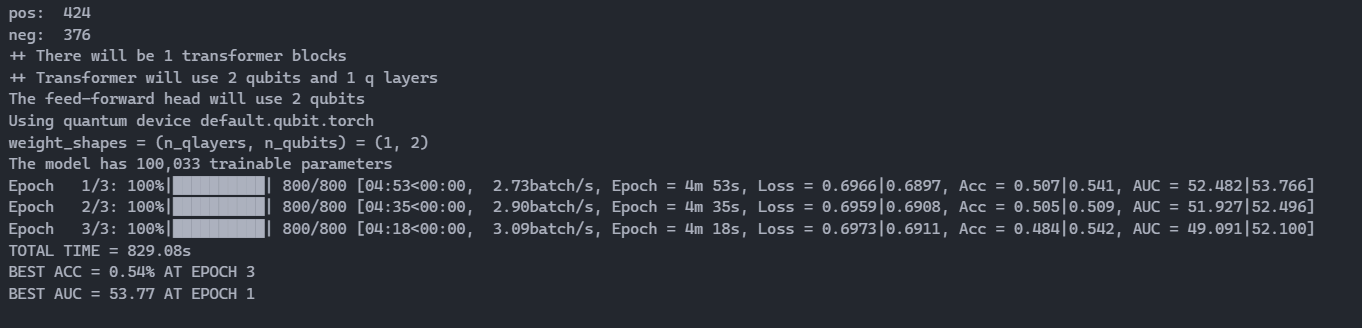


## Evaluation


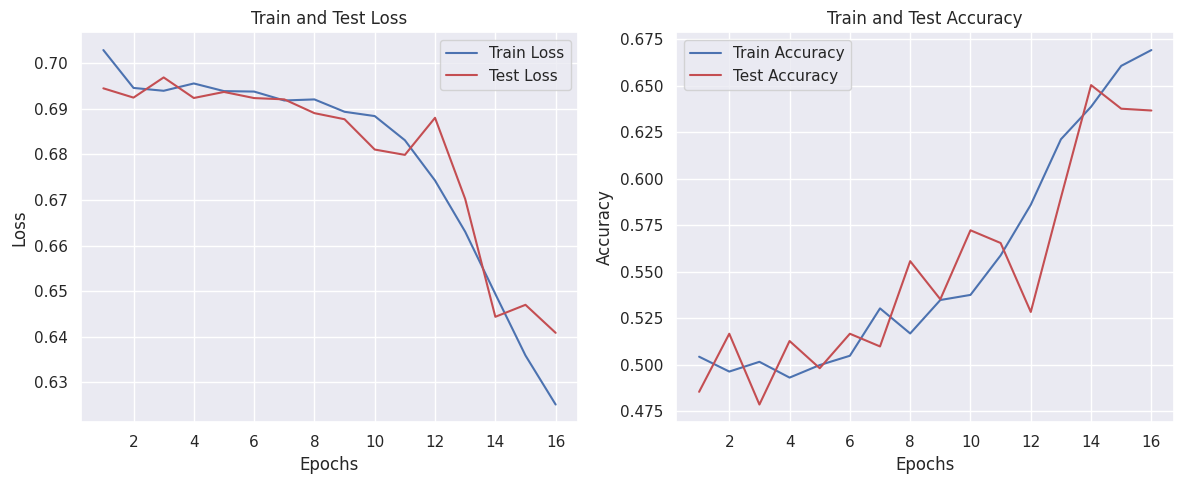

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# plt.style.use("classic")
# plt.style.use("dark_background")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "b-", label="Train Loss")
plt.plot(epochs, test_loss, "r-", label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc, "r-", label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

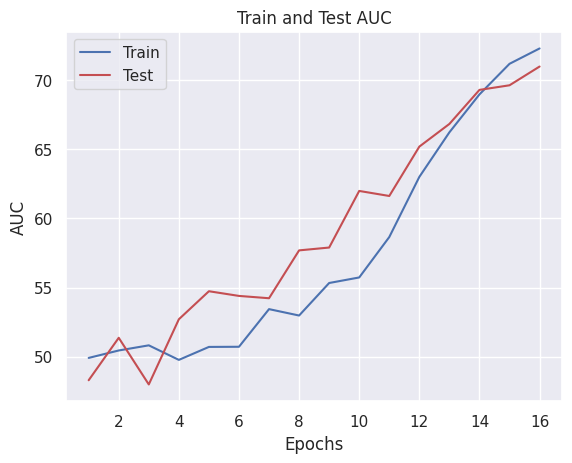

In [24]:
plt.plot(epochs, train_auc, "b-", label="Train")
plt.plot(epochs, test_auc, "r-", label="Test")
plt.title("Train and Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [25]:
checkpoint = torch.load(
    ".models/model_and_metrics_epoch_10.pt"
)  # Replace x with the epoch number

# Load the metrics
epoch = checkpoint["epoch"]
train_loss = checkpoint["train_loss"]
train_acc = checkpoint["train_acc"]
train_auc = checkpoint["train_auc"]
test_loss = checkpoint["test_loss"]
test_acc = checkpoint["test_acc"]
test_auc = checkpoint["test_auc"]

test_acc

FileNotFoundError: [Errno 2] No such file or directory: '.models/model_and_metrics_epoch_10.pt'

In [ ]:
# fig, ax = plt.subplots(figsize=(4, 3.5))
# # ax.plot(classical_qg_metrics['train_aucs'], label='Classical Training', color='orange', linestyle='--')
# # ax.plot(quantum_qg_metrics['train_aucs'], label='Quantum Training', color='purple', linestyle='--')
# # ax.plot(classical_qg_metrics['val_aucs'], label='Classical Validation', color='orange')
# # ax.plot(quantum_qg_metrics['val_aucs'], label='Quantum Validation', color='purple')
# ax.plot(auc, label="Quantum Validation", color="purple")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid()
# ax.set_ylim(0.5, 1)